### E10S Experiment Aurora (all histograms)

This analysis compares all simple measures and histograms between the control and experiment branch.

In [1]:
import ujson as json
import matplotlib.pyplot as plt
import pandas as pd
import IPython

from pyspark.sql import SQLContext
from collections import defaultdict
from __future__ import division
from itertools import groupby
from operator import itemgetter

from moztelemetry.histogram import Histogram
from mozaggregator.aggregator import _aggregate_ping, _aggregate_aggregates, _trim_payload, simple_measures_labels, count_histogram_labels

%pylab inline
IPython.core.pylabtools.figsize(16, 7)

Unable to parse whitelist (/home/hadoop/anaconda/lib/python2.7/site-packages/moztelemetry/bucket-whitelist.json). Assuming all histograms are acceptable.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sc.defaultParallelism

16

#### Get e10s and non-e10s partitions

In [4]:
dataset = sqlContext.load("s3://telemetry-parquet/e10s-experiment/generationDate=20151117", "parquet")

How many pings do we have in each branch?

In [5]:
dataset.filter(dataset["experimentBranch"] == "experiment").count()

46749L

In [6]:
dataset.filter(dataset["experimentBranch"] == "control").count()

46716L

## Histograms

In [7]:
def chi2_distance(histA, histB, eps = 1e-10, normalize = True):    
    if normalize:
        histA = histA/histA.sum()
        histB = histB/histB.sum()
    
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    return d


def compare_histogram(histogram, e10s, none10s): 
    eTotal = e10s["histogram"]
    nTotal = none10s["histogram"]
    
    if e10s["count"] < 5000 or none10s["count"] < 5000:
        return
    
    chi2dist = chi2_distance(eTotal, nTotal)
    if chi2dist < 0.001:
        return
    
    eTotal = 100*eTotal/eTotal.sum()
    nTotal = 100*nTotal/nTotal.sum()
        
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.3)
        
    ax = fig.add_subplot(1, 1, 1)
    ax2 = ax.twinx()
    width = 0.4
    ylim = max(eTotal.max(), nTotal.max())
        
    eTotal.plot(kind="bar", alpha=0.5, color="green", label="e10s", ax=ax, width=width, position=0, ylim=(0, ylim + 1))
    nTotal.plot(kind="bar", alpha=0.5, color="blue", label="non e10s", ax=ax2, width=width, position=1, grid=False, ylim=ax.get_ylim())
        
    ax.legend(ax.get_legend_handles_labels()[0] + ax2.get_legend_handles_labels()[0],
              ["e10s ({} samples".format(e10s["count"]), "non e10s ({} samples)".format(none10s["count"])])

    print "The chi2 distance for {} is {}".format(histogram, chi2dist)
    plt.title(histogram)
    plt.xlabel(histogram)
    plt.ylabel("Frequency %")
    plt.show()
    
    
def map_ping_to_dimensions(ping):
    subset = {}    
    subset["payload"] = {"histograms": json.loads(ping.histograms),
                         "keyedHistograms": json.loads(ping.keyedHistograms),
                         "simpleMeasurements": json.loads(ping.simpleMeasurements)}
    
    subset["payload"]["childPayloads"] = [_trim_payload(c) for c in json.loads(ping.childPayloads)]
    return (False if ping.experimentBranch == "control" else True, subset)


def reduce_histograms(h1, h2):
    res = {}
    
    res["count"] = h1["count"] + h2["count"]
    res["sum"] = h1["sum"] + h2["sum"]
    res["histogram"] = {}

    for k in h1["histogram"].keys() + h2["histogram"].keys():
        res["histogram"][k] = h1["histogram"].get(k, 0L) + h2["histogram"].get(k, 0L)
        
    return res


def keymod_aggregates(branch_aggregates):
    keymod_branch_aggregates = [(k[0], v) for k, v in branch_aggregates[1].iteritems()]
    grouped = groupby(sorted(keymod_branch_aggregates), key=itemgetter(0))
    return dict([(k, reduce(reduce_histograms, map(itemgetter(1), group))) for k, group in grouped])


def get_complete_histogram(metric, values):
    if metric.startswith("SIMPLE_MEASURES"):
        histogram = pd.Series({int(k): v for k, v in values.iteritems()}, index=simple_measures_labels).fillna(0)
    elif metric.startswith("[[COUNT]]_"):  # Count histogram
        histogram = pd.Series({int(k): v for k, v in values.iteritems()}, index=count_histogram_labels).fillna(0)
    else:
        histogram = Histogram(metric, {"values": values}, "https://hg.mozilla.org/releases/mozilla-aurora/rev/9d3bc275a924/").buckets
        
    return histogram


def complete_histograms(histograms):
    for k, v in histograms.iteritems():
        try:
            v["histogram"] = get_complete_histogram(k, v["histogram"])
            yield (k, v)
        except:
            pass

In [8]:
trimmed = dataset.rdd.map(map_ping_to_dimensions)
partial_aggregates = trimmed.aggregateByKey(defaultdict(dict), _aggregate_ping, _aggregate_aggregates).collect()
aggregates = map(keymod_aggregates, partial_aggregates)
aggregates = map(lambda x: dict(complete_histograms(x)), aggregates)

ne10s_keys = set(aggregates[0].keys())
we10s_keys = set(aggregates[1].keys())
keys = list(ne10s_keys.intersection(we10s_keys))

In [9]:
print "Histogram that appear in non-e10s pings only:"
for x in sorted(ne10s_keys.difference(we10s_keys)):
    print x

print "\nHistogram that appear in e10s pings only:"
for x in sorted(we10s_keys.difference(ne10s_keys)):
    print x

Histogram that appear in non-e10s pings only:
CACHE_SERVICE_LOCK_WAIT_MAINTHREAD_NSCACHESERVICE_DISKDEVICEHEAPSIZE
CACHE_SERVICE_LOCK_WAIT_MAINTHREAD_NSCACHESERVICE_SETMEMORYCACHEMAXENTRYSIZE
DEVTOOLS_DEBUGGER_RDP_REMOTE_RELOAD_MS
DEVTOOLS_TILT_OPENED_BOOLEAN
DEVTOOLS_TILT_TIME_ACTIVE_SECONDS
DEVTOOLS_WEBIDE_WIFI_CONNECTION_RESULT
DWRITEFONT_INIT_PROBLEM
FX_TAB_SWITCH_TOTAL_MS
SEARCH_SERVICE_NONUS_COUNTRY_MISMATCHED_PLATFORM_OSX
SEARCH_SERVICE_US_COUNTRY_MISMATCHED_PLATFORM_OSX
SSL_VERSION_FALLBACK_INAPPROPRIATE
STARTUP_CACHE_LM_INCONSISTENT
STARTUP_CACHE_MEMORY_SEARCH_2
STARTUP_CACHE_OFFLINE_SEARCH_2
STARTUP_CACHE_SERVICE_LOCK_WAIT_MAINTHREAD_NSCACHEENTRYDESCRIPTOR_GETEXPIRATIONTIME
STARTUP_CACHE_SERVICE_LOCK_WAIT_MAINTHREAD_NSCACHEENTRYDESCRIPTOR_GETLASTMODIFIED
STARTUP_CACHE_SERVICE_LOCK_WAIT_MAINTHREAD_NSCACHEENTRYDESCRIPTOR_GETSTORAGEPOLICY
STARTUP_HTTP_CACHE_ENTRY_ALIVE_TIME
STARTUP_HTTP_CACHE_ENTRY_RELOAD_TIME
STARTUP_HTTP_CACHE_ENTRY_REUSE_COUNT
STARTUP_HTTP_PAGE_CACHE_READ_TIM

The chi2 distance for BLOCKED_ON_PLUGIN_MODULE_INIT_MS is 0.999806519517


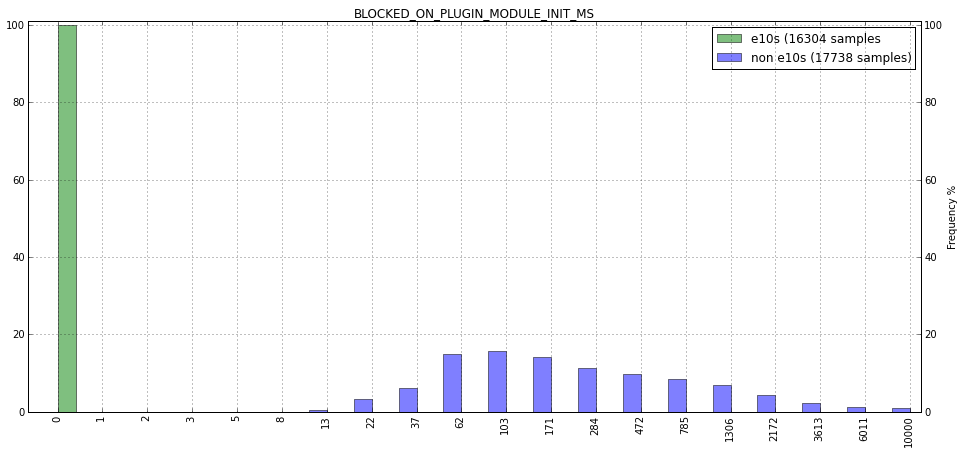

The chi2 distance for E10S_AUTOSTART_STATUS is 0.99929455874


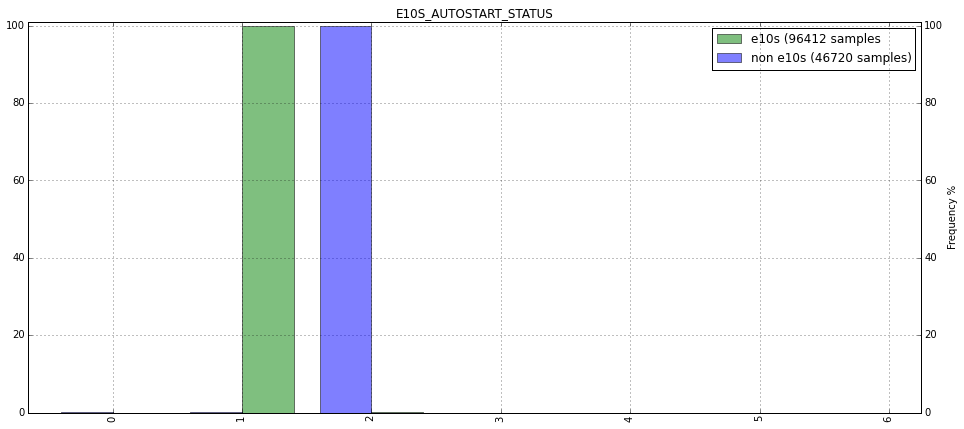

The chi2 distance for E10S_AUTOSTART is 0.999209004625


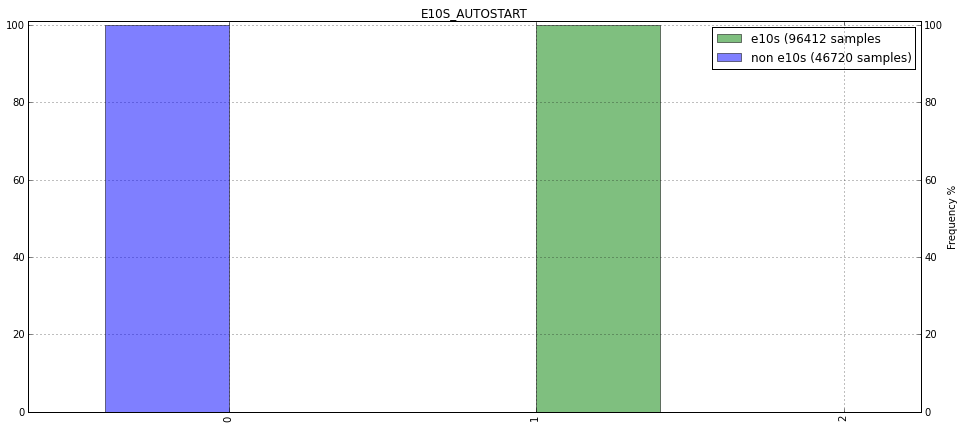

The chi2 distance for E10S_WINDOW is 0.996505858976


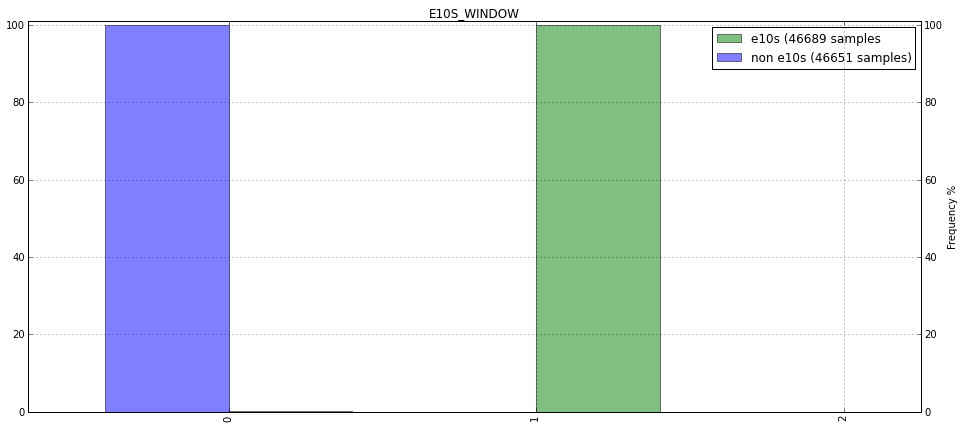

The chi2 distance for FIND_PLUGINS is 0.7214826278


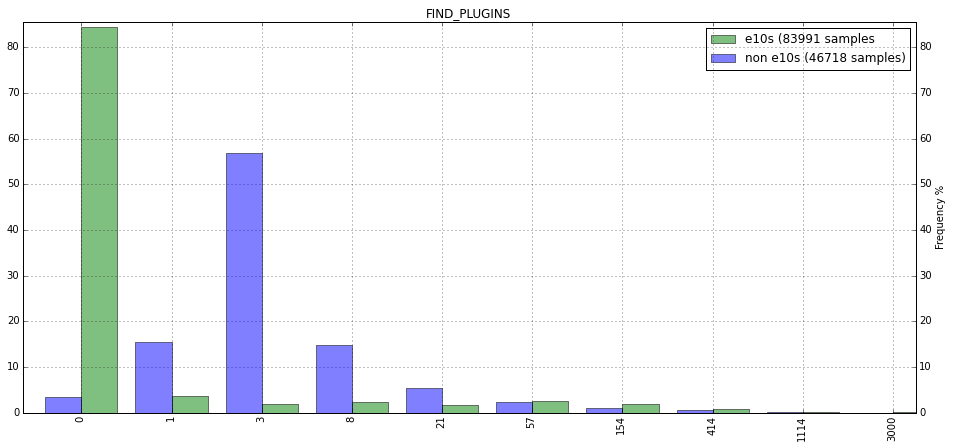

The chi2 distance for HTTP_REQUEST_PER_PAGE_FROM_CACHE is 0.482042386182


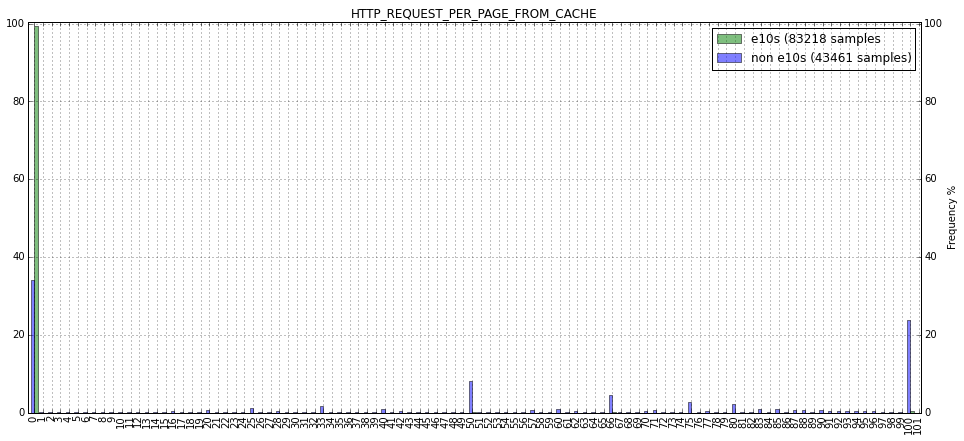

The chi2 distance for MEMORY_JS_COMPARTMENTS_SYSTEM is 0.455464767245


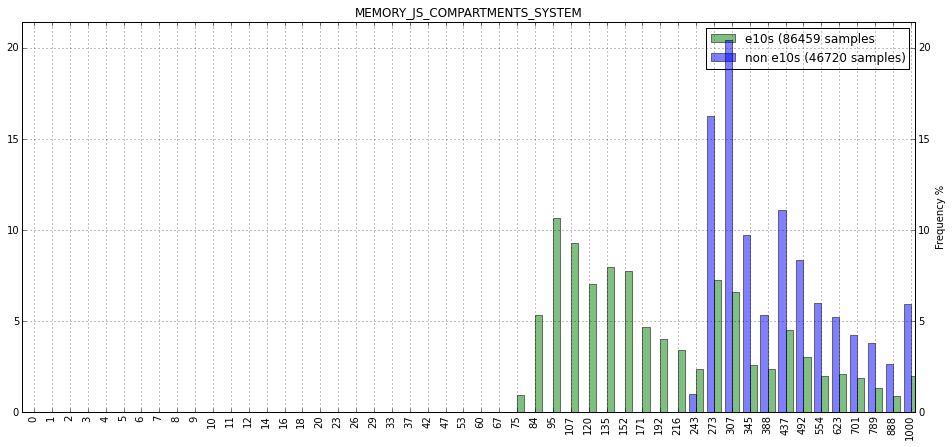

The chi2 distance for FX_THUMBNAILS_CAPTURE_TIME_MS is 0.451154146776


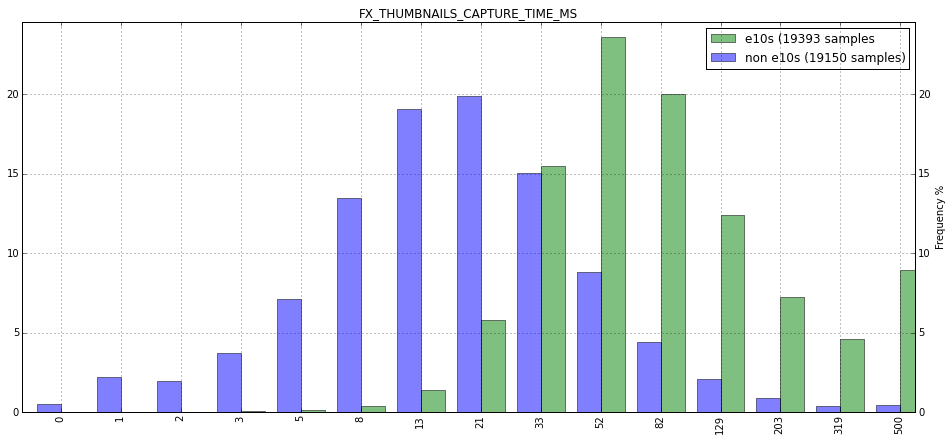

The chi2 distance for STARTUP_NETWORK_CACHE_METADATA_SIZE is 0.384629107591


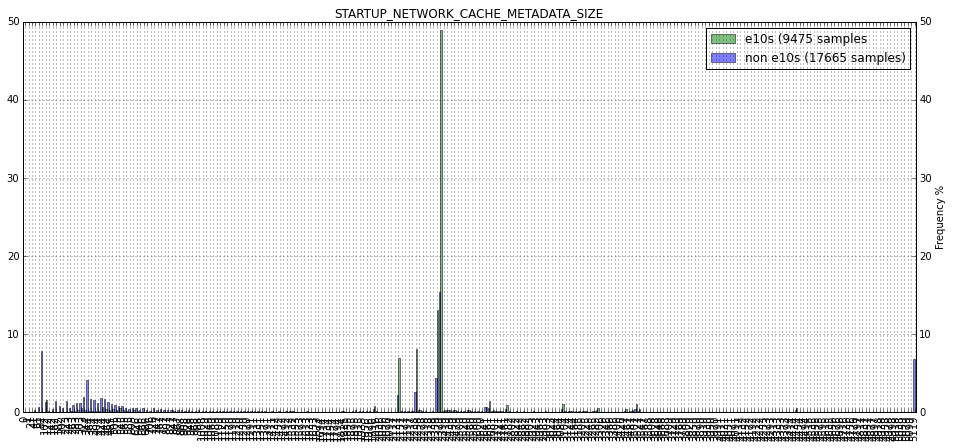

The chi2 distance for STARTUP_NETWORK_CACHE_METADATA_FIRST_READ_SIZE is 0.357544738426


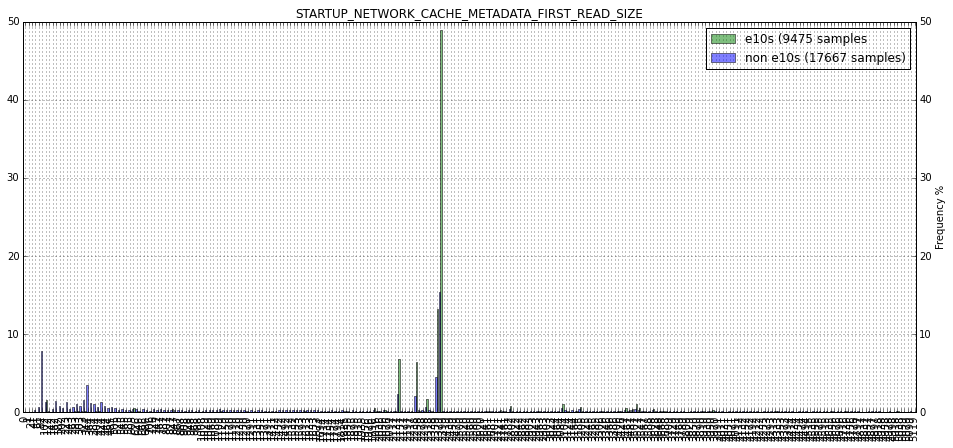

The chi2 distance for HTTP_PAGE_DNS_ISSUE_TIME is 0.219360869552


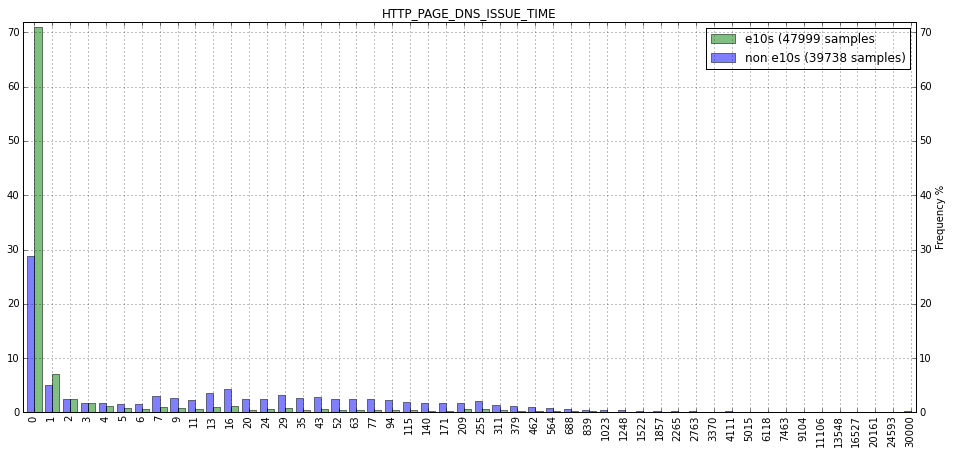

The chi2 distance for GC_MINOR_REASON_LONG is 0.215434897072


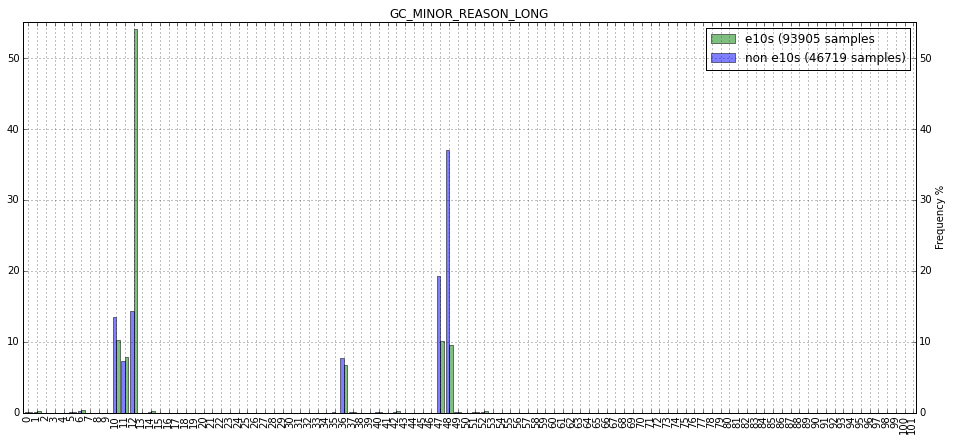

The chi2 distance for HTTP_SUB_DNS_ISSUE_TIME is 0.212657197006


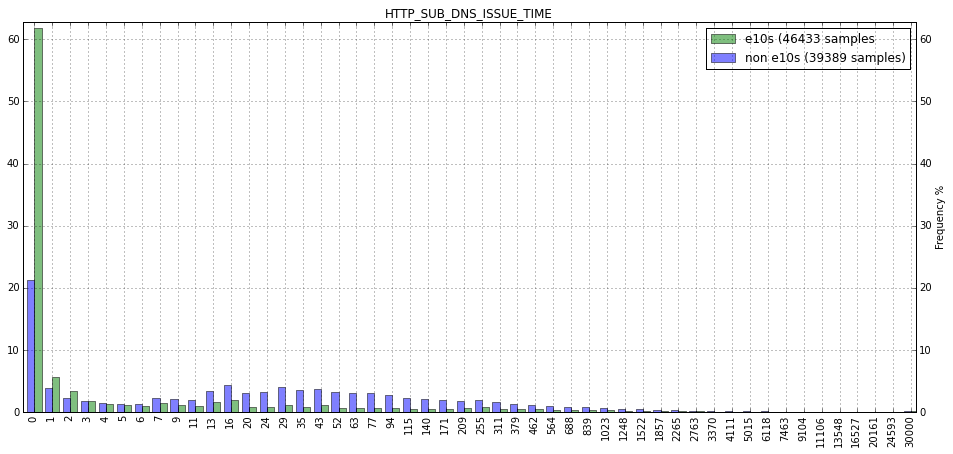

The chi2 distance for SIMPLE_MEASURES_FIRSTLOADURI is 0.210313369798


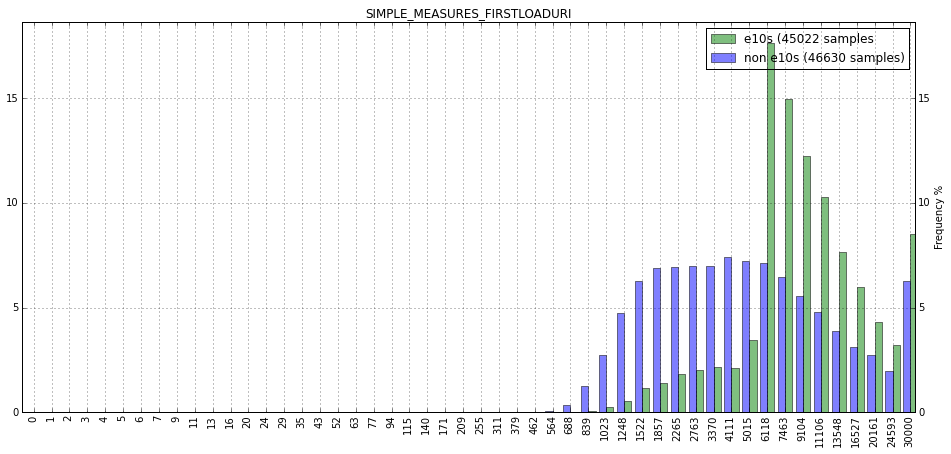

The chi2 distance for STARTUP_HTTP_CACHE_DISPOSITION_2_V2 is 0.181783243406


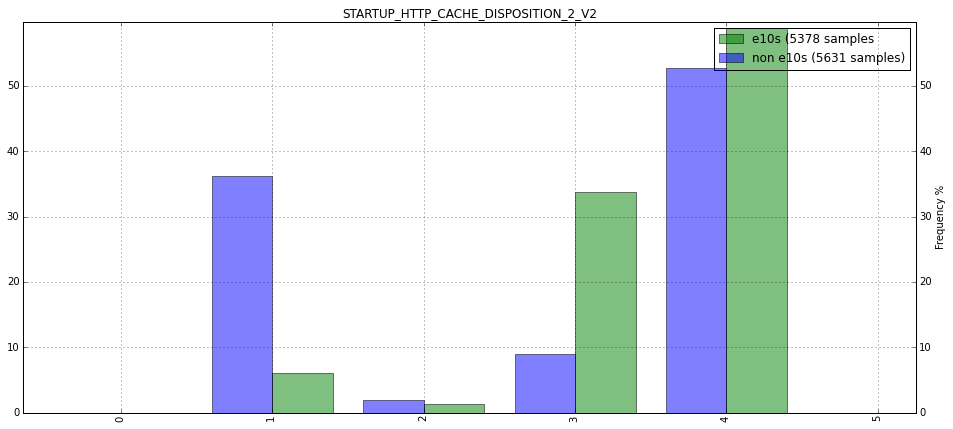

The chi2 distance for FX_TAB_SWITCH_UPDATE_MS is 0.162275897345


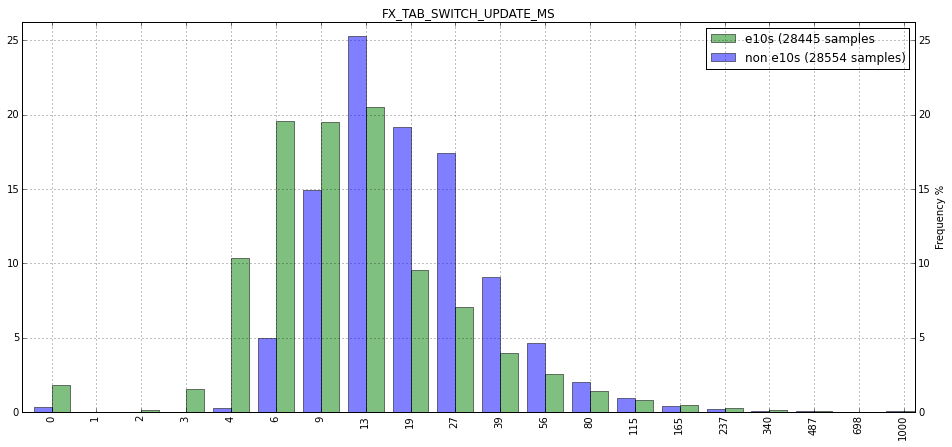

The chi2 distance for STARTUP_HTTP_RESPONSE_VERSION is 0.160361225905


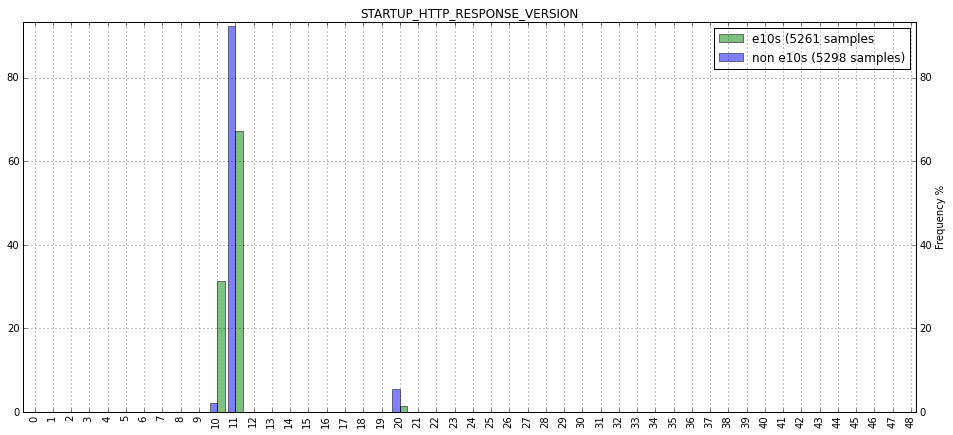

The chi2 distance for HTTP_SUB_DNS_LOOKUP_TIME is 0.156880923634


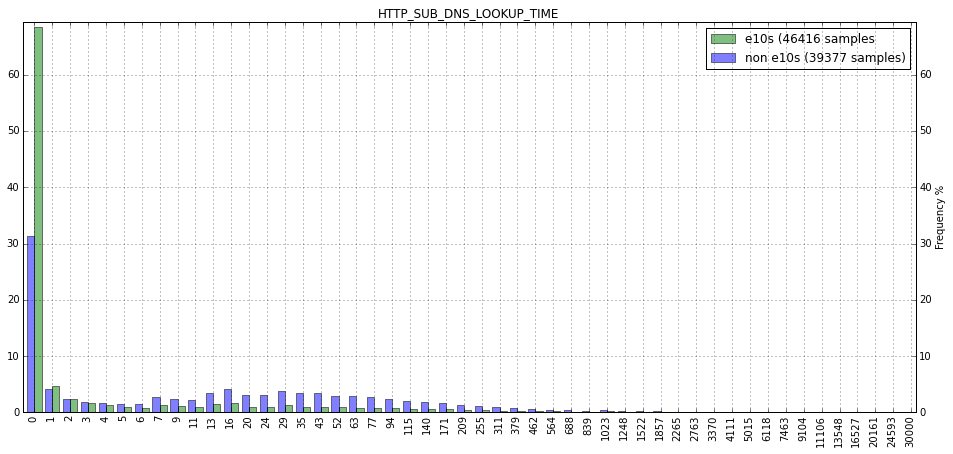

The chi2 distance for CYCLE_COLLECTOR_VISITED_GCED is 0.150648039147


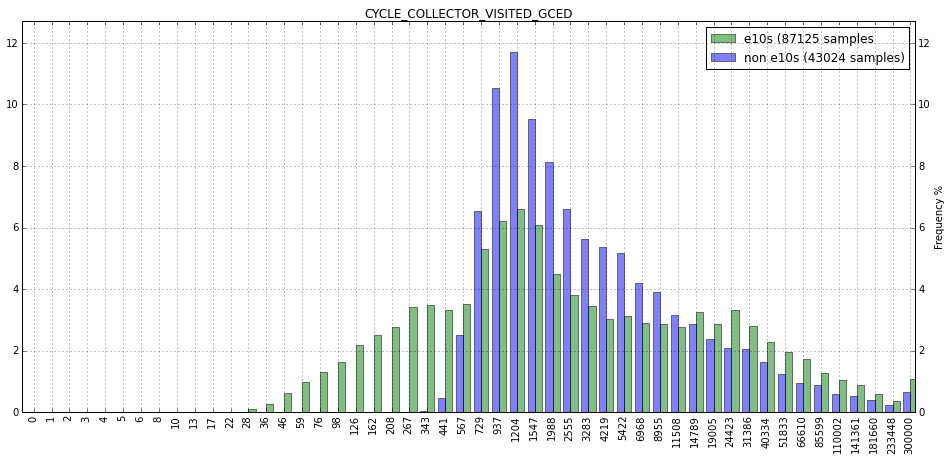

The chi2 distance for PLUGIN_LOAD_METADATA is 0.145501325034


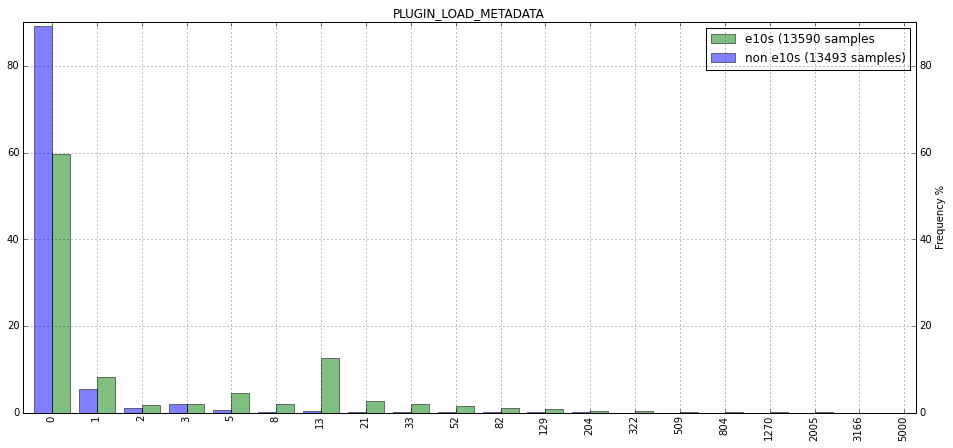

The chi2 distance for FX_TAB_CLICK_MS is 0.142194686187


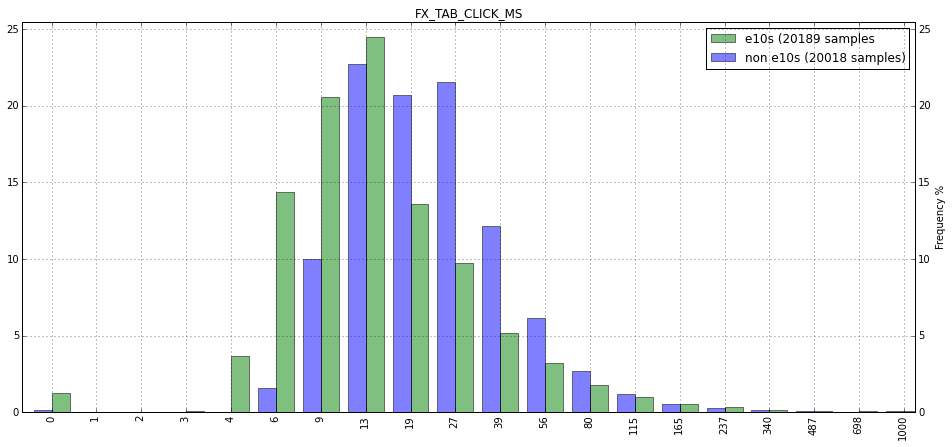

The chi2 distance for GC_MARK_MS is 0.142102732141


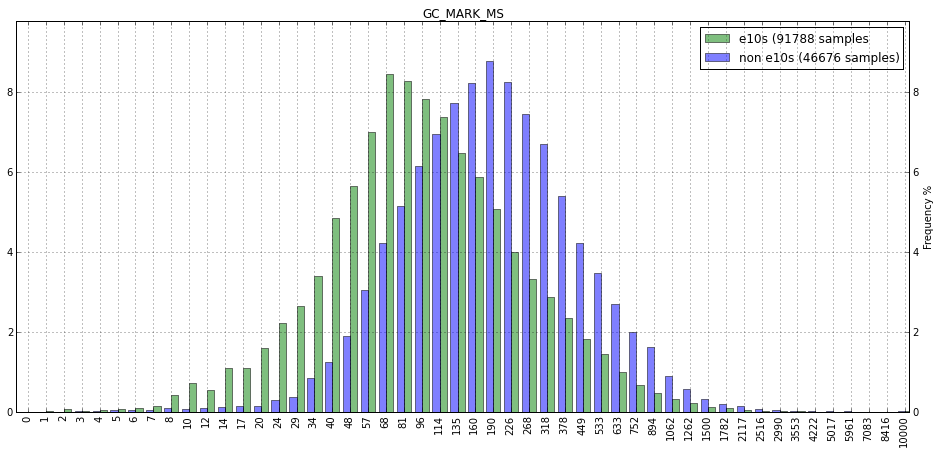

The chi2 distance for GC_MARK_ROOTS_MS is 0.141435382838


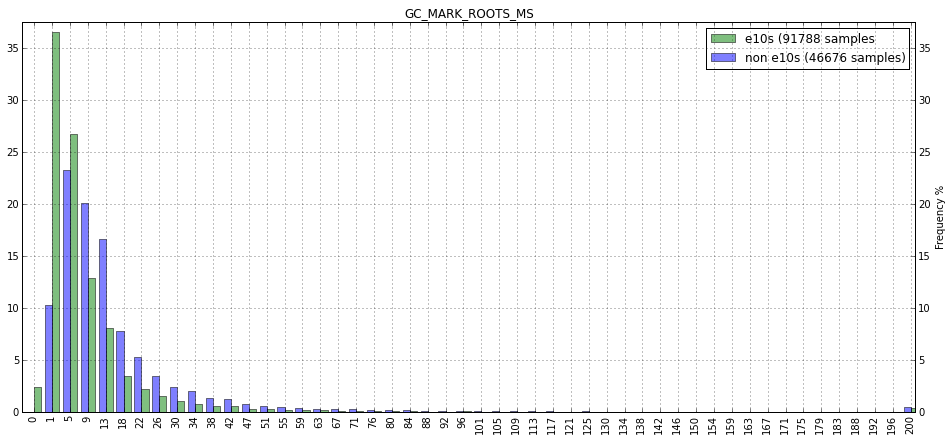

The chi2 distance for HTTP_PAGE_OPEN_TO_FIRST_FROM_CACHE_V2 is 0.134900245746


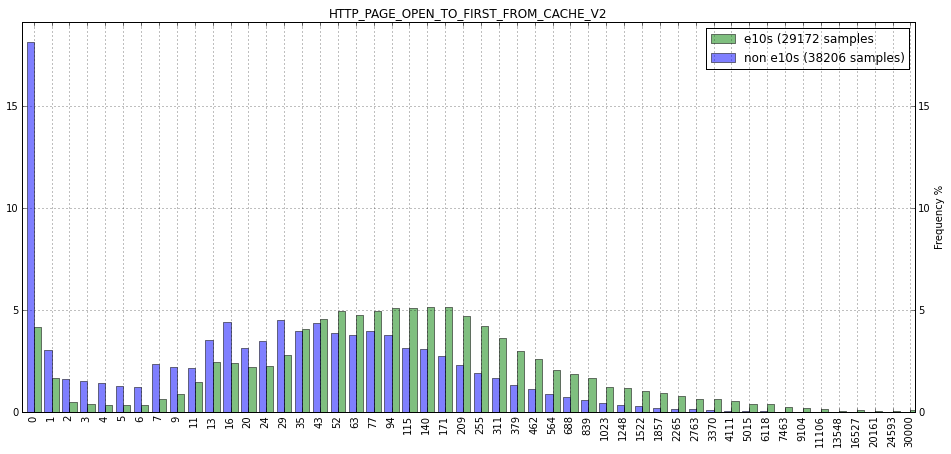

The chi2 distance for MEMORY_JS_COMPARTMENTS_USER is 0.132552896979


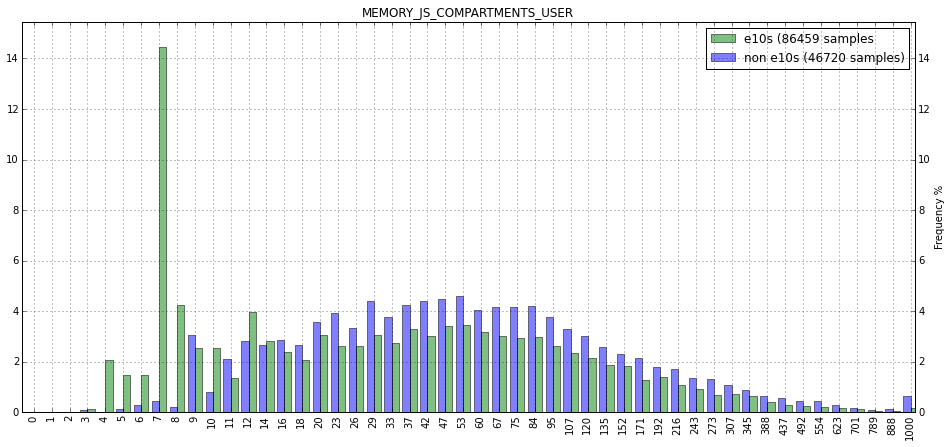

The chi2 distance for SIMPLE_MEASURES_MAXIMALNUMBEROFCONCURRENTTHREADS is 0.131926728217


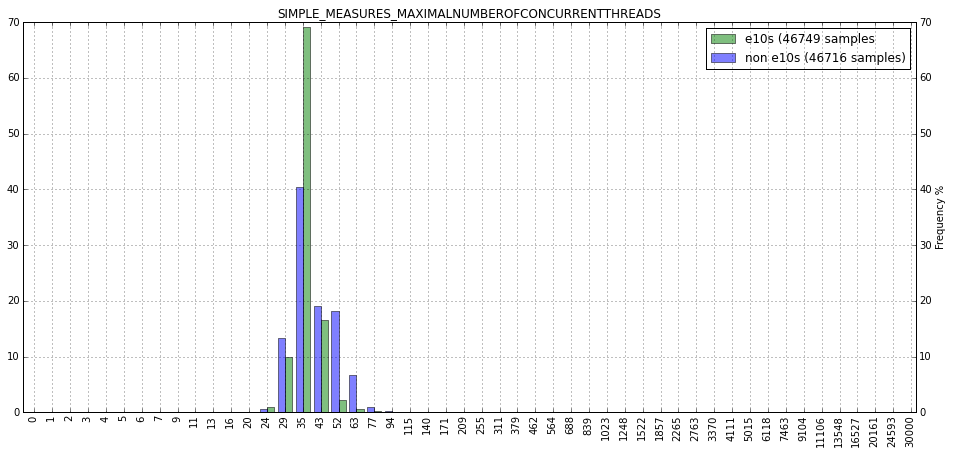

The chi2 distance for GC_MS is 0.13136109706


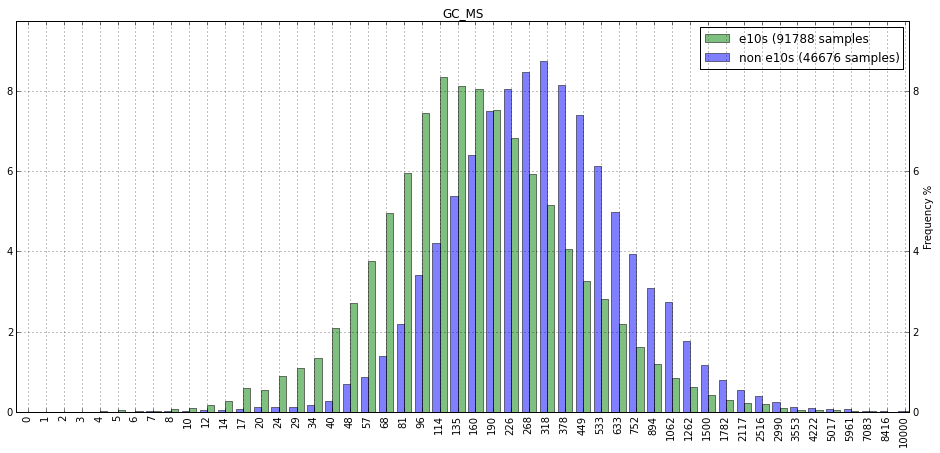

The chi2 distance for GC_MINOR_REASON is 0.12538713869


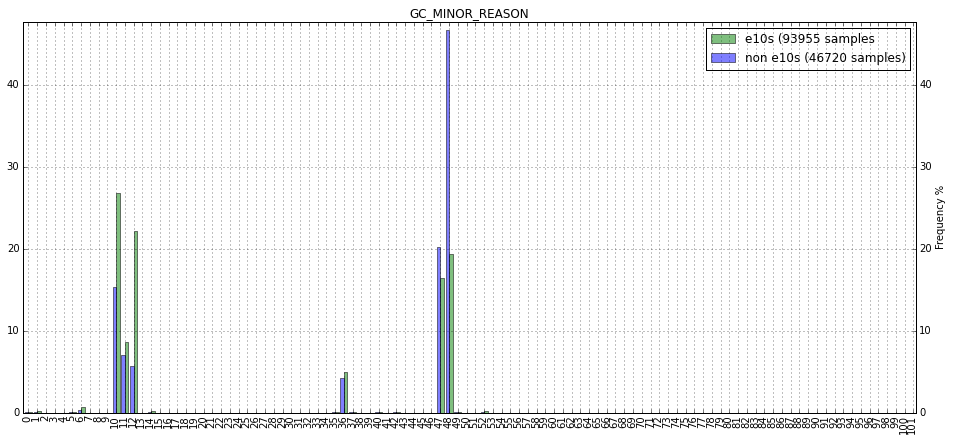

The chi2 distance for SIMPLE_MEASURES_JS_SETPROTO is 0.117619236733


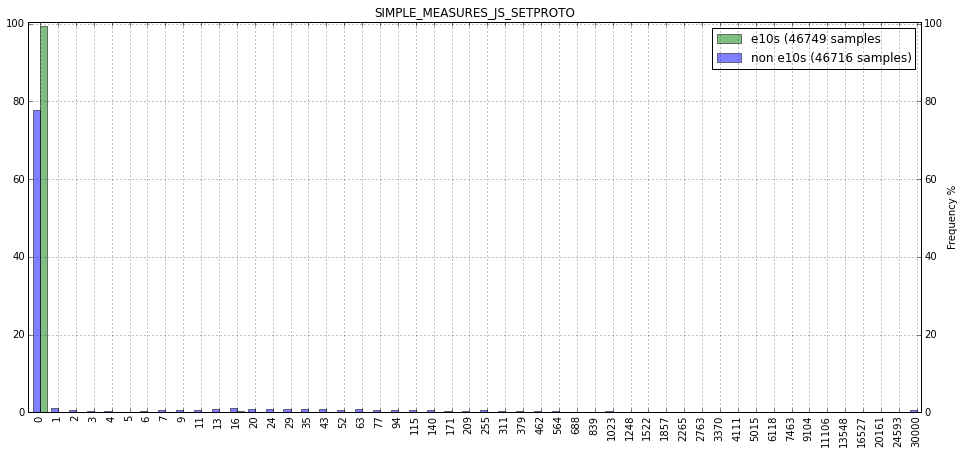

The chi2 distance for HTTP_SUB_REVALIDATION is 0.116044050131


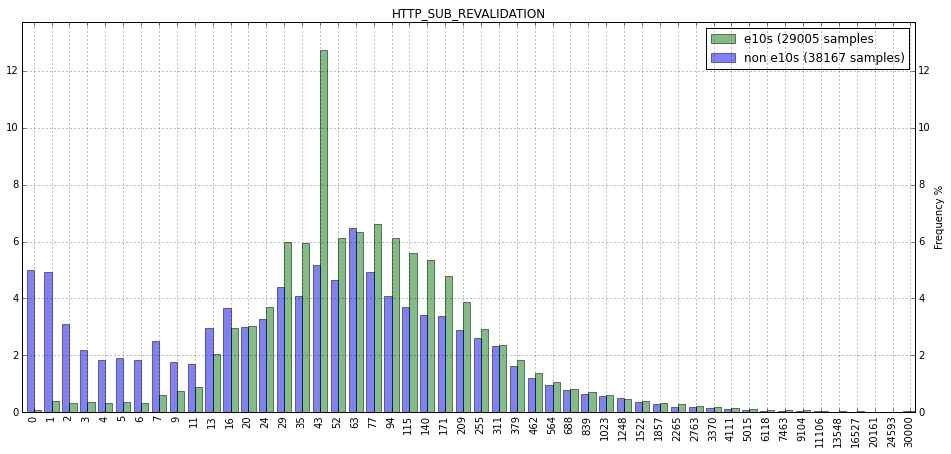

The chi2 distance for HTTP_PAGE_OPEN_TO_FIRST_SENT is 0.111657983002


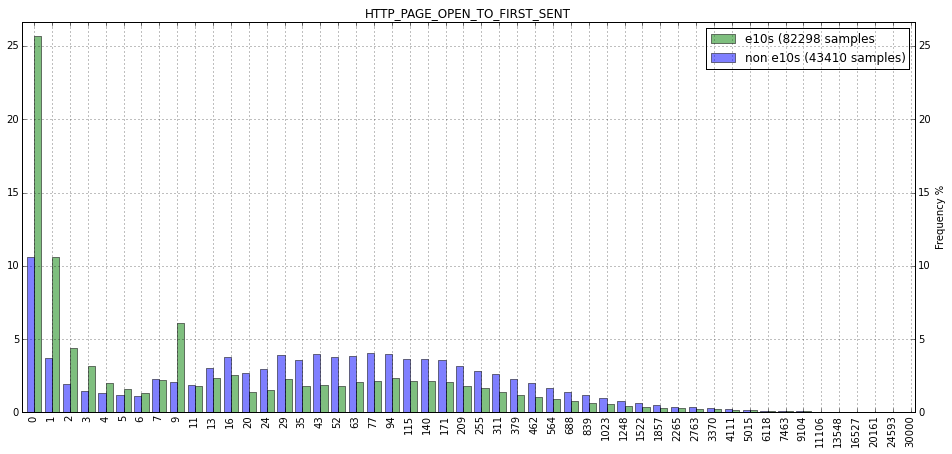

The chi2 distance for MEMORY_VSIZE is 0.109552771824


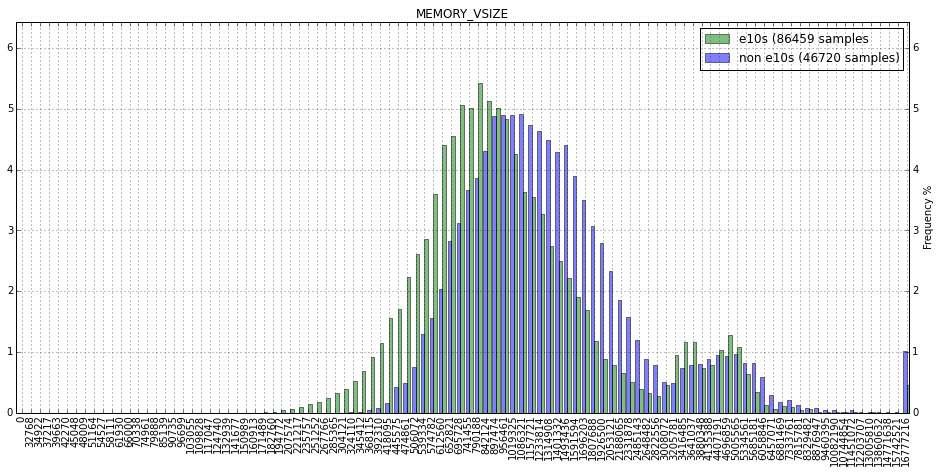

The chi2 distance for HTTP_PAGE_DNS_LOOKUP_TIME is 0.105546629559


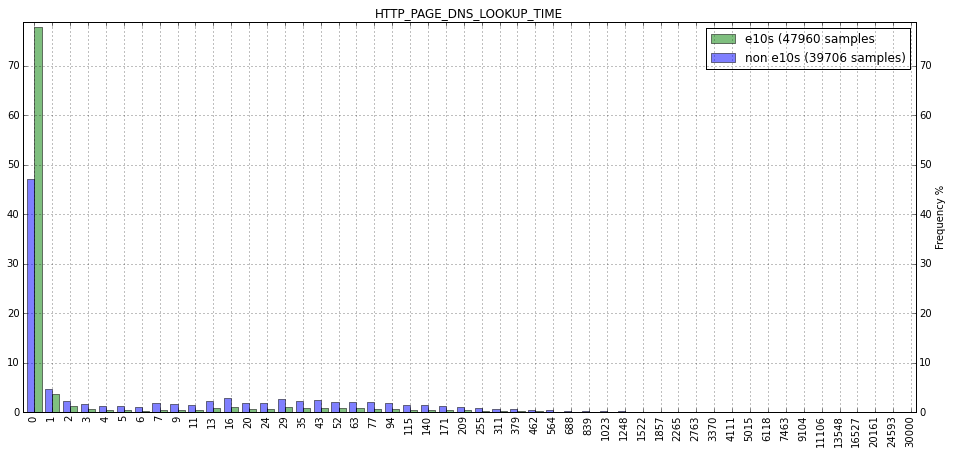

The chi2 distance for CERT_VALIDATION_HTTP_REQUEST_CANCELED_TIME is 0.104896094797


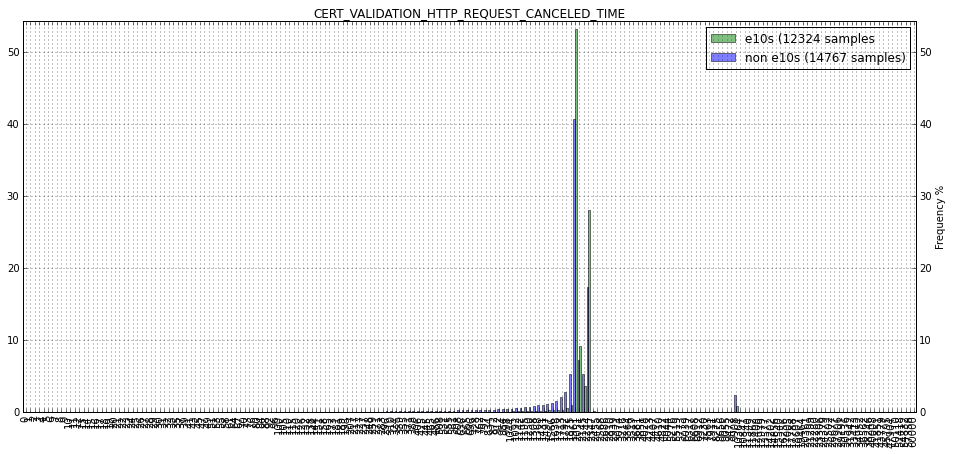

The chi2 distance for GC_SWEEP_MS is 0.104788936502


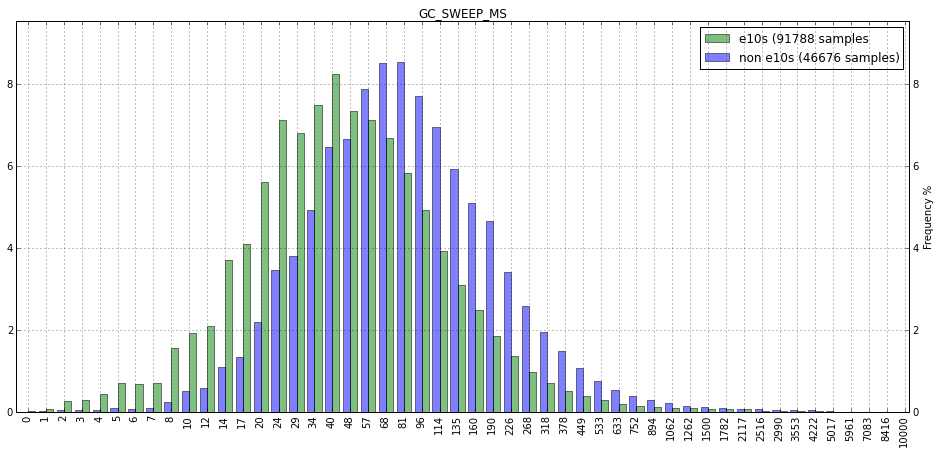

The chi2 distance for MEMORY_RESIDENT is 0.10431679535


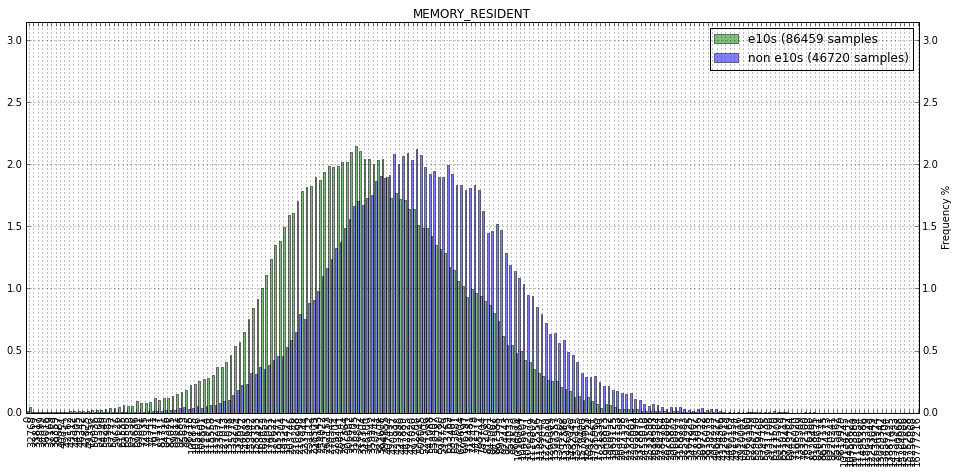

The chi2 distance for CYCLE_COLLECTOR_VISITED_REF_COUNTED is 0.097596239831


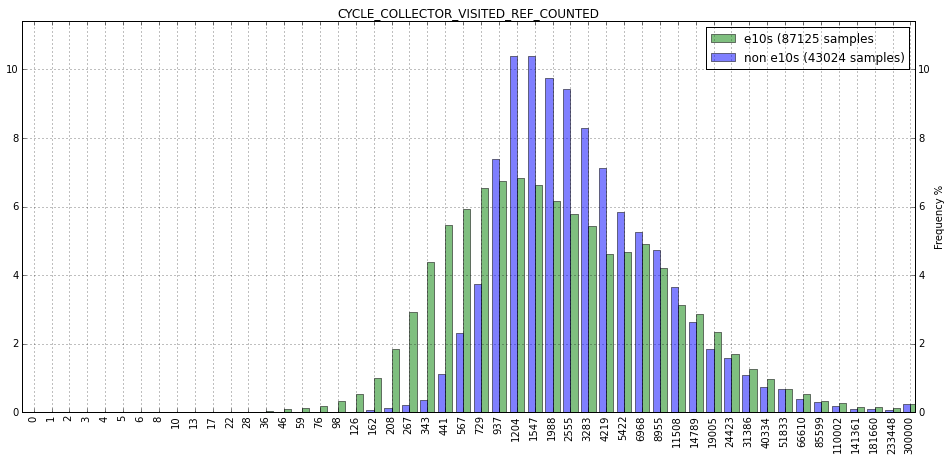

The chi2 distance for MEMORY_HEAP_ALLOCATED is 0.0975348637717


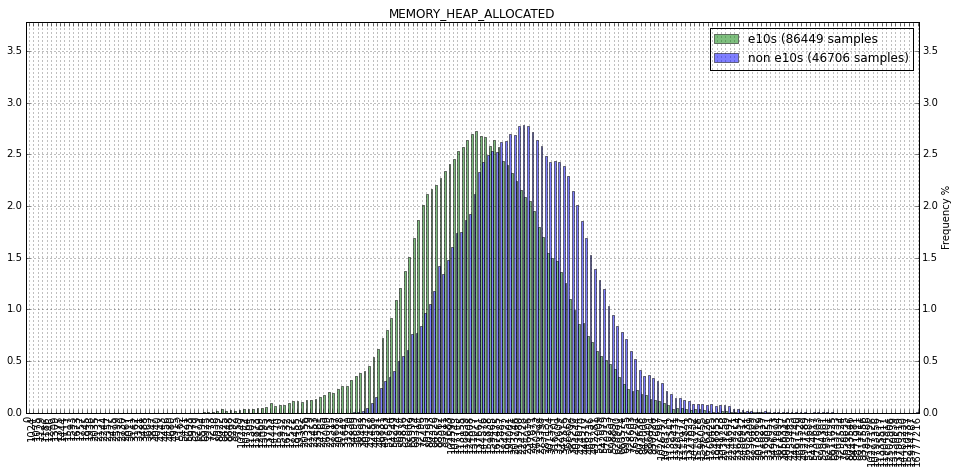

The chi2 distance for DNS_FAILED_LOOKUP_TIME is 0.0948715630967


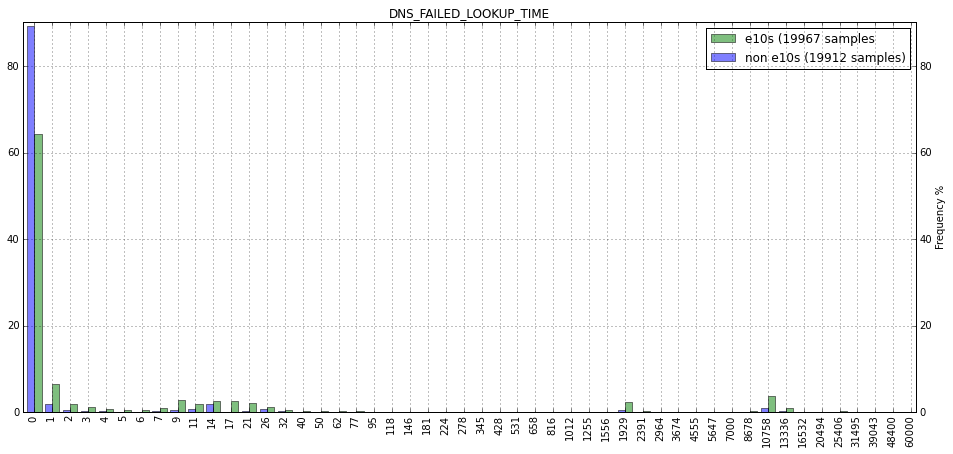

The chi2 distance for MEMORY_JS_GC_HEAP is 0.0904553112569


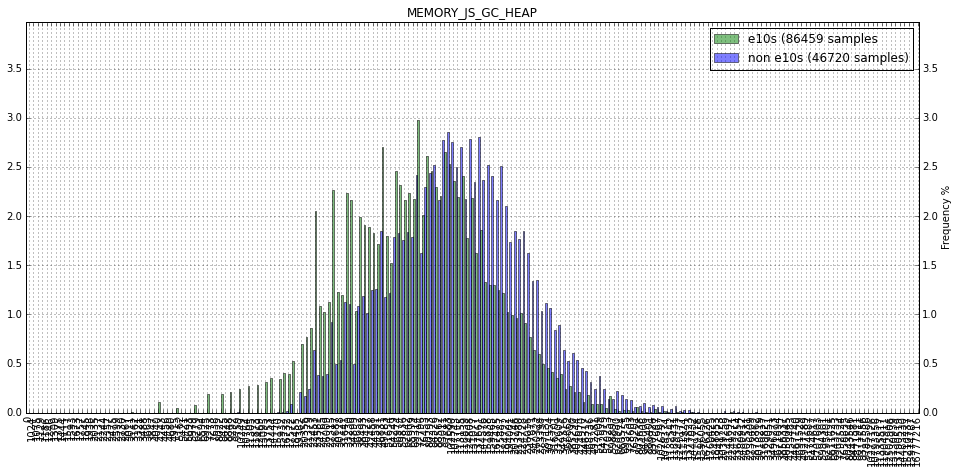

The chi2 distance for FX_THUMBNAILS_BG_CAPTURE_QUEUE_TIME_MS is 0.0850516029749


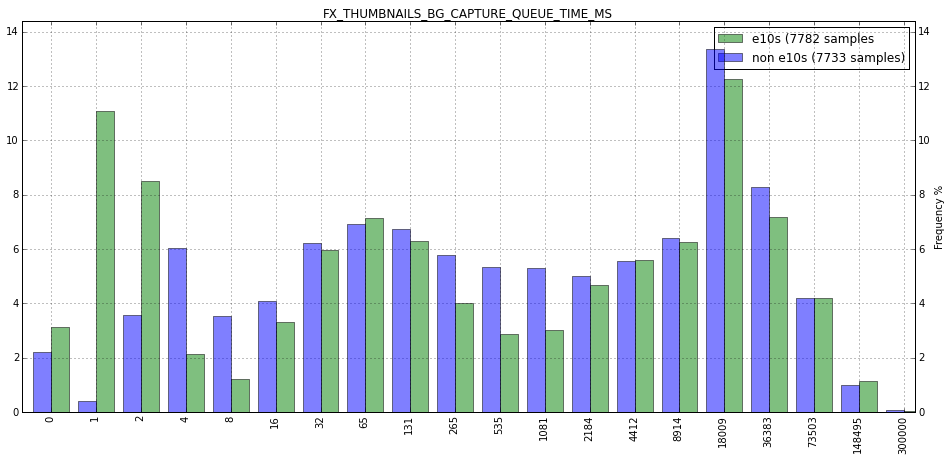

The chi2 distance for HTTP_SUB_OPEN_TO_FIRST_SENT is 0.0846056310817


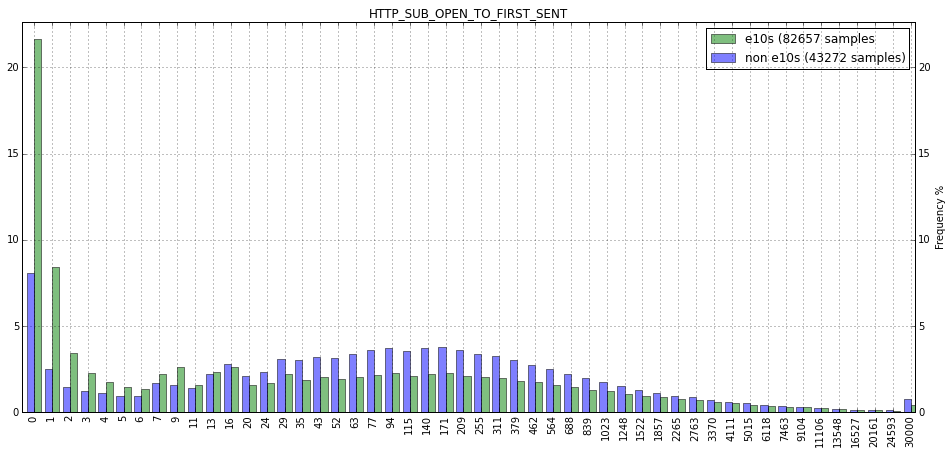

The chi2 distance for HTTP_PAGE_COMPLETE_LOAD_CACHED_V2 is 0.0708967003604


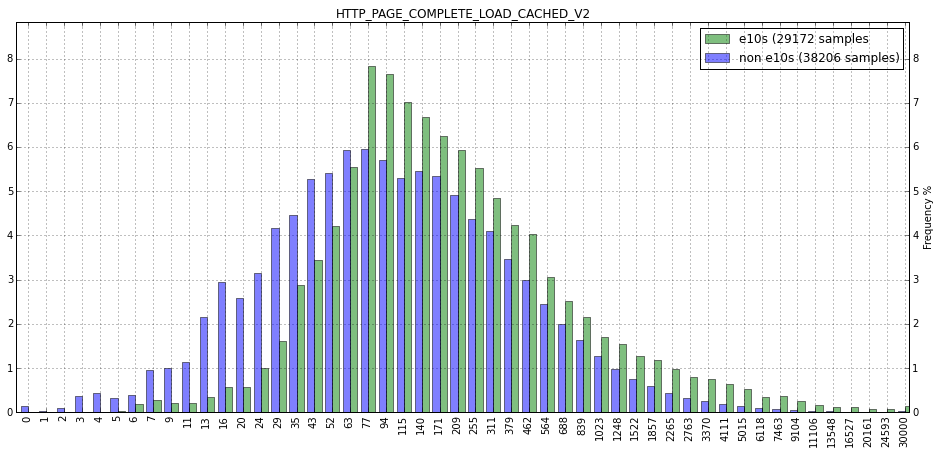

The chi2 distance for HTTP_PAGE_COMPLETE_LOAD is 0.0708661381374


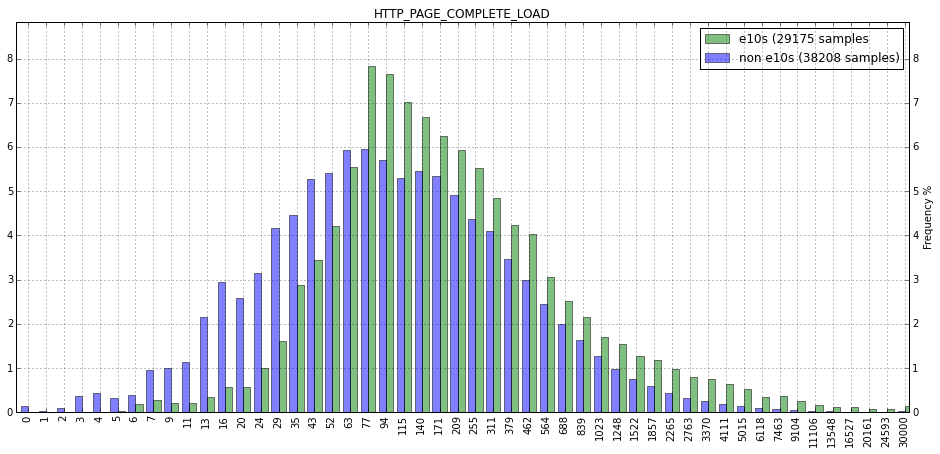

The chi2 distance for LOCALDOMSTORAGE_GETVALUE_BLOCKING_MS is 0.0699092788769


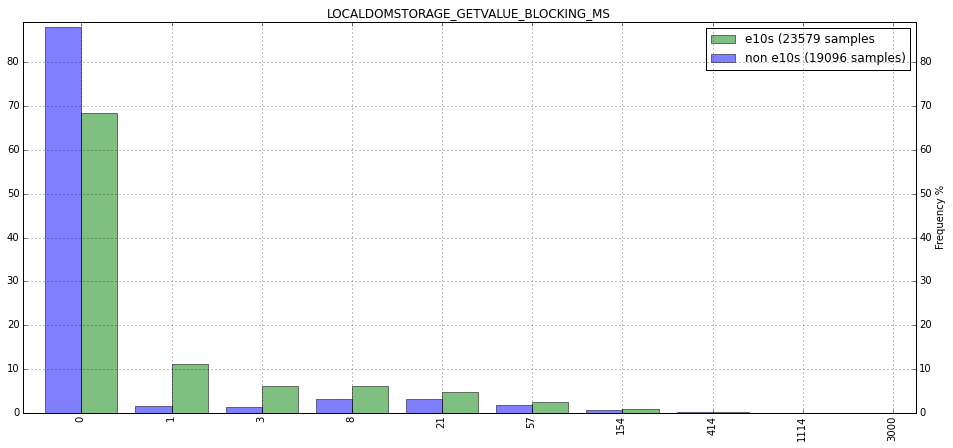

The chi2 distance for CYCLE_COLLECTOR is 0.0669322758901


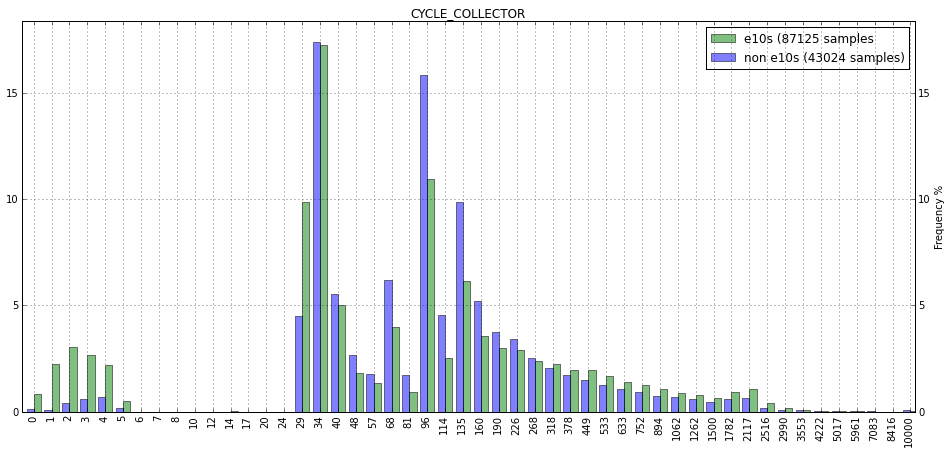

The chi2 distance for CYCLE_COLLECTOR_FULL is 0.0668957842013


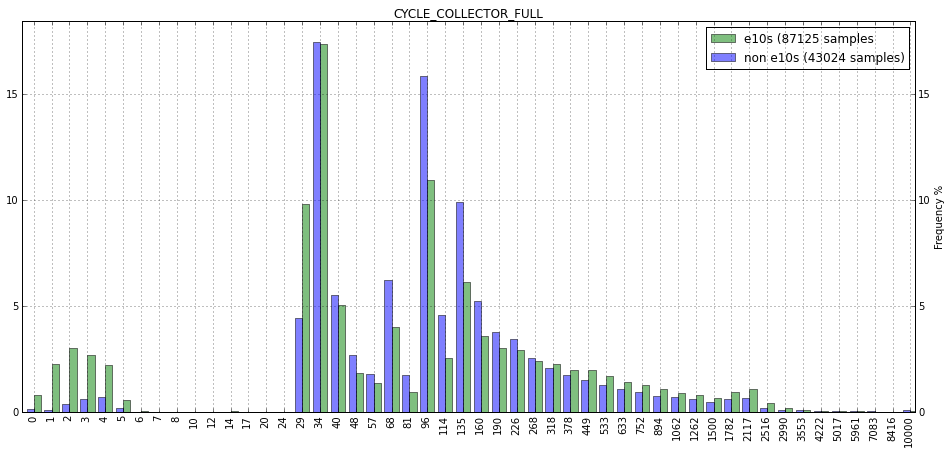

The chi2 distance for FX_PAGE_LOAD_MS is 0.0648147895508


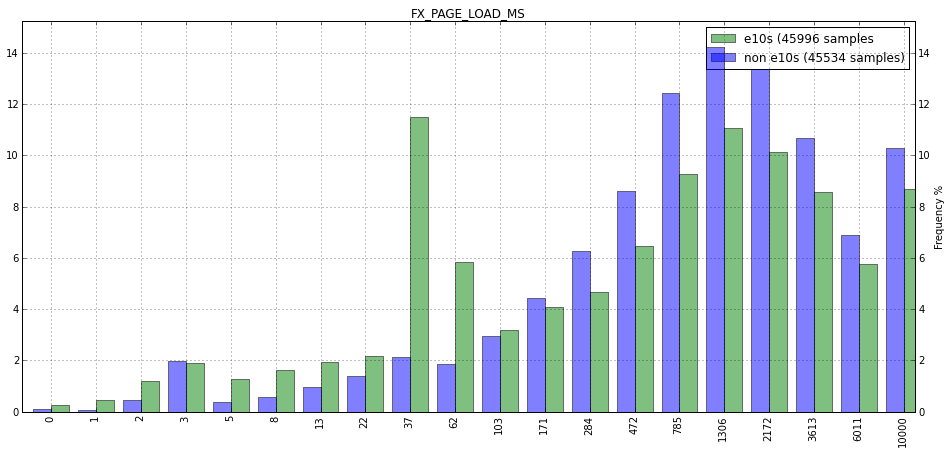

The chi2 distance for PAINT_BUILD_DISPLAYLIST_TIME is 0.0635556415931


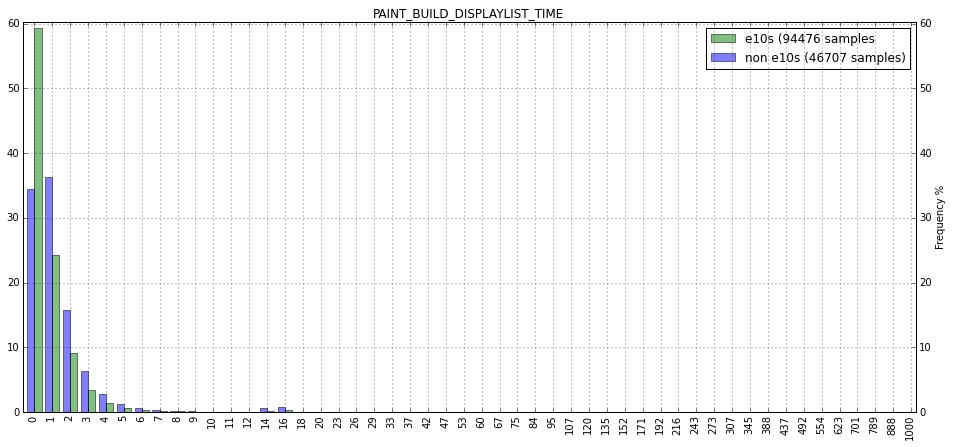

The chi2 distance for GC_MMU_50 is 0.0625826142778


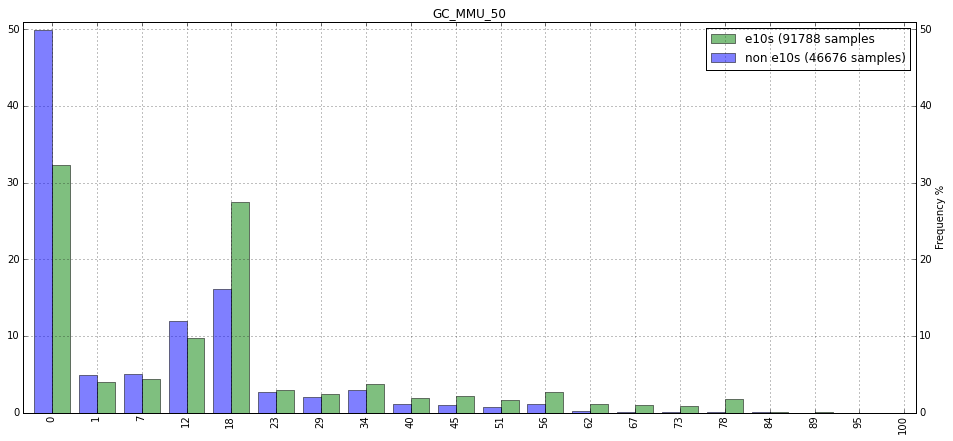

The chi2 distance for STARTUP_NETWORK_CACHE_METADATA_FIRST_READ_TIME_MS is 0.0574717373379


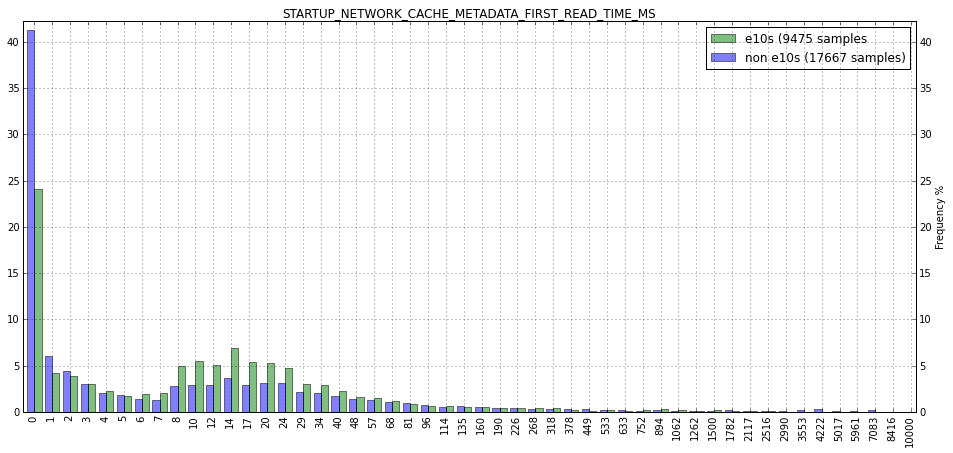

The chi2 distance for HTTP_PAGE_OPEN_TO_FIRST_RECEIVED is 0.0561506102572


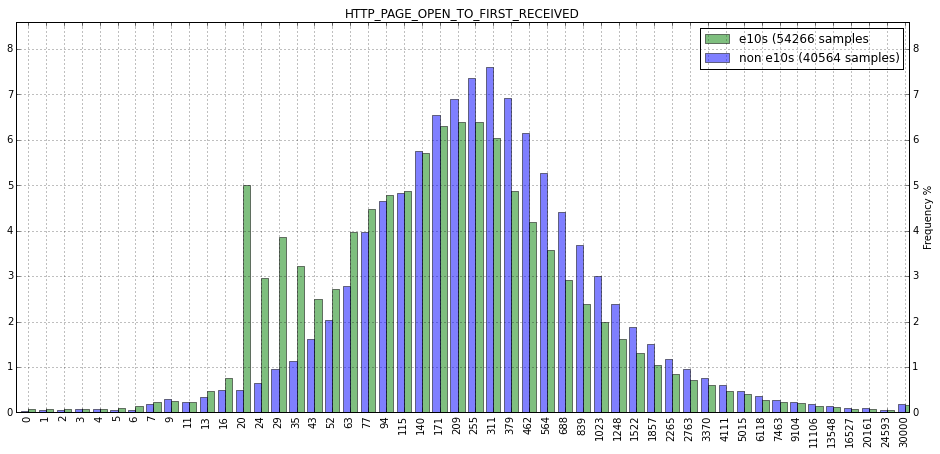

The chi2 distance for GC_MARK_GRAY_MS is 0.0558687633469


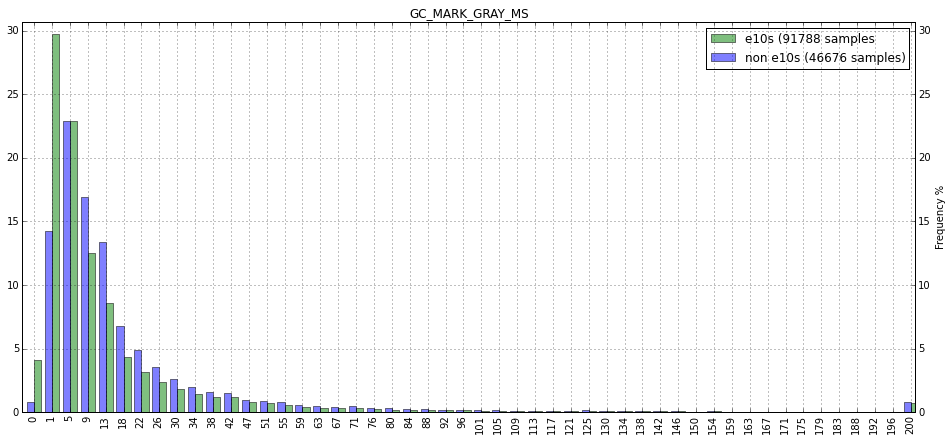

The chi2 distance for HTTP_PAGE_CACHE_READ_TIME_V2 is 0.0556775011536


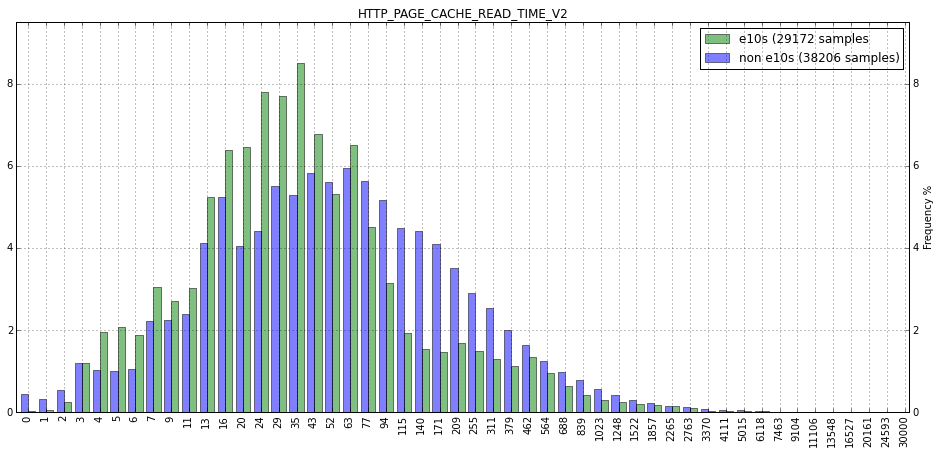

The chi2 distance for HTTP_PAGE_COMPLETE_LOAD_NET_V2 is 0.0537769884518


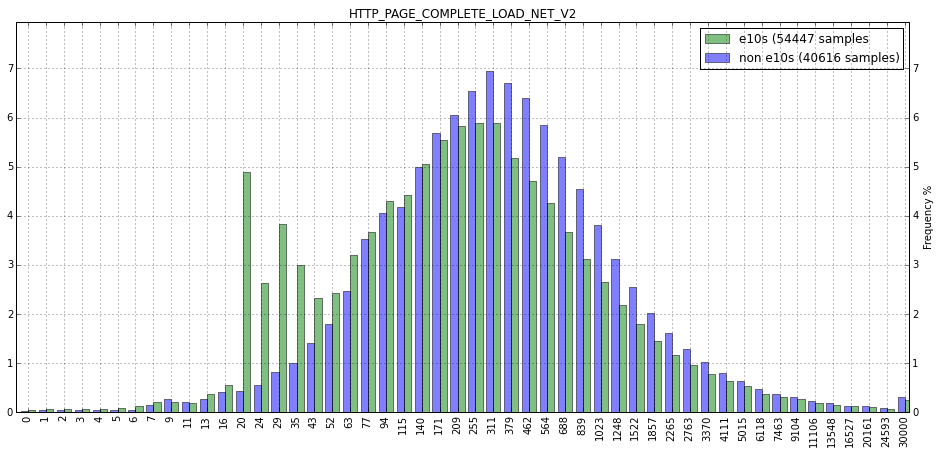

The chi2 distance for HTTP_PAGE_COMPLETE_LOAD_V2 is 0.0537769884518


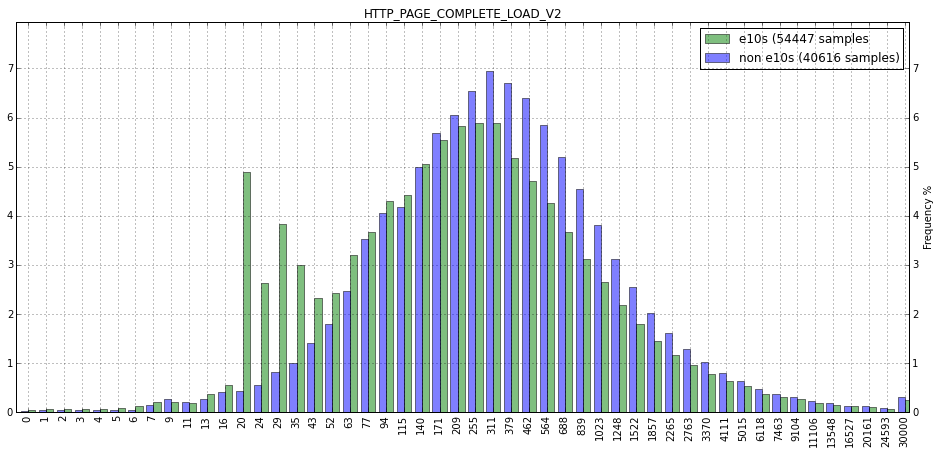

The chi2 distance for HTTP_SUB_COMPLETE_LOAD_CACHED_V2 is 0.0532042392865


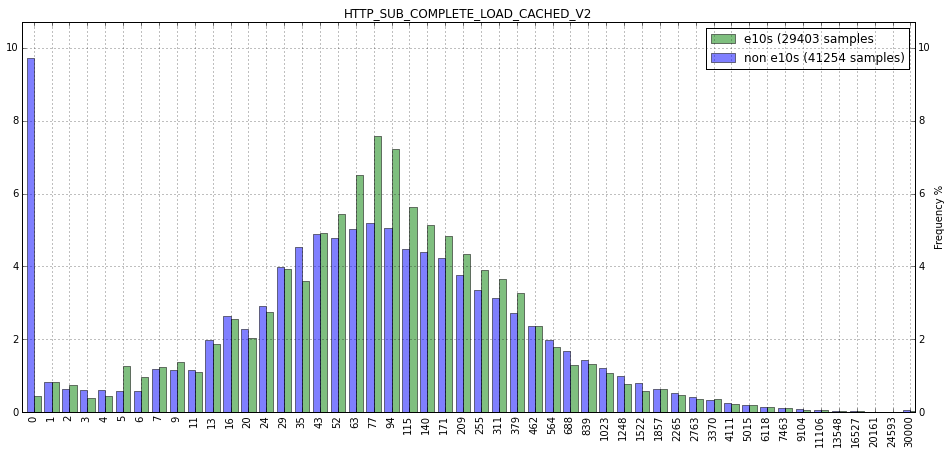

The chi2 distance for HTTP_SUB_COMPLETE_LOAD is 0.0531994496302


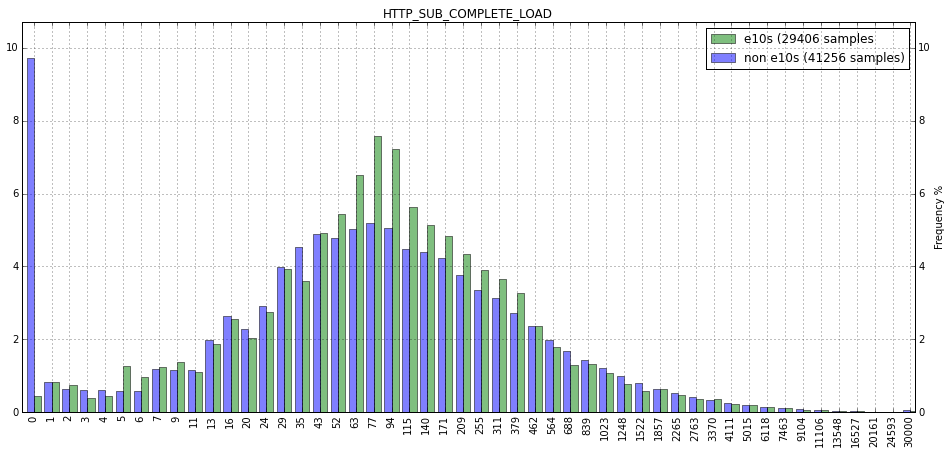

The chi2 distance for FX_SESSION_RESTORE_RESTORE_WINDOW_MS is 0.0522820019276


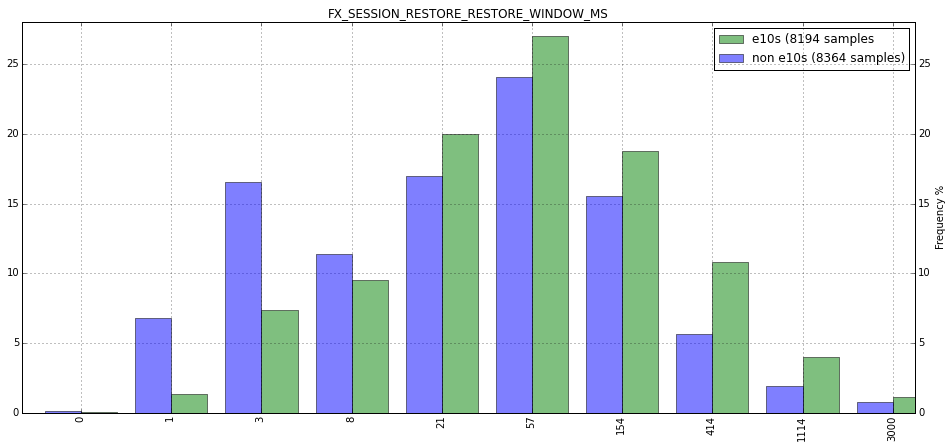

The chi2 distance for GC_MINOR_US is 0.0507366119155


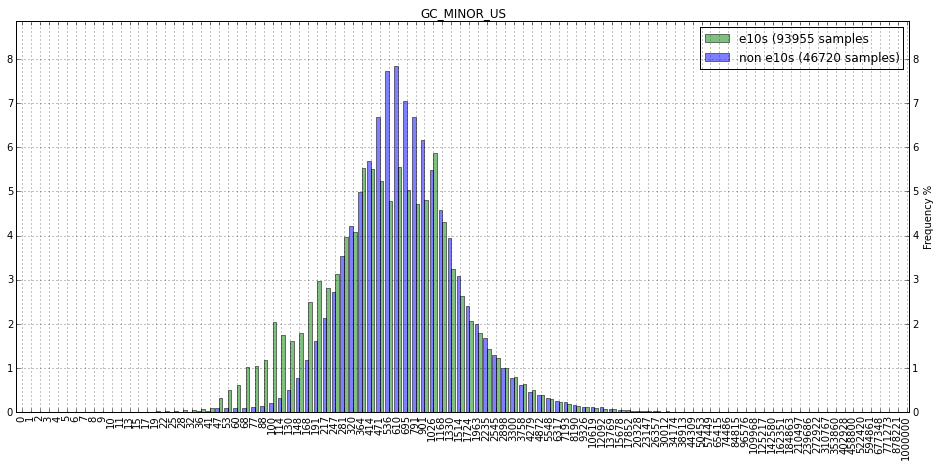

The chi2 distance for IMAGE_DECODE_ON_DRAW_LATENCY is 0.0487452849176


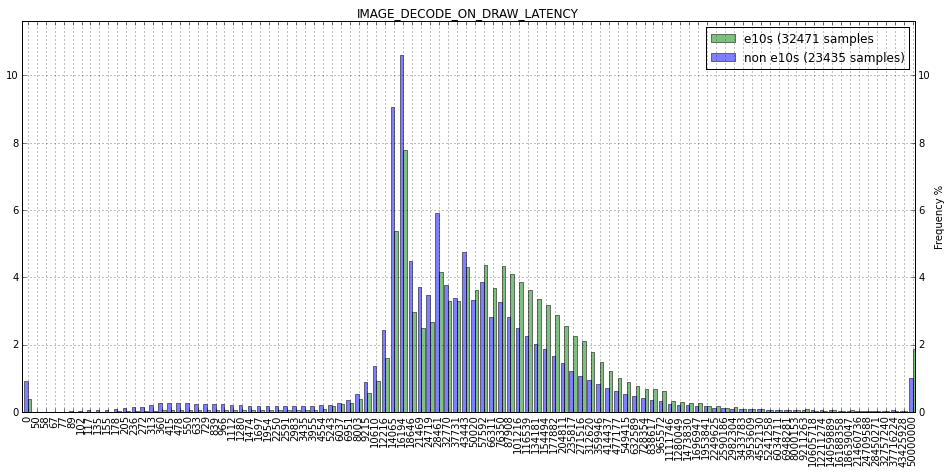

The chi2 distance for MEMORY_JS_MAIN_RUNTIME_TEMPORARY_PEAK is 0.0479780305835


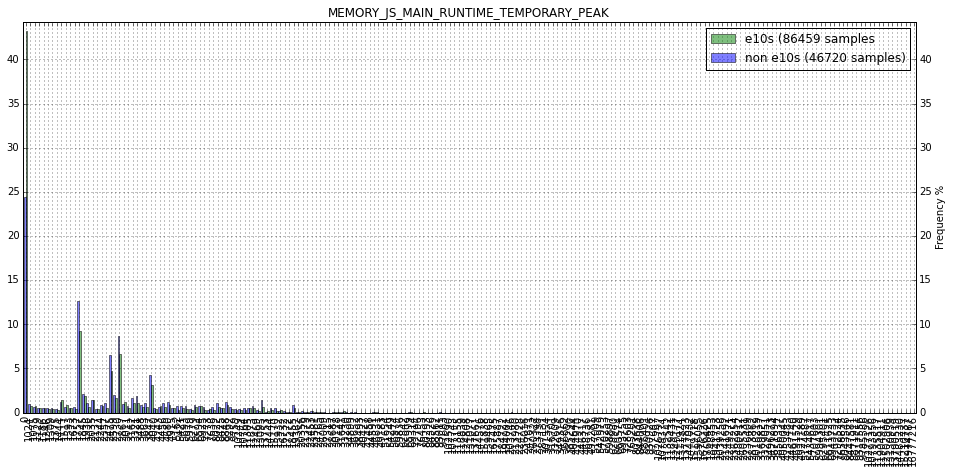

The chi2 distance for GC_SCC_SWEEP_TOTAL_MS is 0.0478845119518


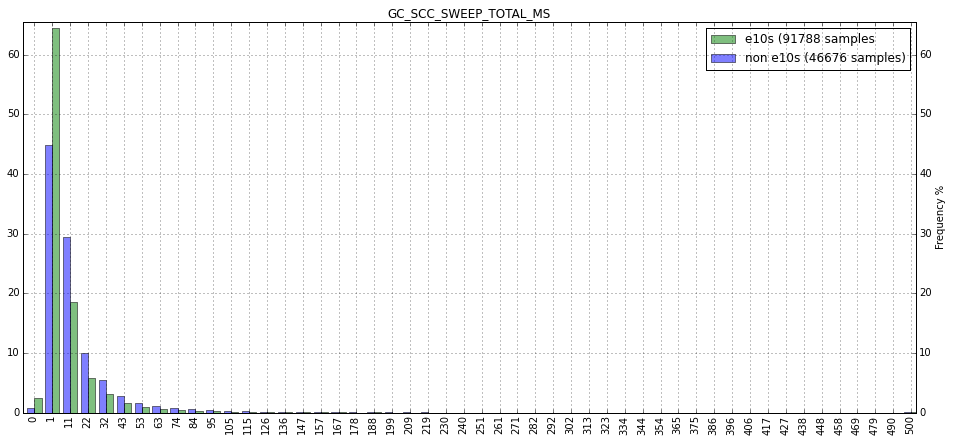

The chi2 distance for IMAGE_MAX_DECODE_COUNT is 0.04720688071


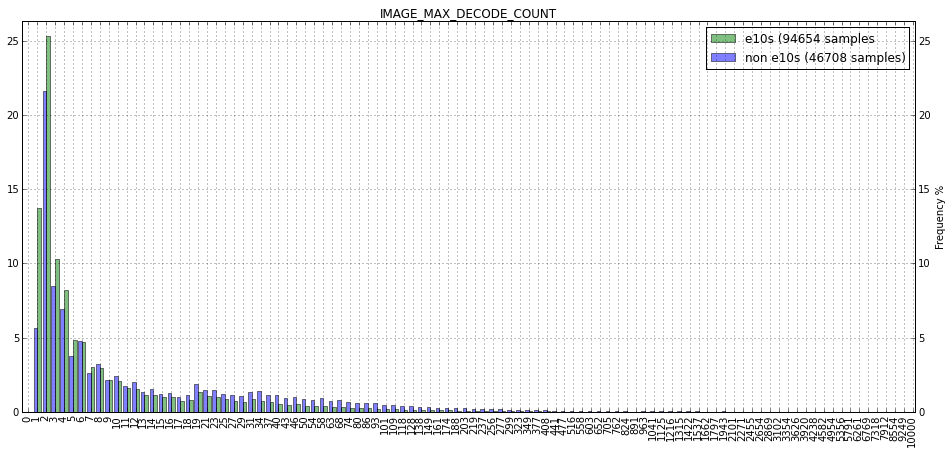

The chi2 distance for STARTUP_NETWORK_CACHE_V2_HIT_TIME_MS is 0.0422427257427


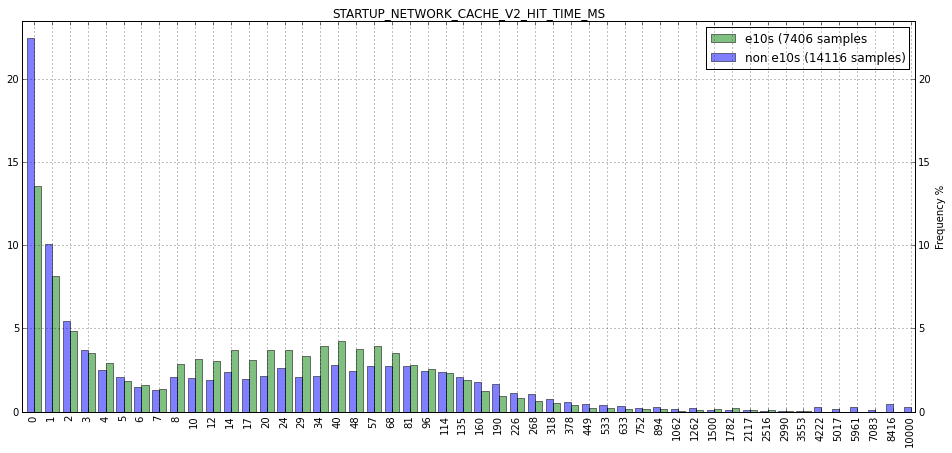

The chi2 distance for MEMORY_HEAP_COMMITTED_UNUSED_RATIO is 0.0419324047008


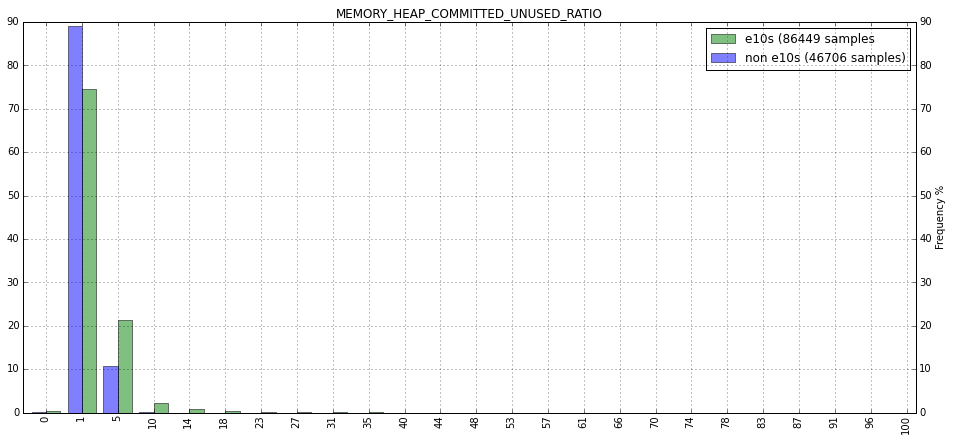

The chi2 distance for CYCLE_COLLECTOR_WORKER_VISITED_GCED is 0.0406800280053


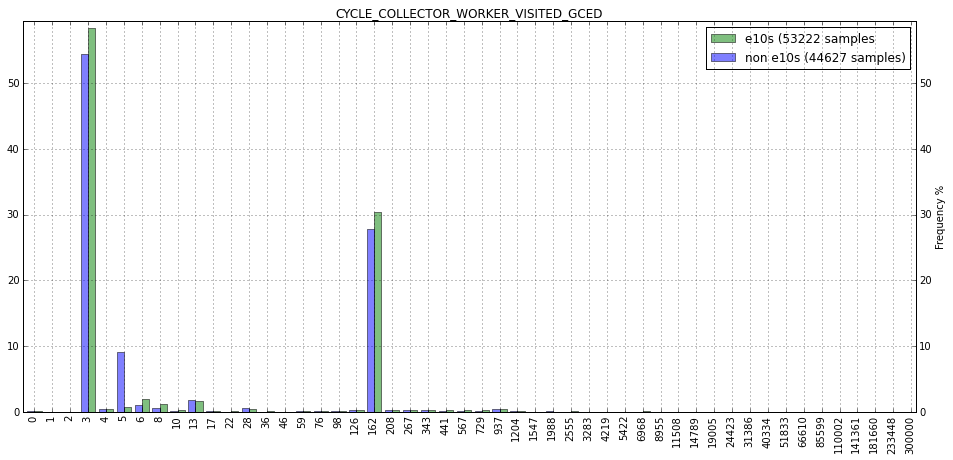

The chi2 distance for STARTUP_TRANSACTION_WAIT_TIME_HTTP is 0.039705391153


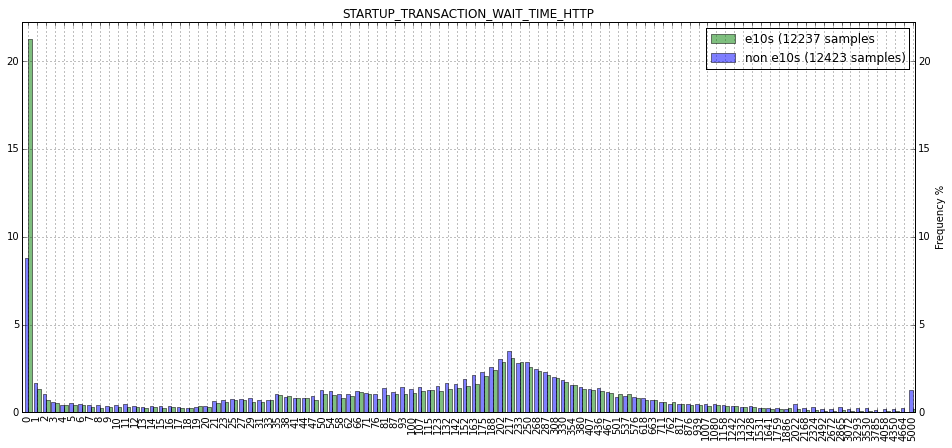

The chi2 distance for GC_MAX_PAUSE_MS is 0.0396586015428


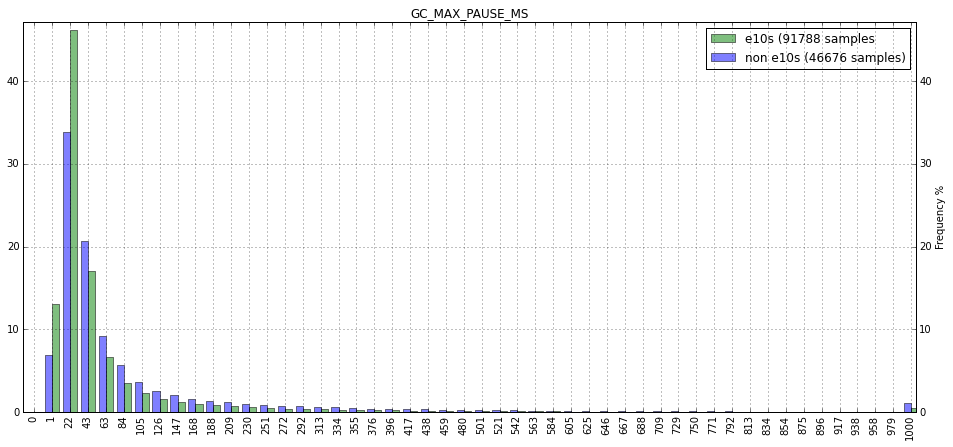

The chi2 distance for TELEMETRY_MEMORY_REPORTER_MS is 0.0391781852835


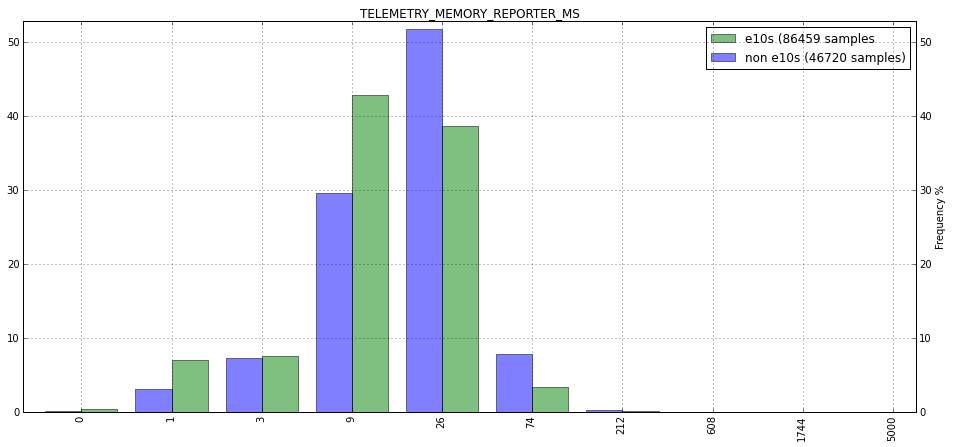

The chi2 distance for GC_REASON_2 is 0.0380277134368


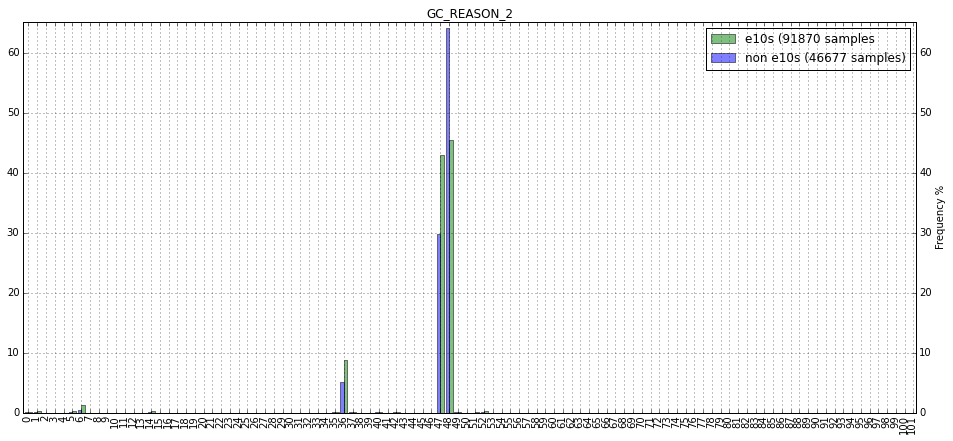

The chi2 distance for HTTP_SUB_OPEN_TO_FIRST_RECEIVED is 0.0375249491787


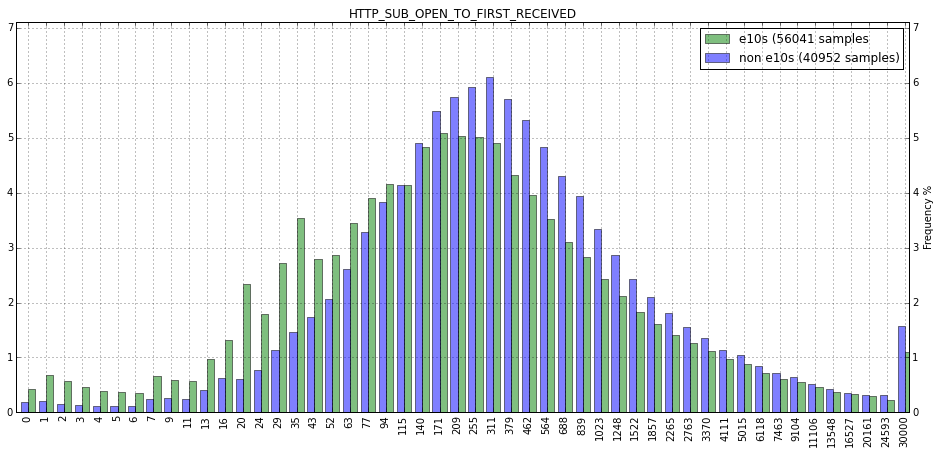

The chi2 distance for NETWORK_CACHE_V2_INPUT_STREAM_STATUS is 0.036955891932


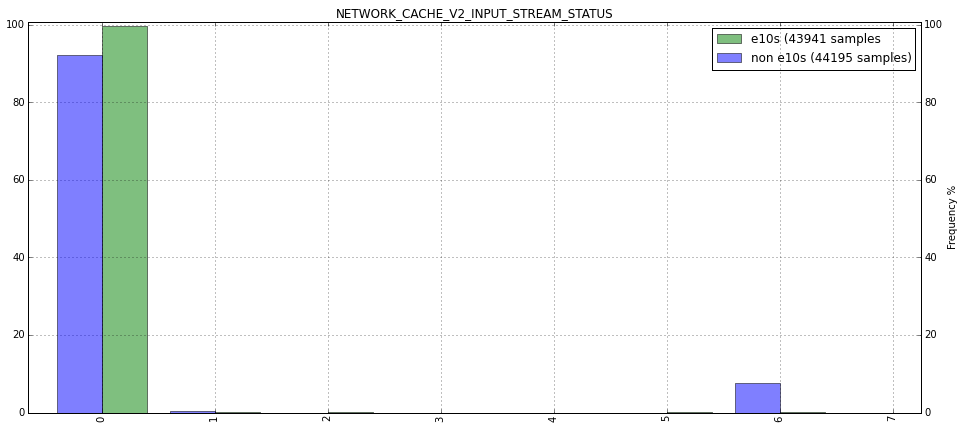

The chi2 distance for AUDIOSTREAM_LATER_OPEN_MS is 0.0364545587438


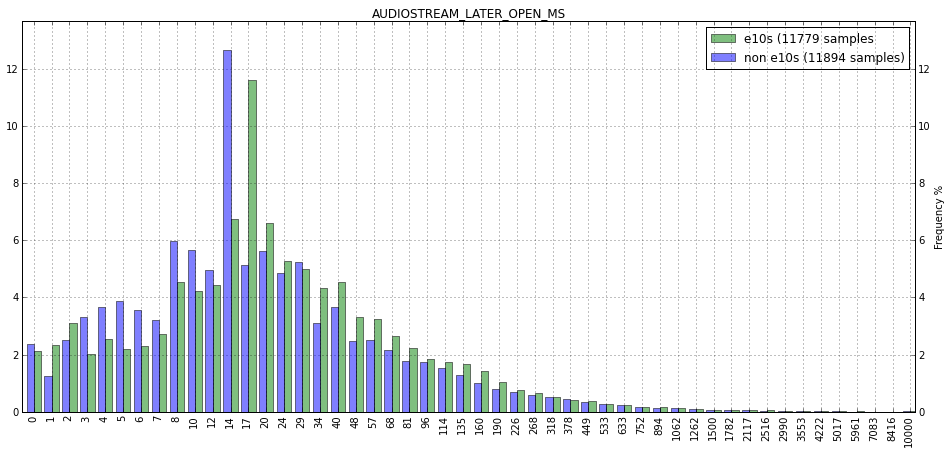

The chi2 distance for STARTUP_HTTP_PROXY_TYPE is 0.0363804652887


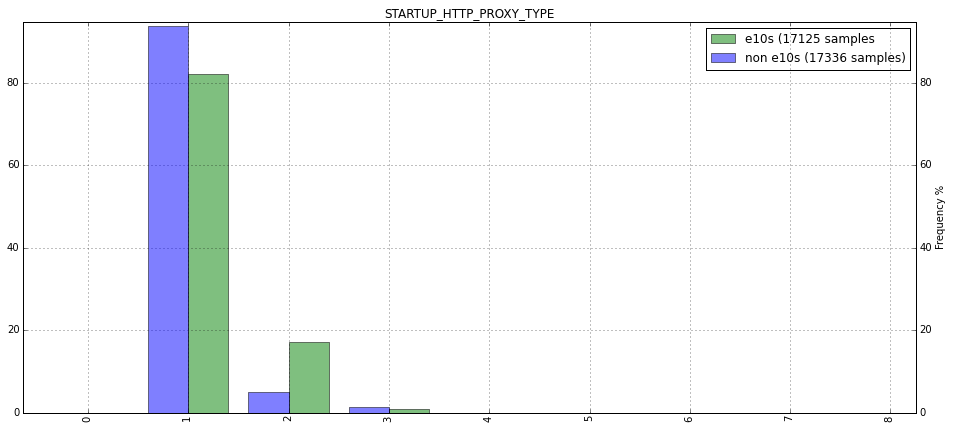

The chi2 distance for HTTP_SUB_COMPLETE_LOAD_V2 is 0.0357809573917


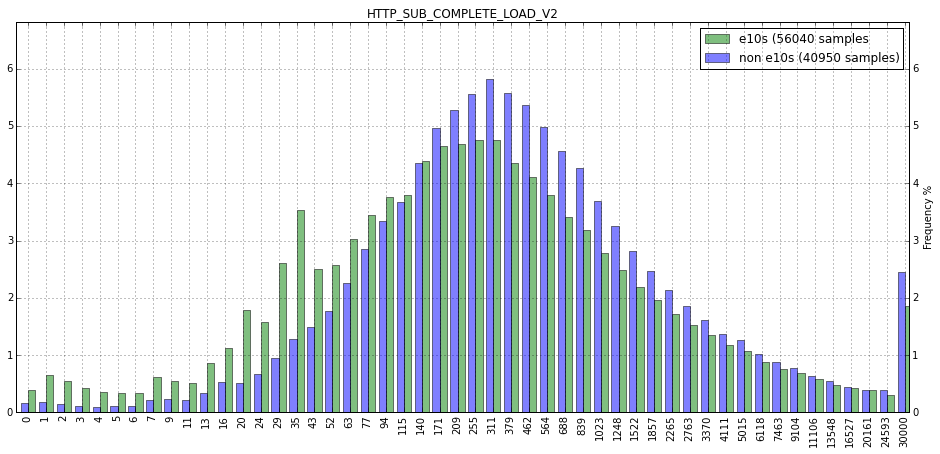

The chi2 distance for HTTP_SUB_COMPLETE_LOAD_NET_V2 is 0.0357809573917


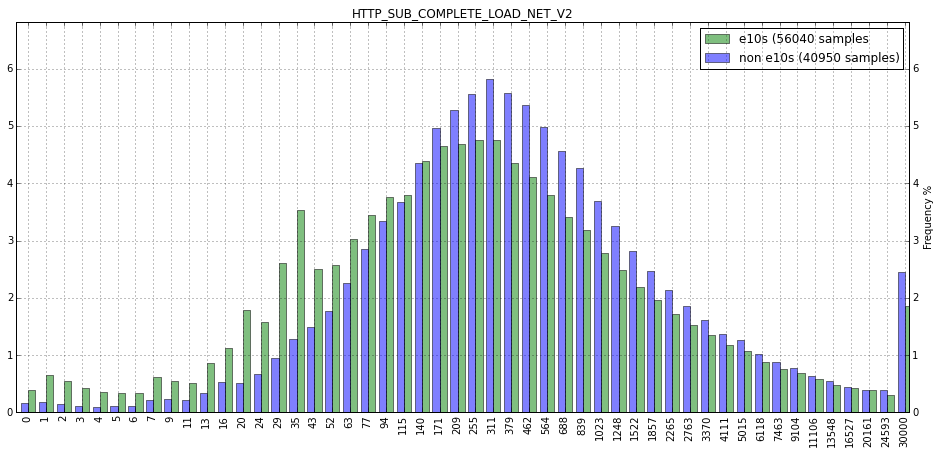

The chi2 distance for HTTP_CACHE_DISPOSITION_2_V2 is 0.0349426398267


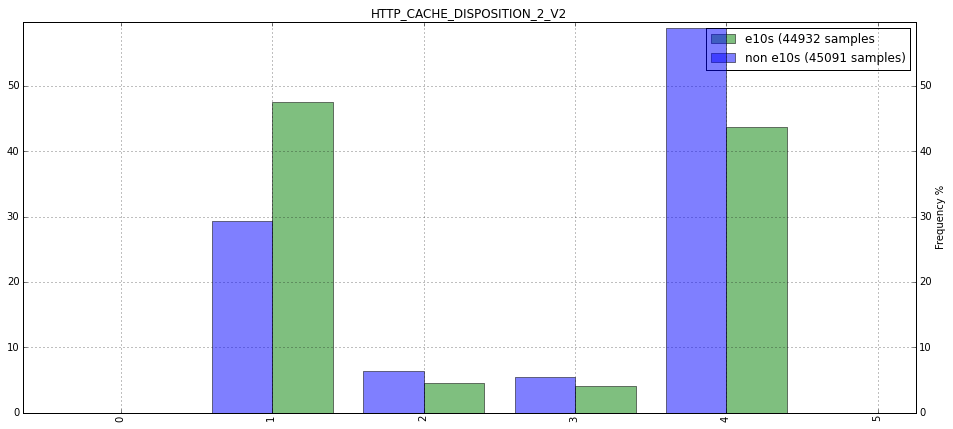

The chi2 distance for HTTP_SUB_CACHE_READ_TIME_V2 is 0.0340611467984


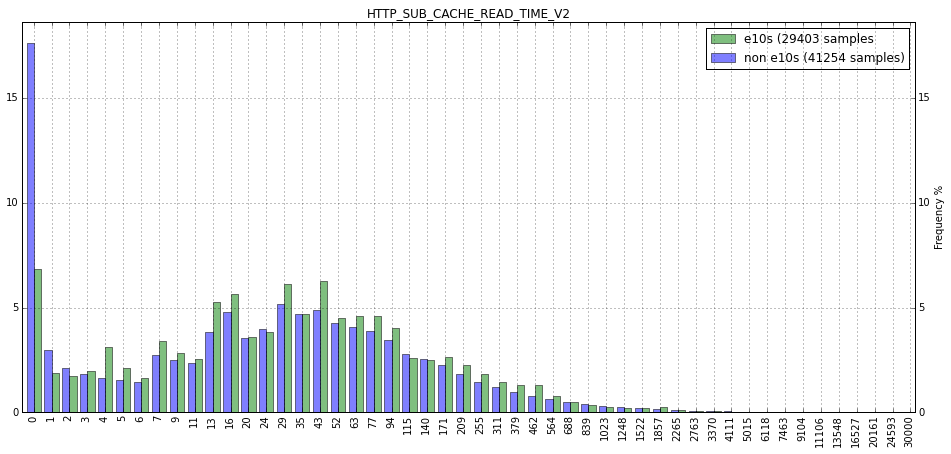

The chi2 distance for HTTP_PAGE_FIRST_SENT_TO_LAST_RECEIVED is 0.0331884755009


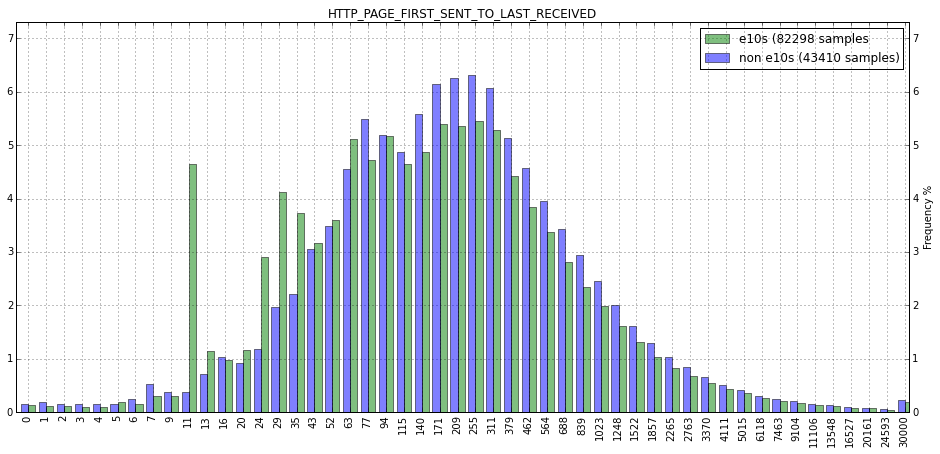

The chi2 distance for FX_TAB_ANIM_ANY_FRAME_INTERVAL_MS is 0.0331211909707


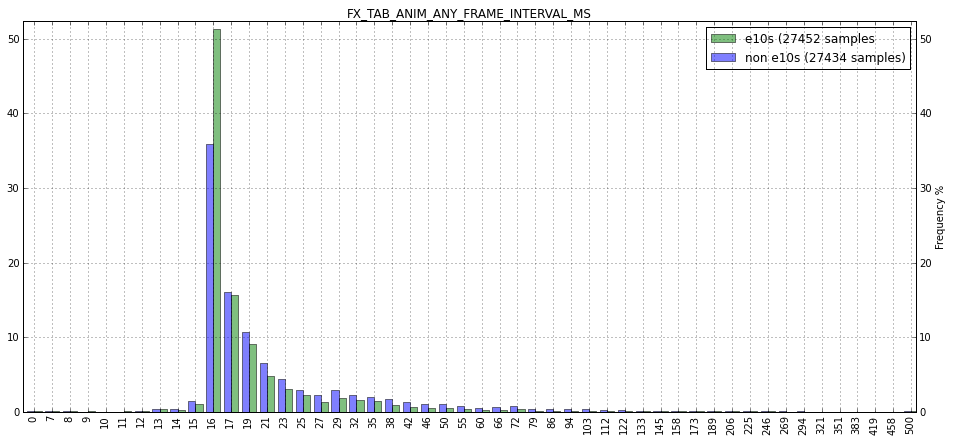

The chi2 distance for GC_SCC_SWEEP_MAX_PAUSE_MS is 0.0330396720417


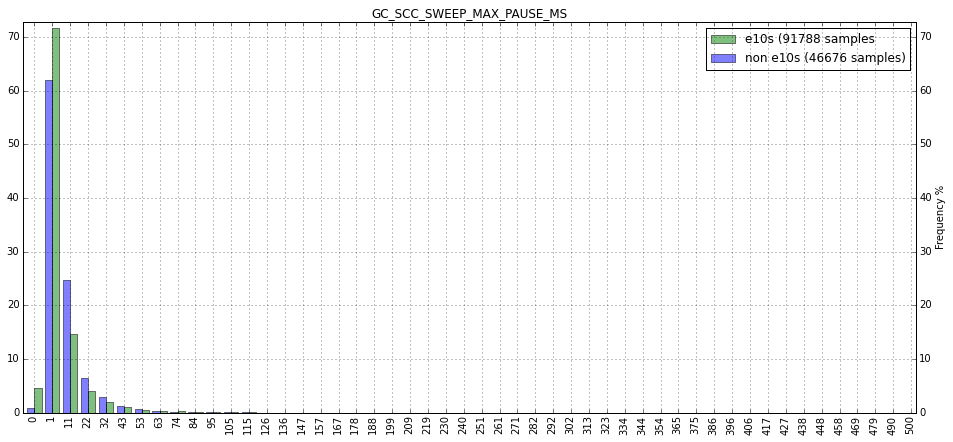

The chi2 distance for ADDON_SHIM_USAGE is 0.0305948033499


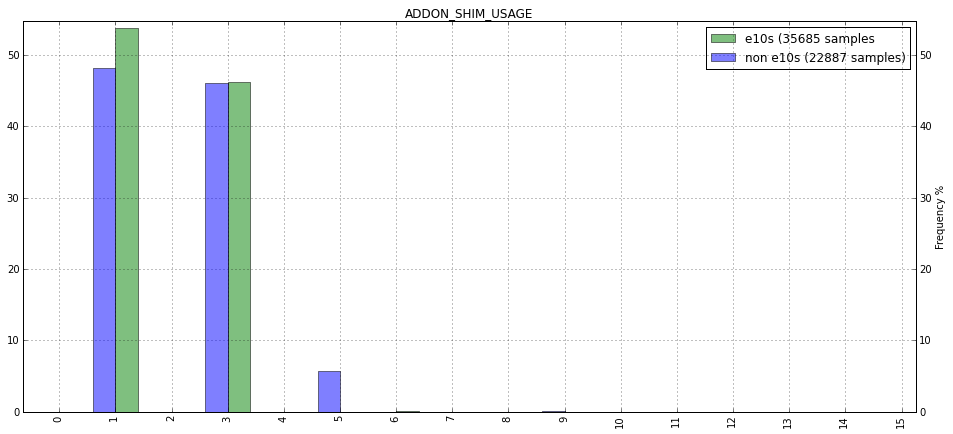

The chi2 distance for SYSTEM_FONT_FALLBACK_SCRIPT is 0.0289893088774


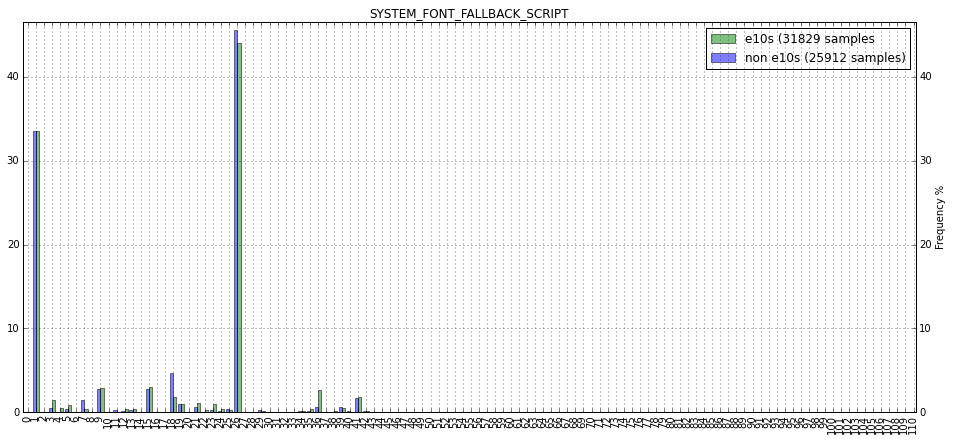

The chi2 distance for MEMORY_VSIZE_MAX_CONTIGUOUS is 0.0273857813963


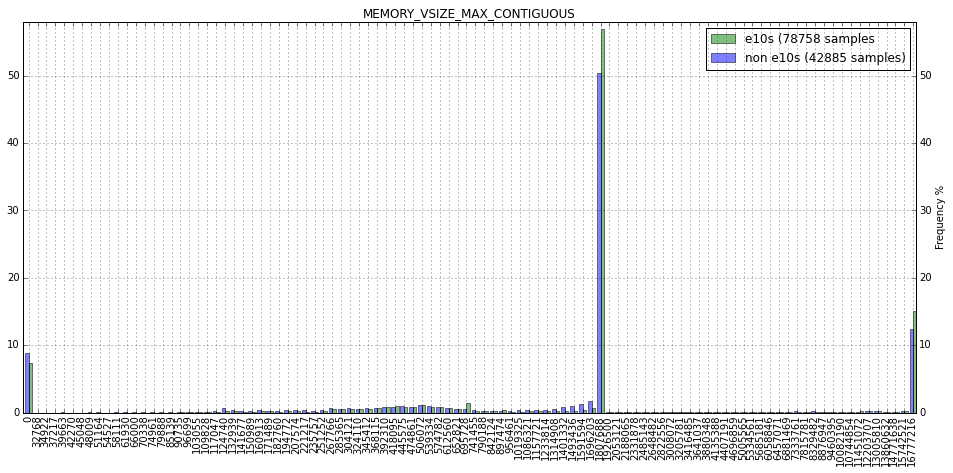

The chi2 distance for PAINT_RASTERIZE_TIME is 0.0271728514892


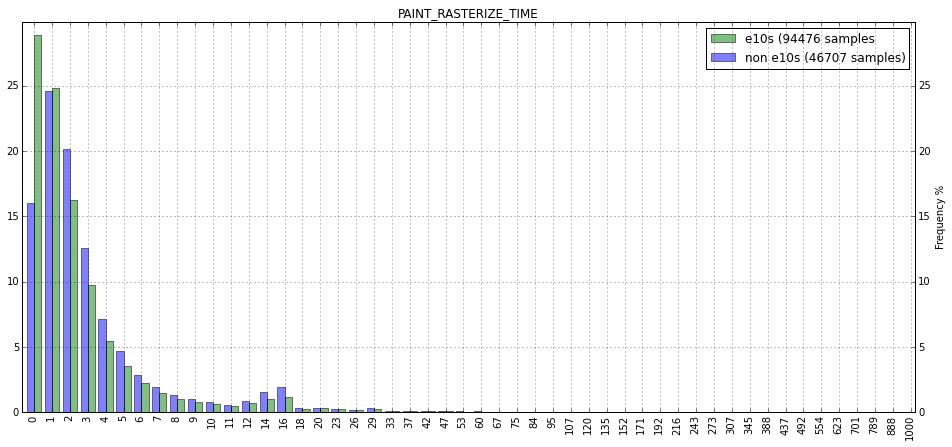

The chi2 distance for NETWORK_CACHE_HIT_RATE_PER_CACHE_SIZE is 0.0271114502071


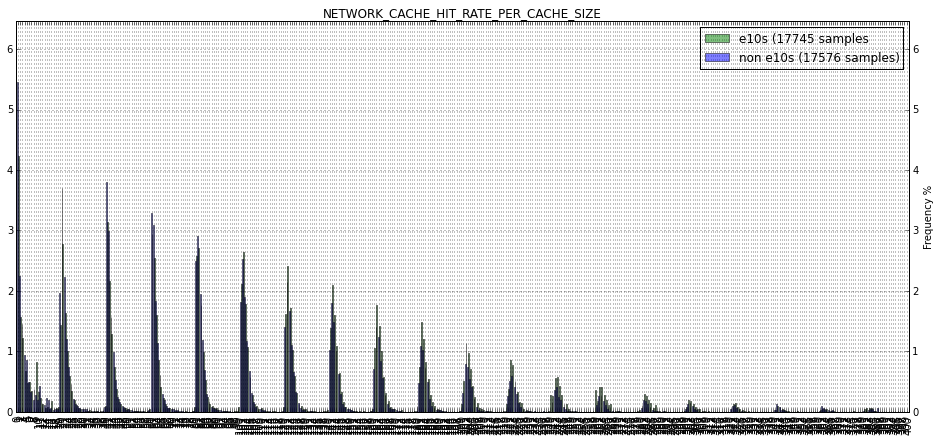

The chi2 distance for PLACES_FAVICON_PNG_SIZES is 0.0260818772649


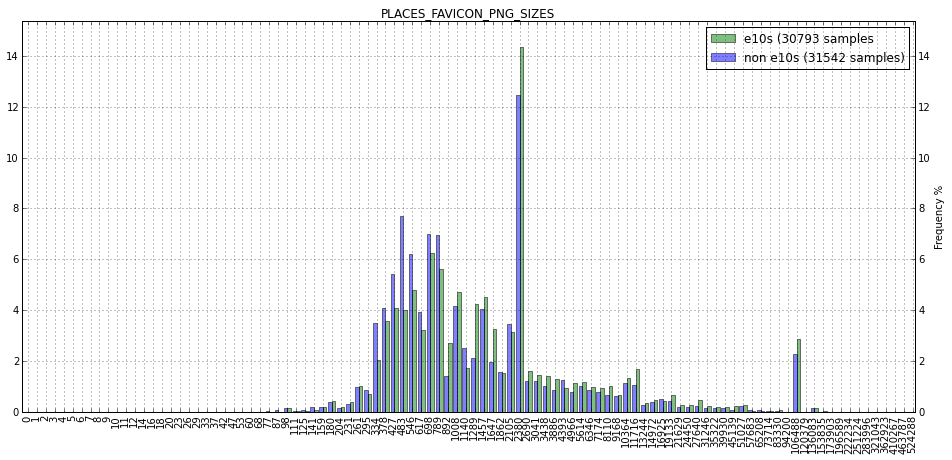

The chi2 distance for SYSTEM_FONT_FALLBACK is 0.0259812233


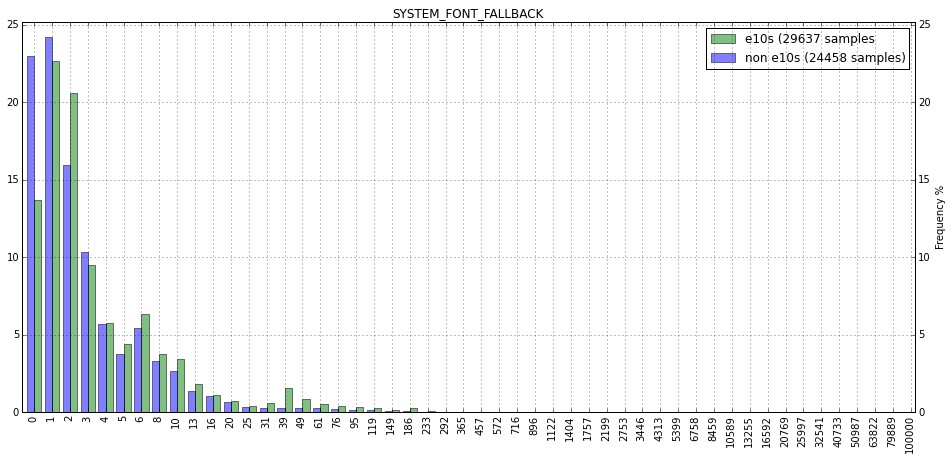

The chi2 distance for GC_SLICE_MS is 0.0256487364528


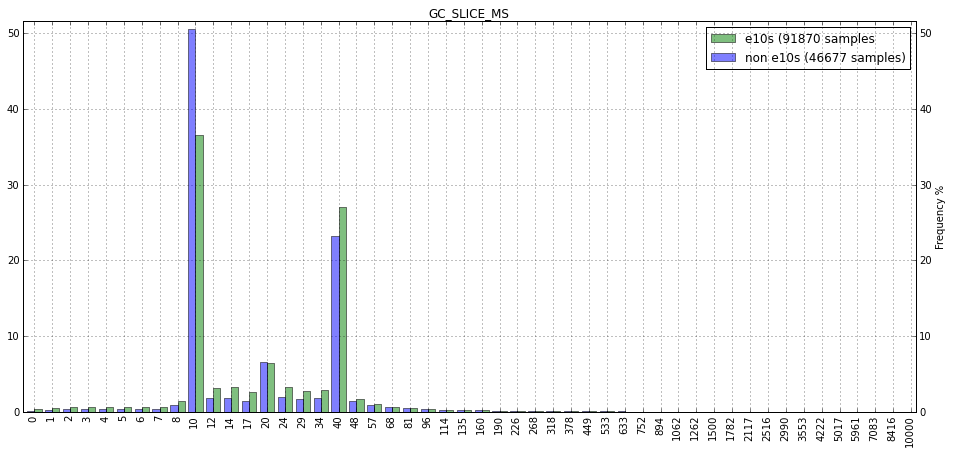

The chi2 distance for HTTP_REQUEST_PER_PAGE is 0.0255099805791


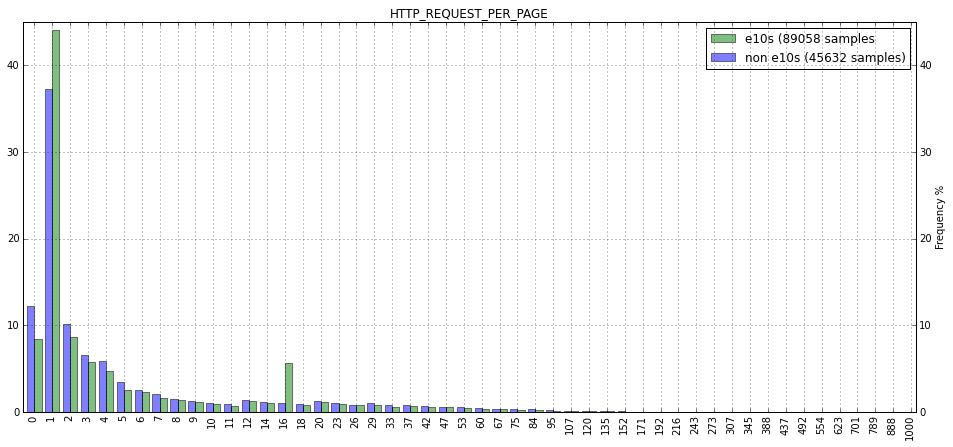

The chi2 distance for WEBSOCKETS_HANDSHAKE_TYPE is 0.0246291716615


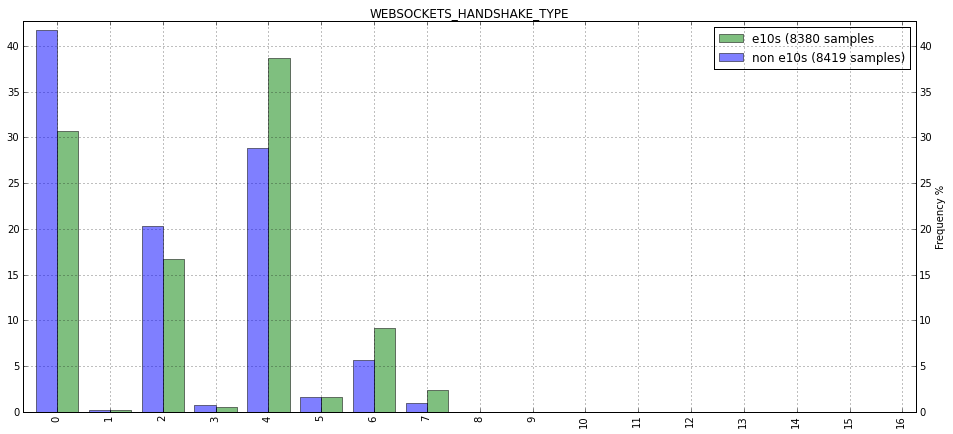

The chi2 distance for AUDIOSTREAM_FIRST_OPEN_MS is 0.0233834389898


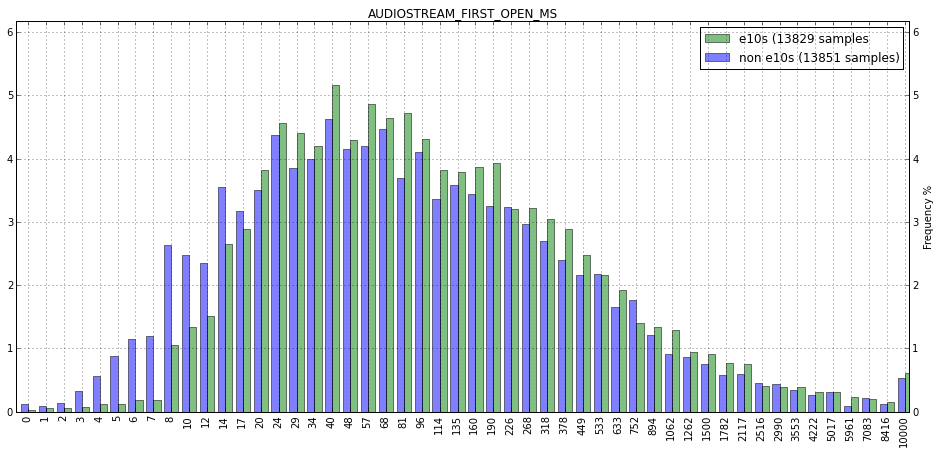

The chi2 distance for STARTUP_DNS_LOOKUP_METHOD2 is 0.0219637400081


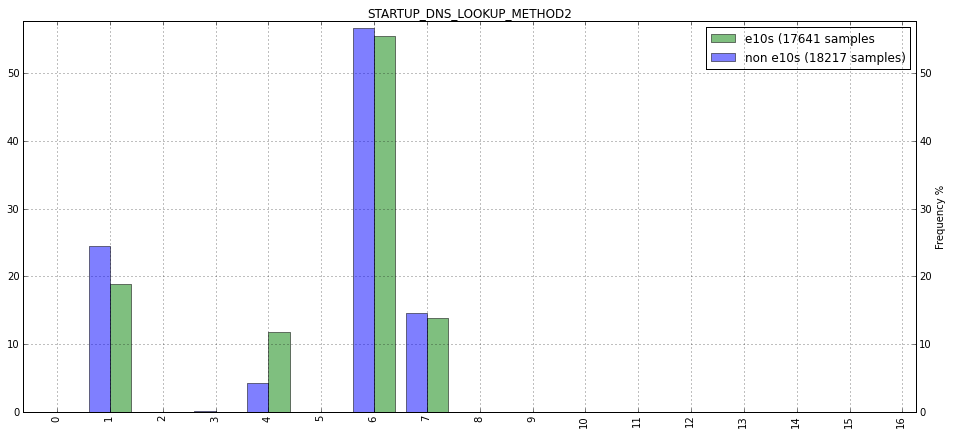

The chi2 distance for CYCLE_COLLECTOR_COLLECTED is 0.0201940890815


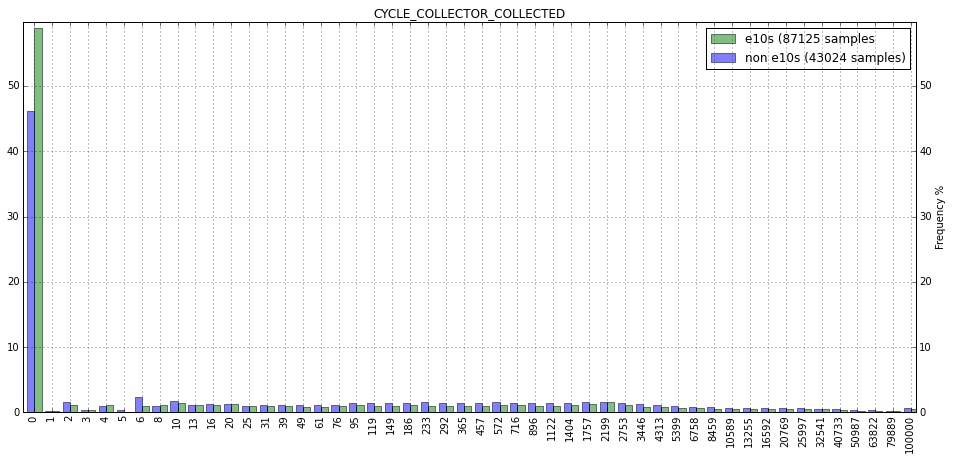

The chi2 distance for STARTUP_HTTP_TRANSACTION_IS_SSL is 0.0200207293514


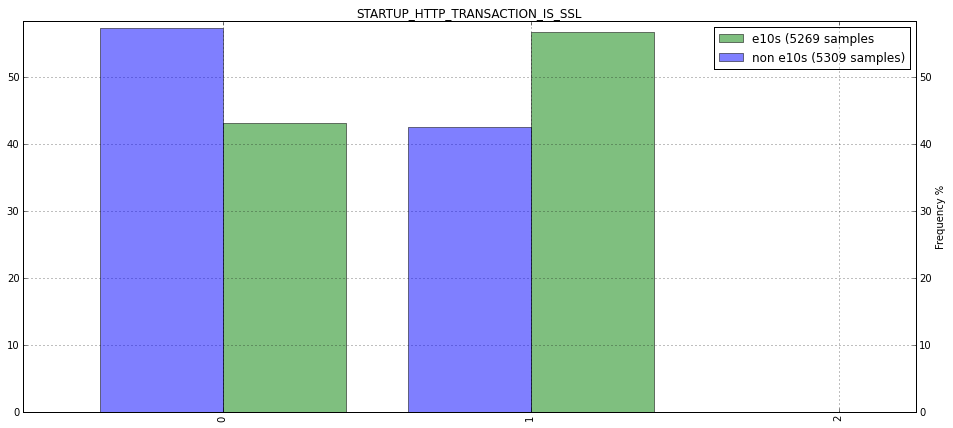

The chi2 distance for GC_BUDGET_MS is 0.018800055565


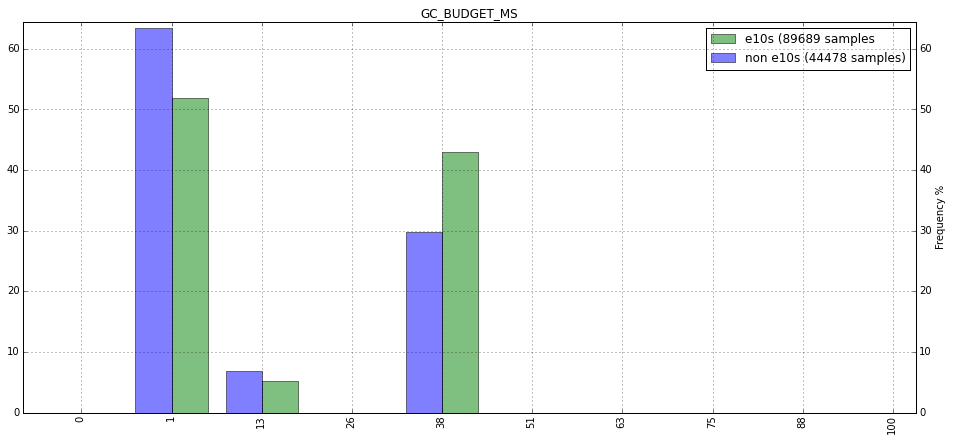

The chi2 distance for HTTP_SUBITEM_OPEN_LATENCY_TIME is 0.0184814565289


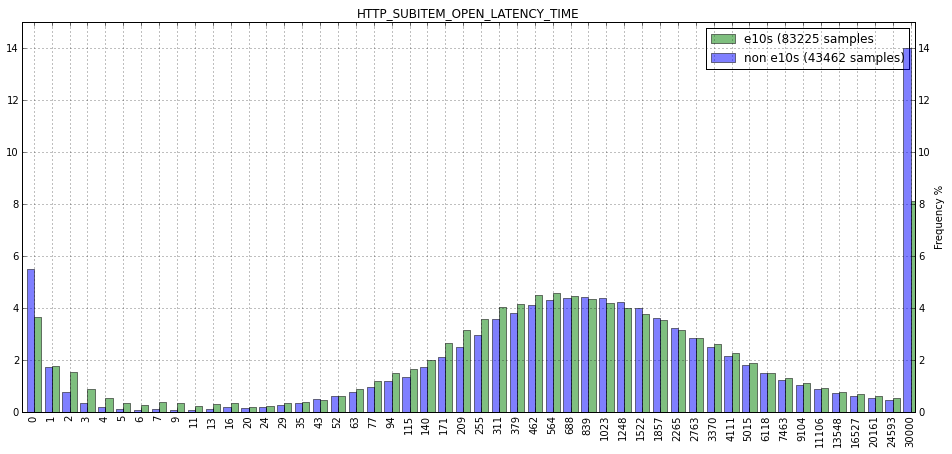

The chi2 distance for TOTAL_CONTENT_PAGE_LOAD_TIME is 0.0179815985251


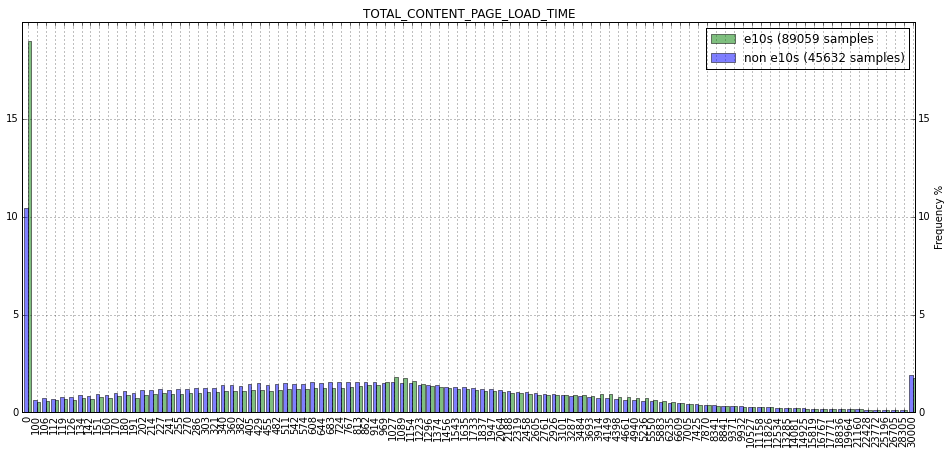

The chi2 distance for HEALTHREPORT_POST_COLLECT_CHECKPOINT_MS is 0.0175205358104


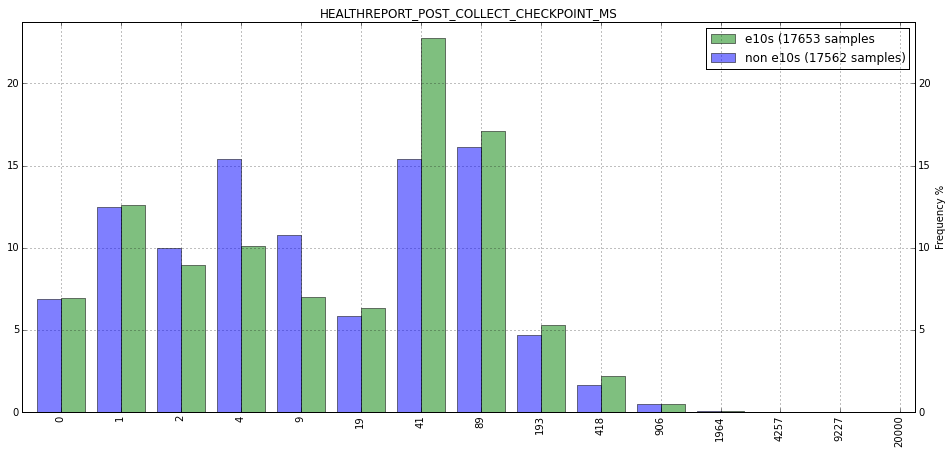

The chi2 distance for GC_ANIMATION_MS is 0.0168299161317


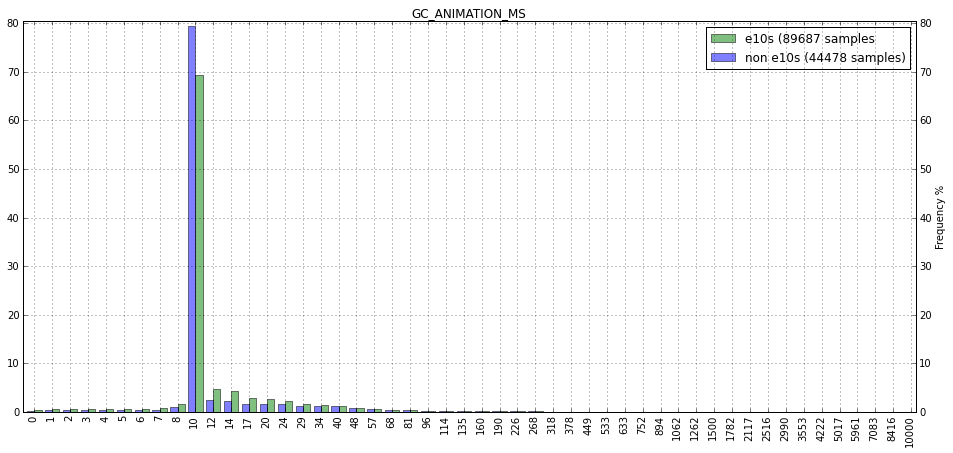

The chi2 distance for STARTUP_DNS_RENEWAL_TIME_FOR_TTL is 0.0167890233159


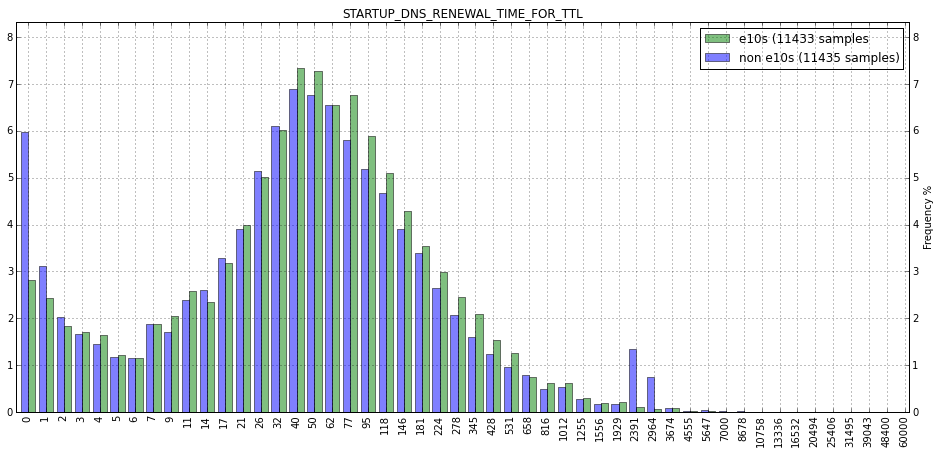

The chi2 distance for PWMGR_LOGIN_LAST_USED_DAYS is 0.0163923001385


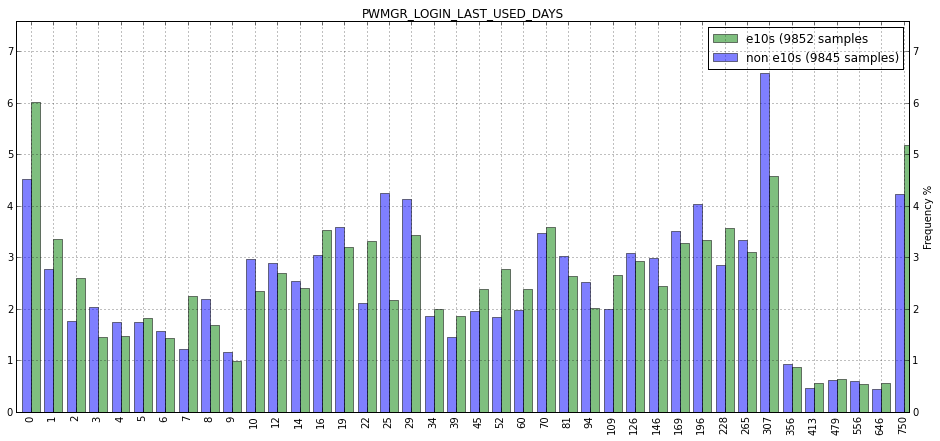

The chi2 distance for FORGET_SKIPPABLE_MAX is 0.0161091961063


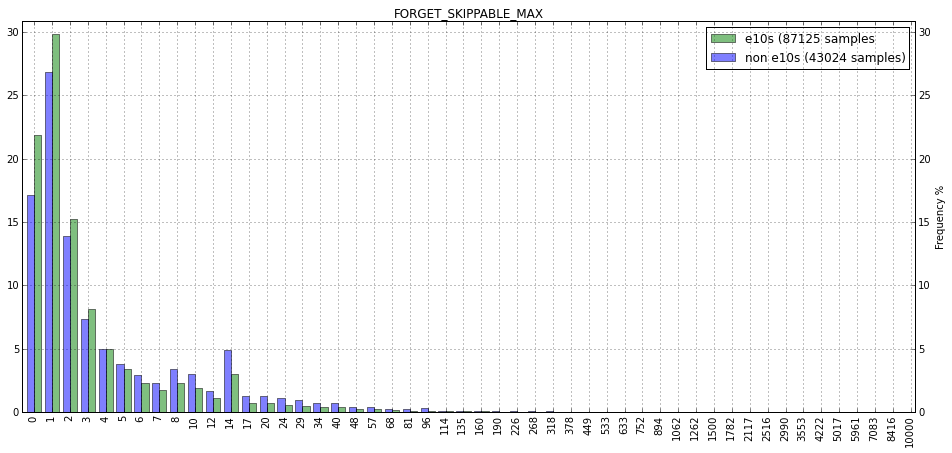

The chi2 distance for [[COUNT]]_CONTENT_DOCUMENTS_DESTROYED is 0.0154262168208


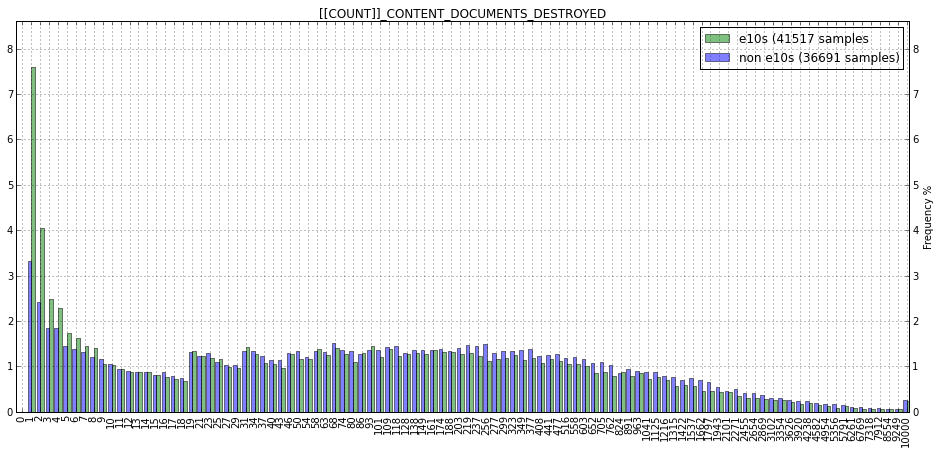

The chi2 distance for MOZ_SQLITE_OTHER_READ_B is 0.0153354350528


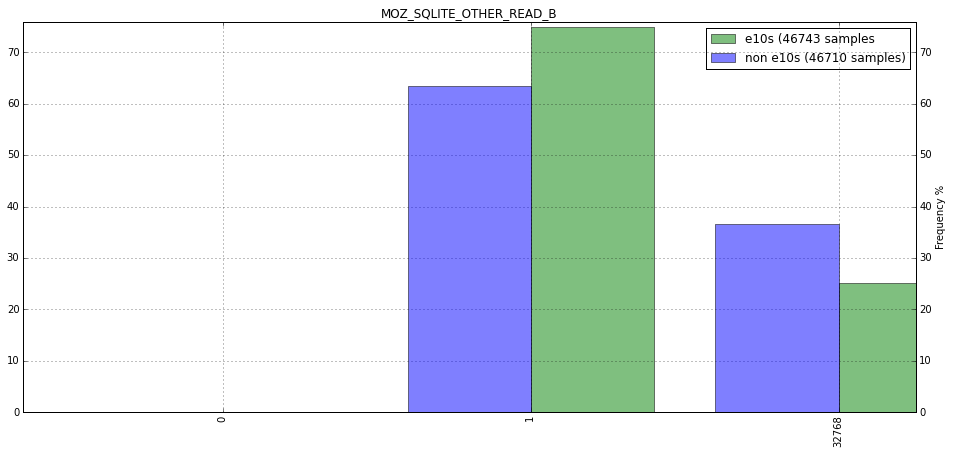

The chi2 distance for PREDICTOR_PREDICT_TIME_TO_INACTION is 0.0152587775133


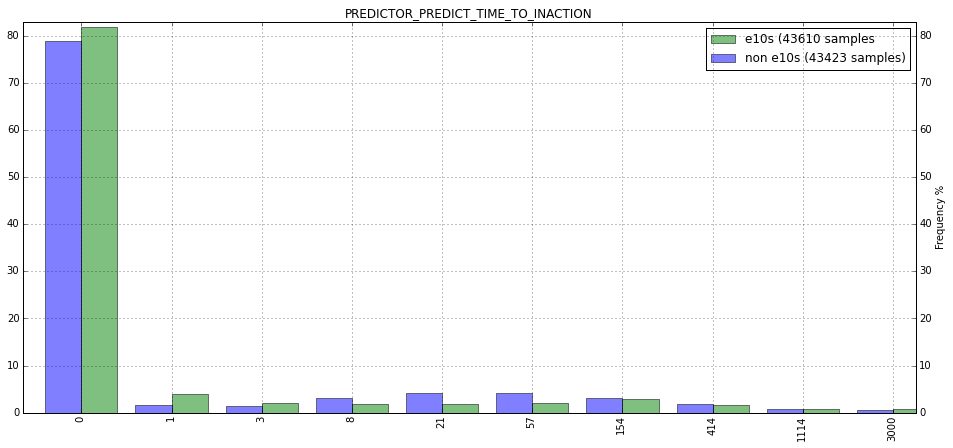

The chi2 distance for HTTP_PAGE_REVALIDATION is 0.0151506010013


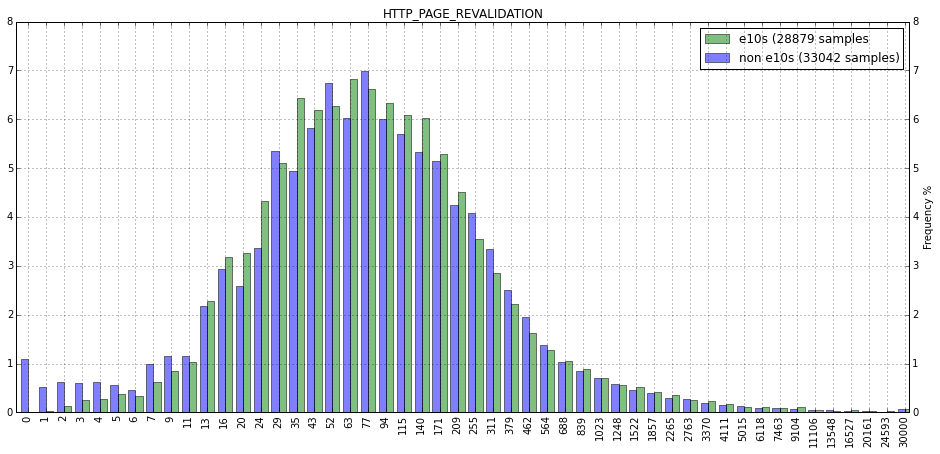

The chi2 distance for PREDICTOR_PREDICT_TIME_TO_ACTION is 0.0151280581779


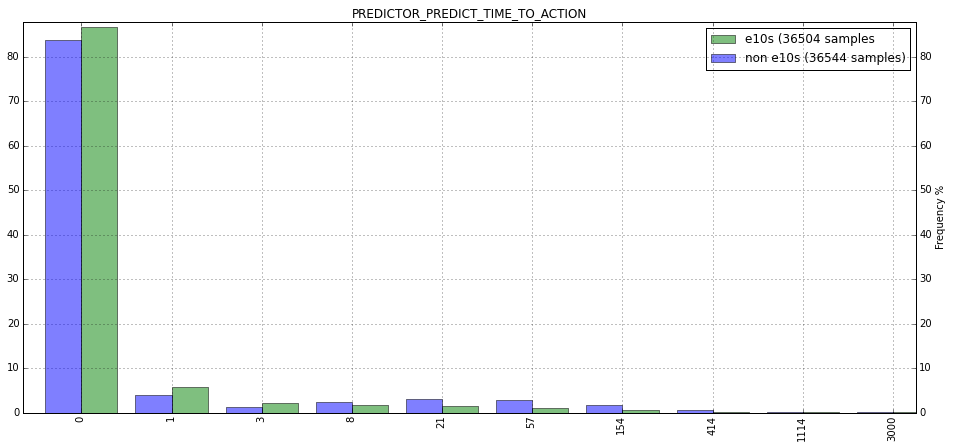

The chi2 distance for MEMORY_IMAGES_CONTENT_USED_UNCOMPRESSED is 0.0148663554299


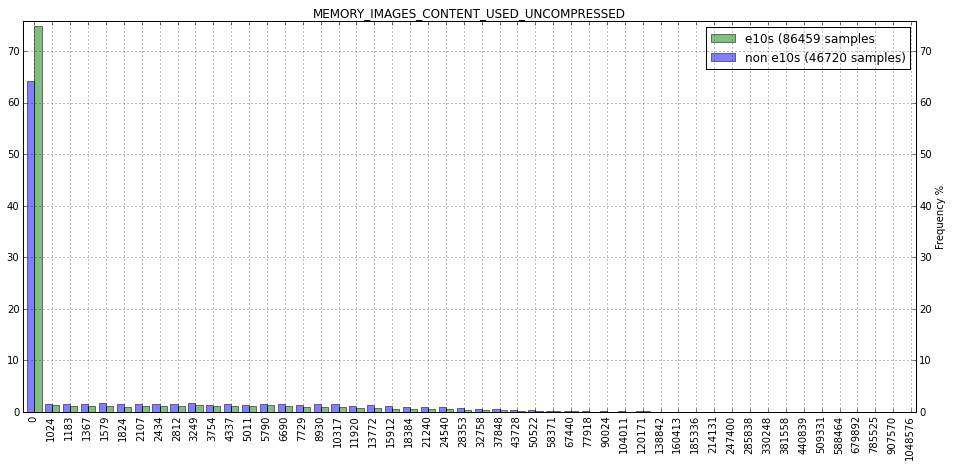

The chi2 distance for CACHE_SERVICE_LOCK_WAIT_2 is 0.0148281710657


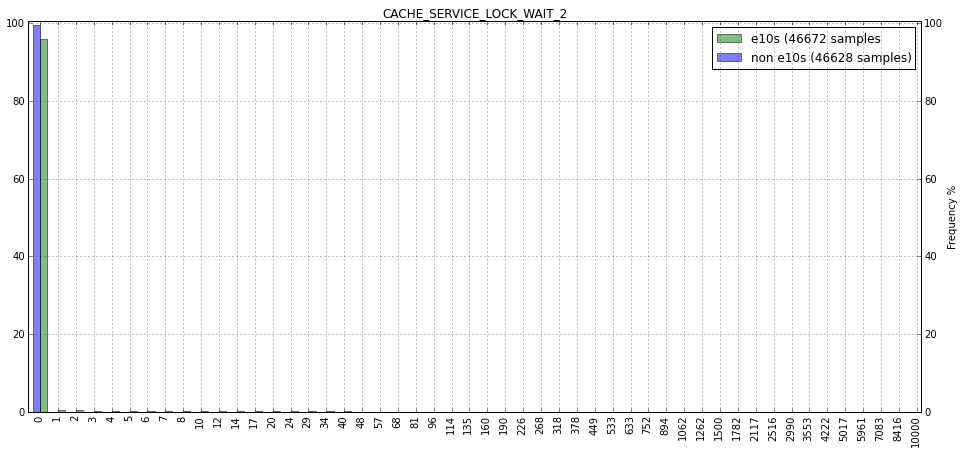

The chi2 distance for NEWTAB_PAGE_LIFE_SPAN is 0.0142530056079


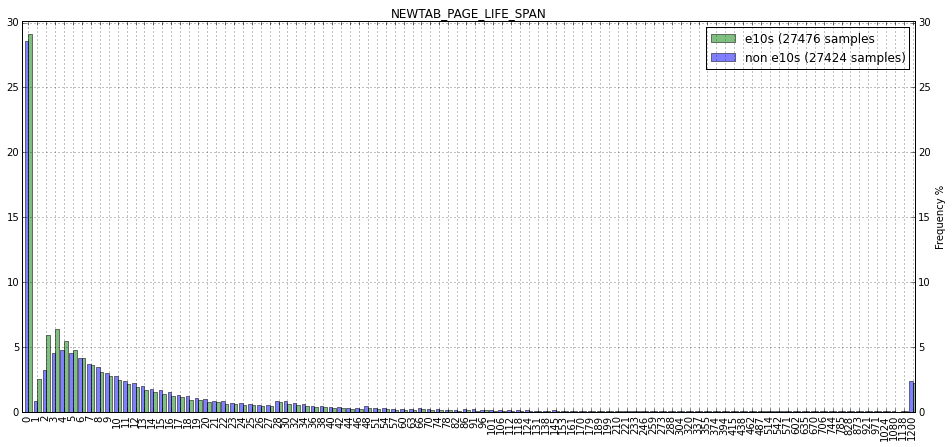

The chi2 distance for FXA_CONFIGURED is 0.0134285189363


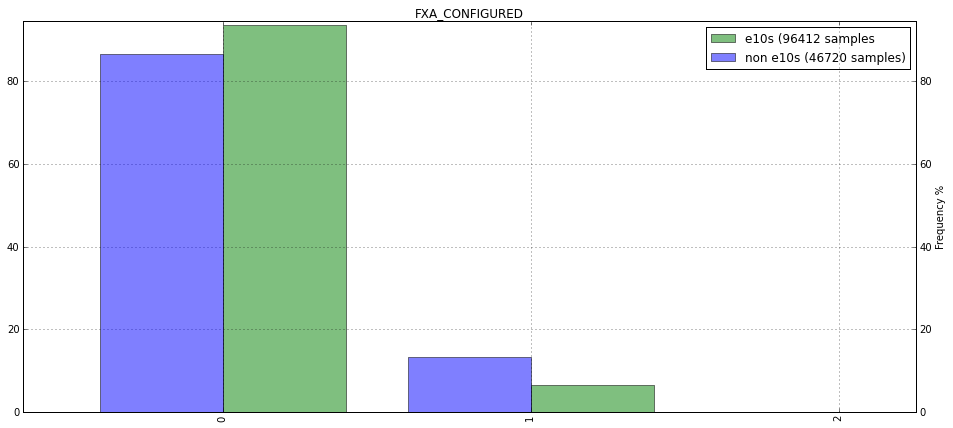

The chi2 distance for STARTUP_NETWORK_CACHE_HIT_MISS_STAT_PER_CACHE_SIZE is 0.0130178408013


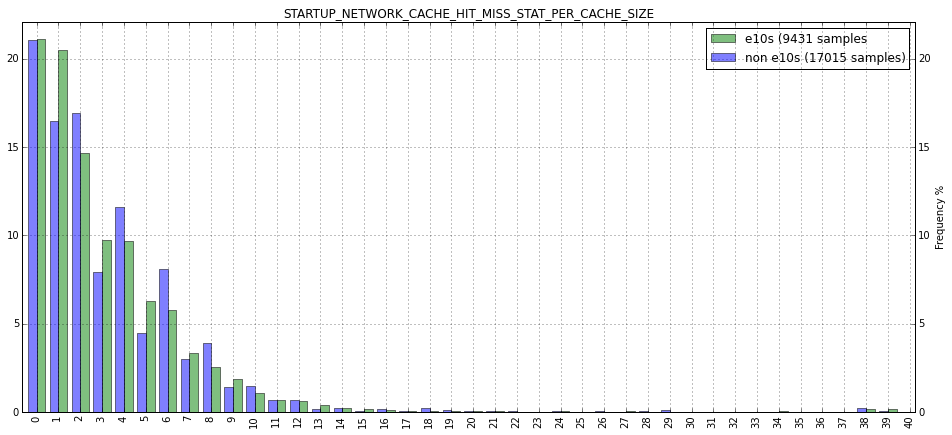

The chi2 distance for PREDICTOR_PREDICT_WORK_TIME is 0.0124926054298


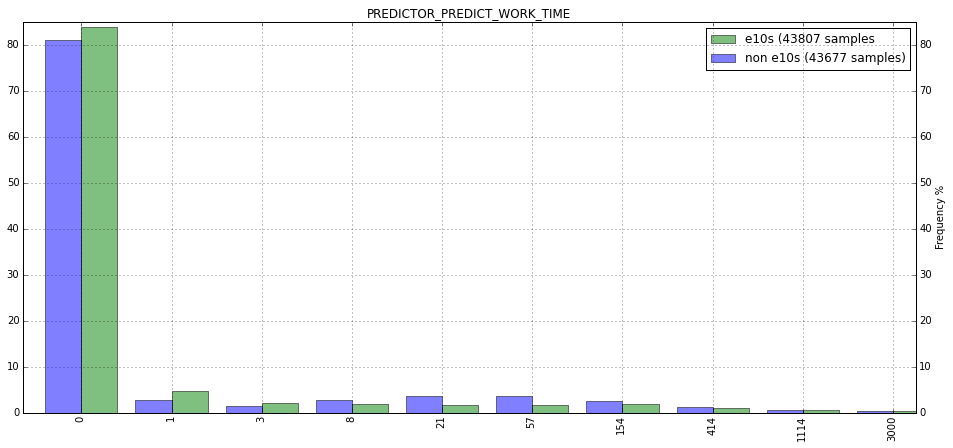

The chi2 distance for HTTP_SUB_OPEN_TO_FIRST_FROM_CACHE_V2 is 0.0120463054244


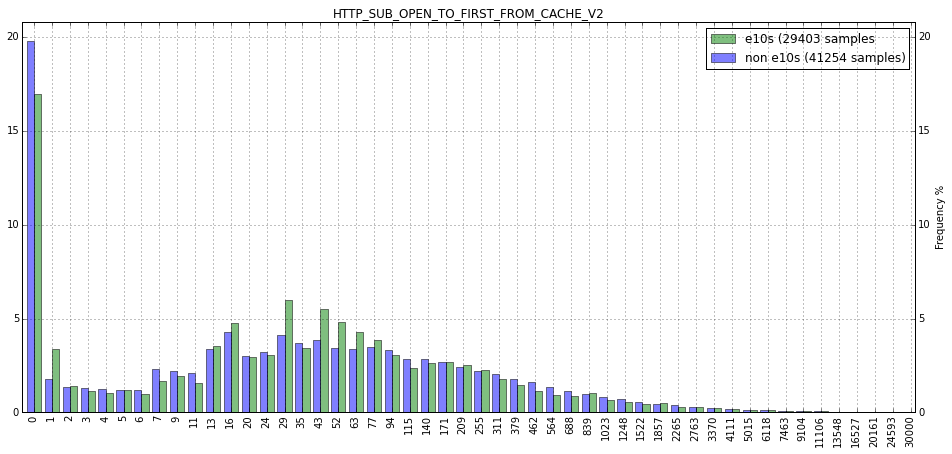

The chi2 distance for GC_SLOW_PHASE is 0.0120128801741


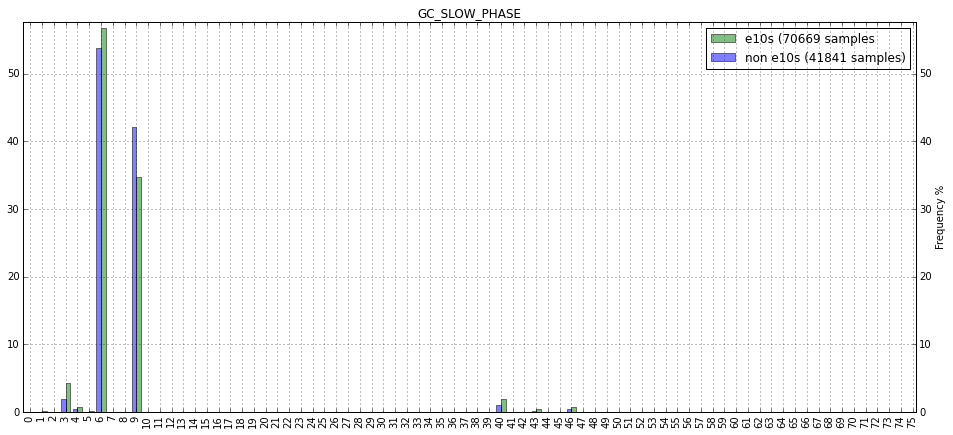

The chi2 distance for MEMORY_STORAGE_SQLITE is 0.0119750895442


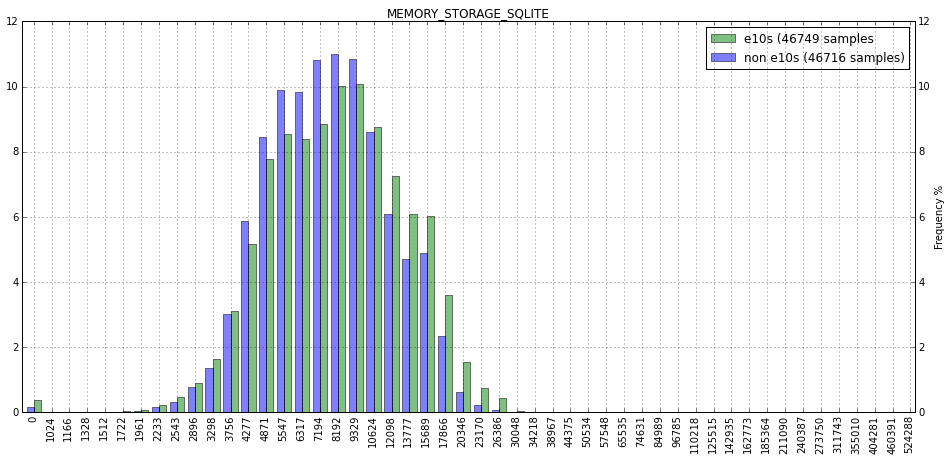

The chi2 distance for CYCLE_COLLECTOR_TIME_BETWEEN is 0.0119038917992


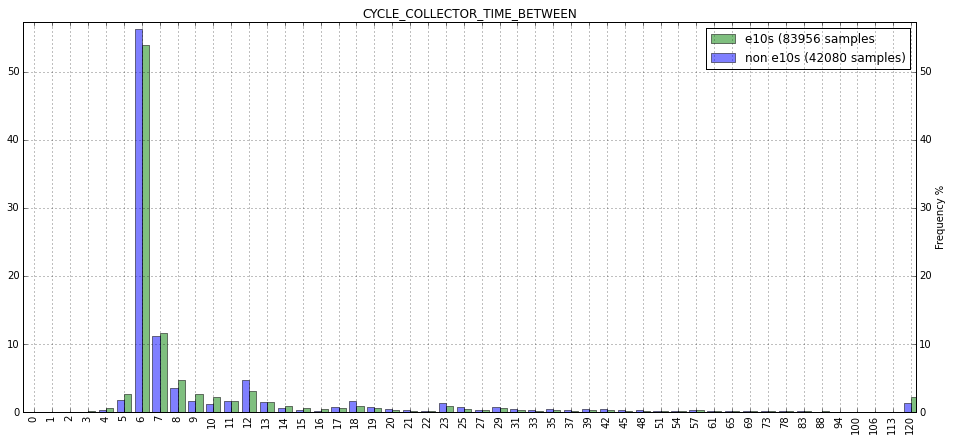

The chi2 distance for HEALTHREPORT_COLLECT_CONSTANT_DATA_MS is 0.0114634453112


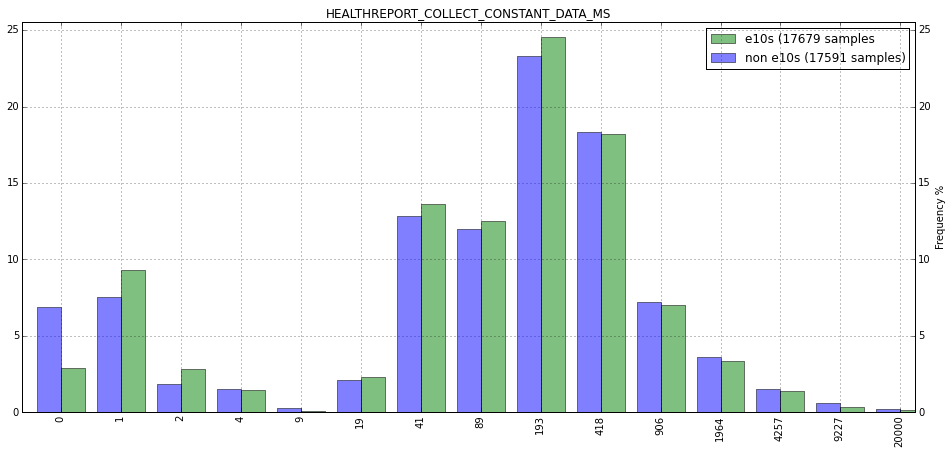

The chi2 distance for CYCLE_COLLECTOR_MAX_PAUSE is 0.0114154532583


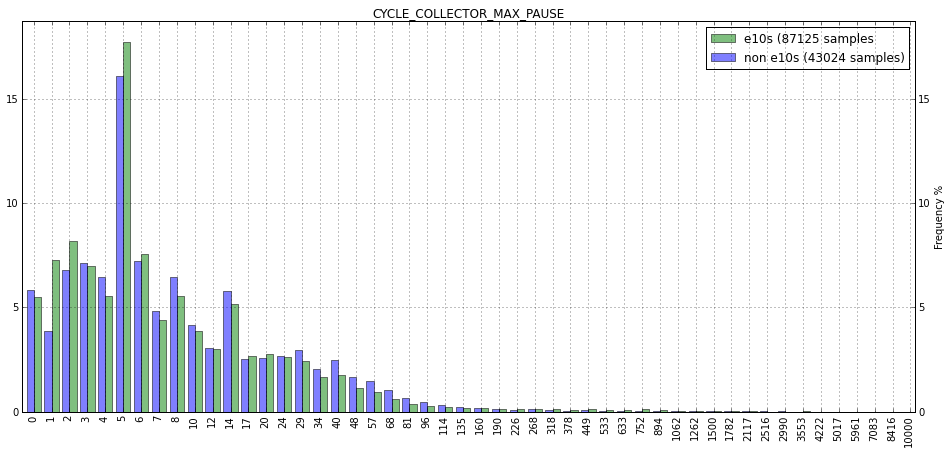

The chi2 distance for HTTP_SCHEME_UPGRADE is 0.0111682052346


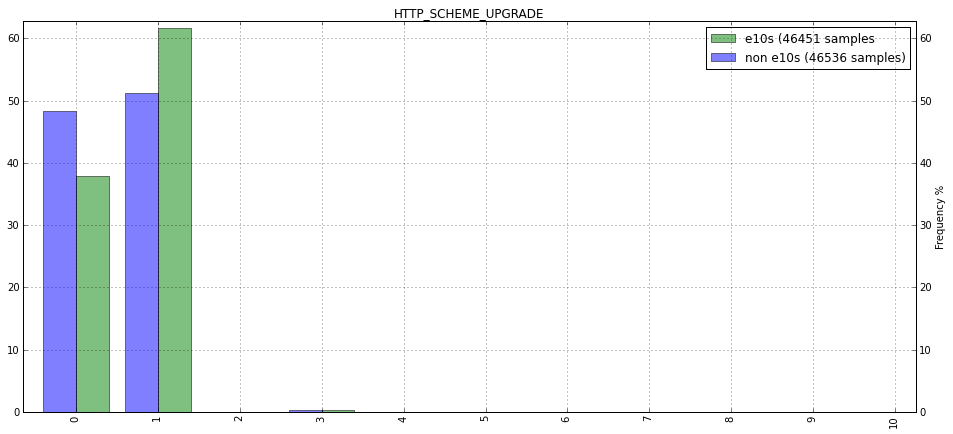

The chi2 distance for FX_THUMBNAILS_STORE_TIME_MS is 0.0109678279012


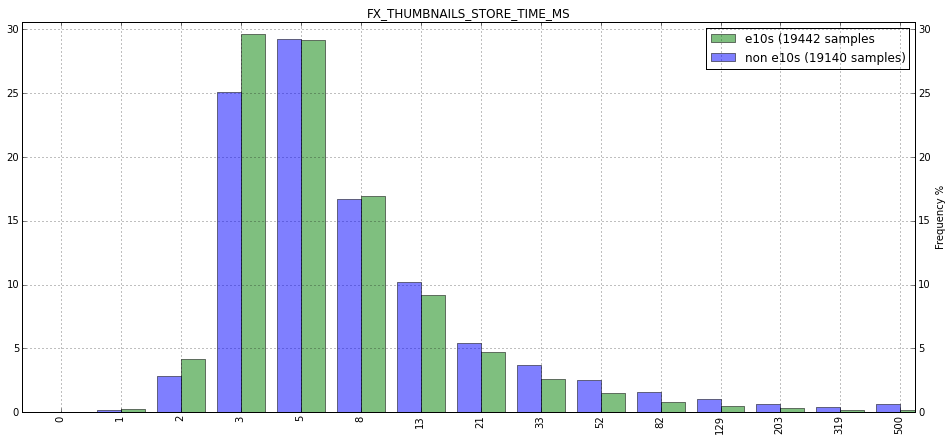

The chi2 distance for [[COUNT]]_JS_TELEMETRY_ADDON_EXCEPTIONS is 0.0108050896973


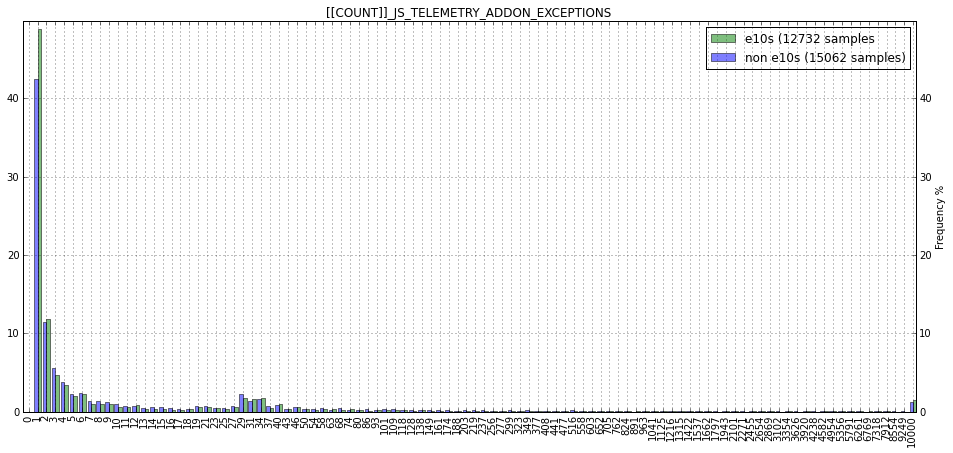

The chi2 distance for URL_PATH_CONTAINS_EXCLAMATION_SLASH is 0.0101948614458


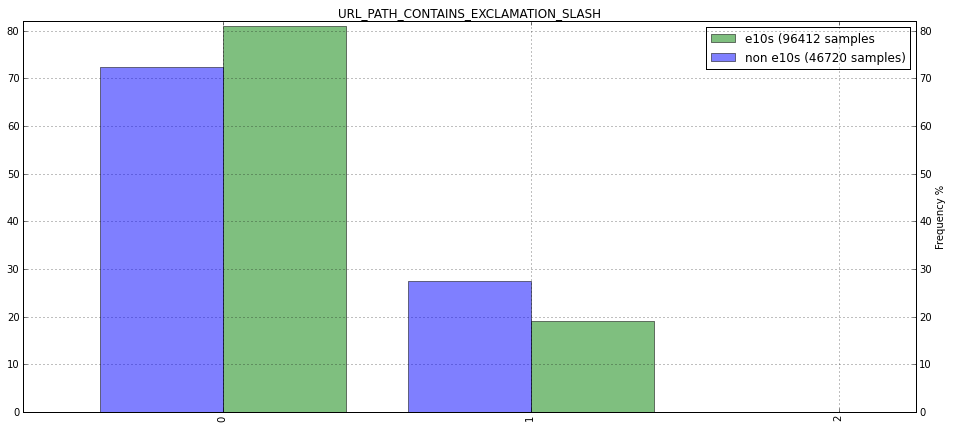

The chi2 distance for FX_SESSION_RESTORE_COLLECT_COOKIES_MS is 0.0101924247923


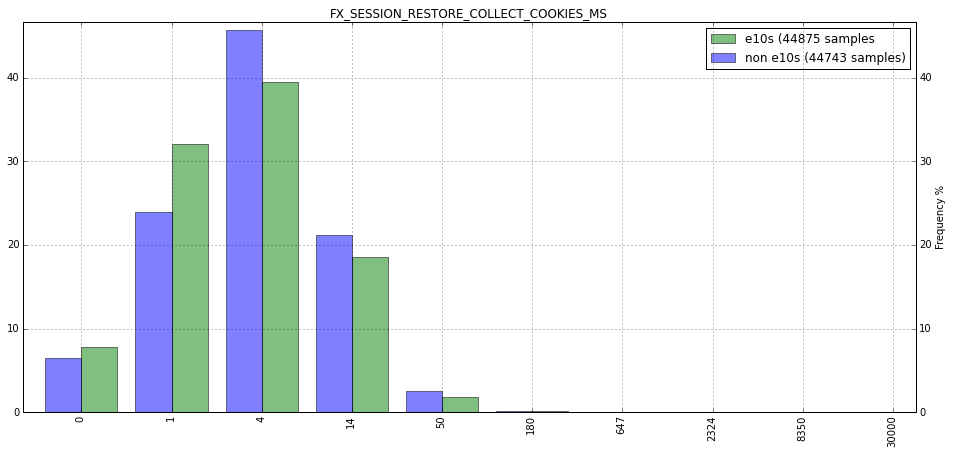

The chi2 distance for FX_THUMBNAILS_BG_CAPTURE_SERVICE_TIME_MS is 0.00991059896208


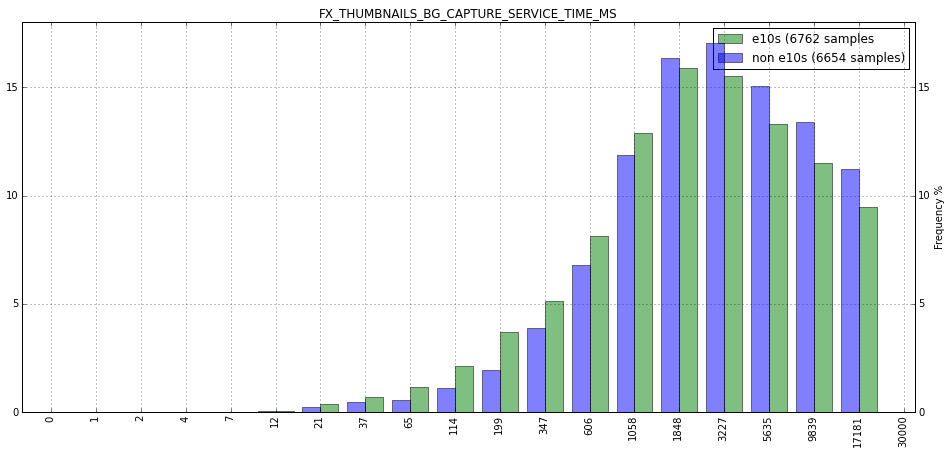

The chi2 distance for DWRITEFONT_DELAYEDINITFONTLIST_TOTAL is 0.00987152865897


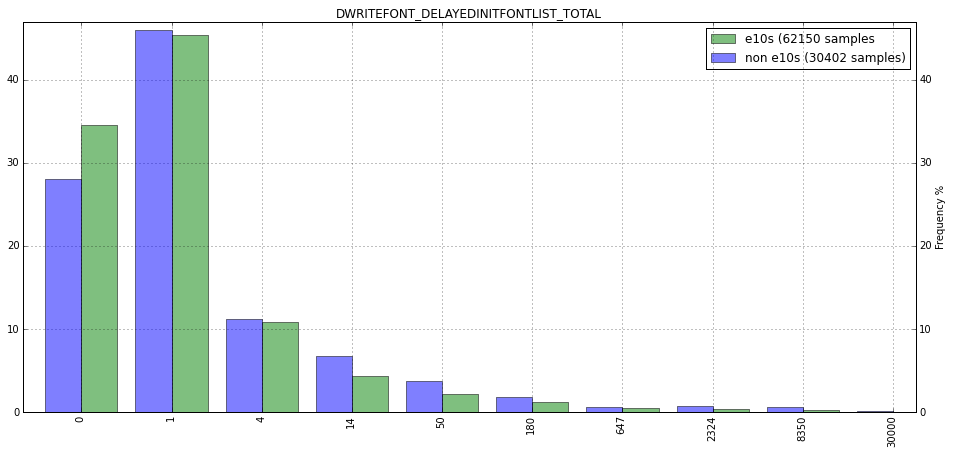

The chi2 distance for WEAVE_CAN_FETCH_KEYS is 0.00978921963604


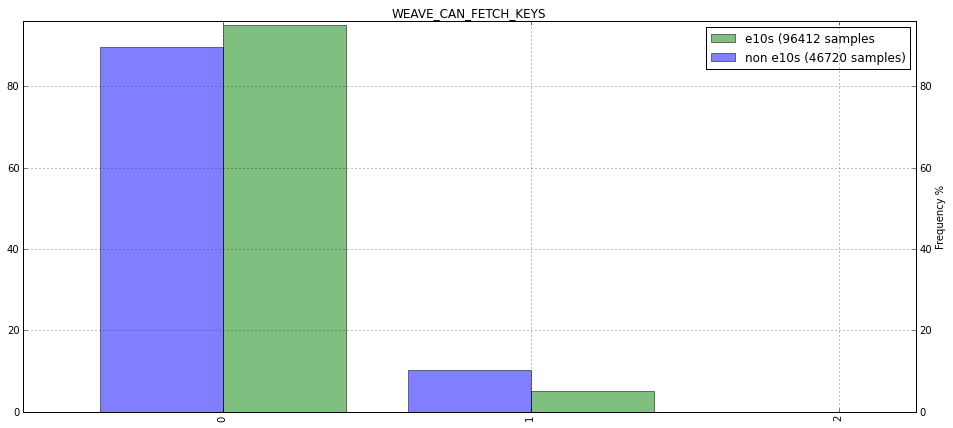

The chi2 distance for MOZ_SQLITE_PLACES_SYNC_MAIN_THREAD_MS is 0.00957592582919


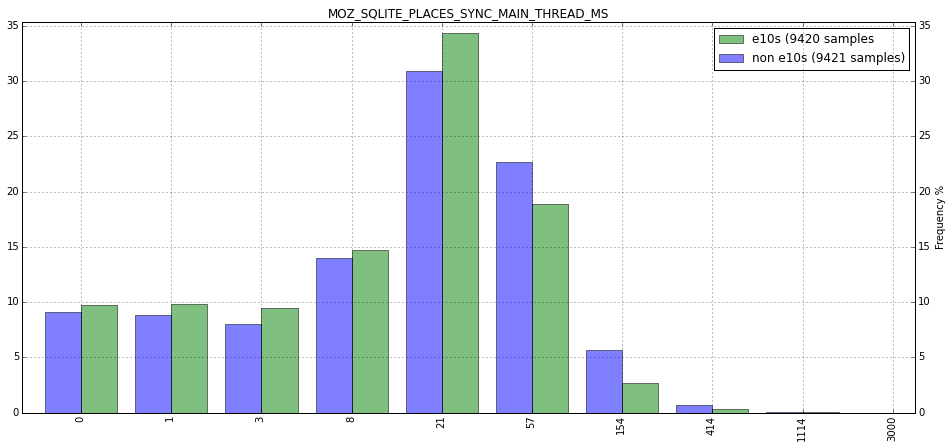

The chi2 distance for HEALTHREPORT_INIT_MS is 0.00954255901154


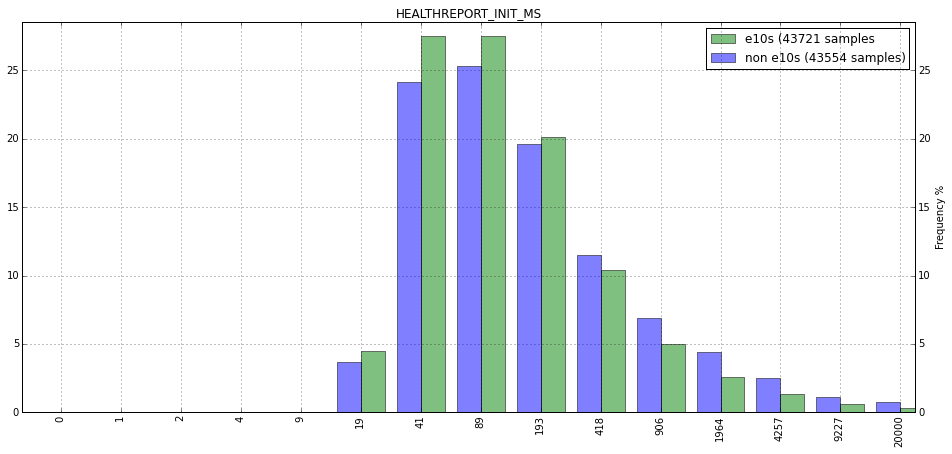

The chi2 distance for LINK_ICON_SIZES_ATTR_DIMENSION is 0.00942524093625


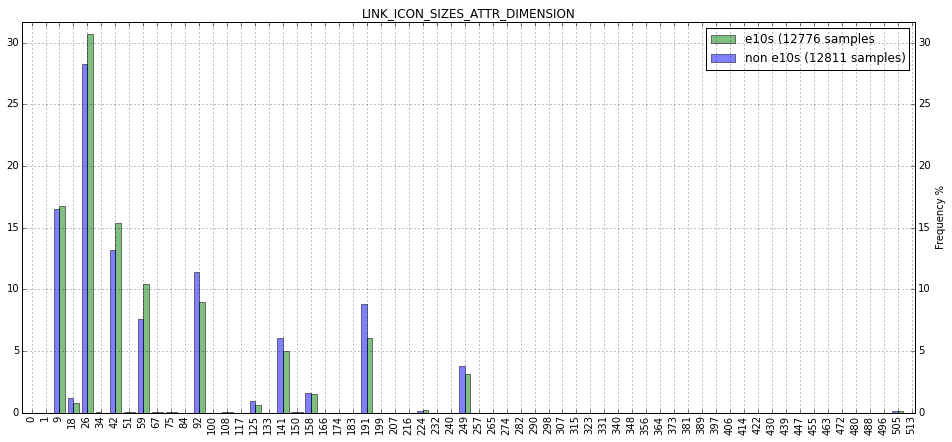

The chi2 distance for HTTP_SUBITEM_FIRST_BYTE_LATENCY_TIME is 0.00940573915808


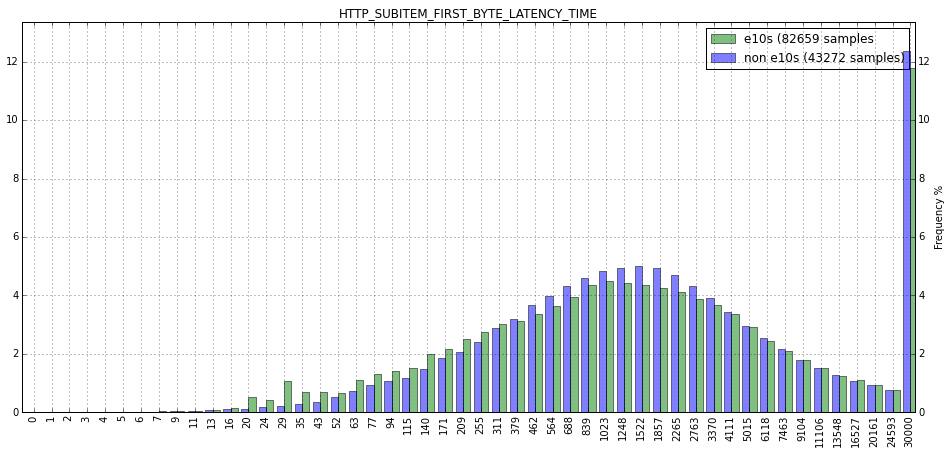

The chi2 distance for FLASH_PLUGIN_AREA is 0.00934864878387


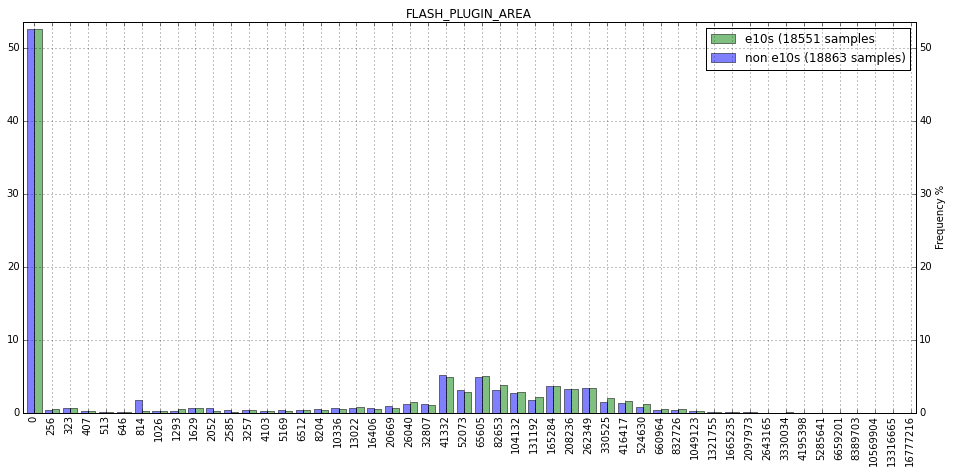

The chi2 distance for FX_THUMBNAILS_BG_CAPTURE_CANVAS_DRAW_TIME_MS is 0.00927840328592


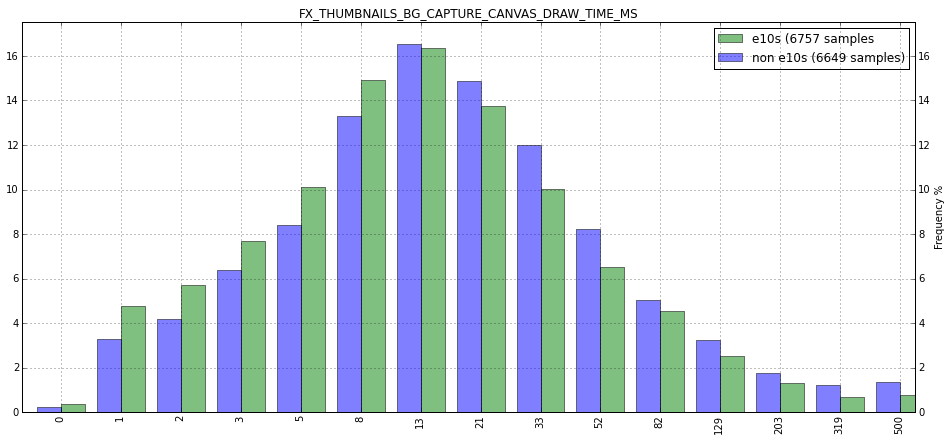

The chi2 distance for COOKIE_SCHEME_SECURITY is 0.00871925788902


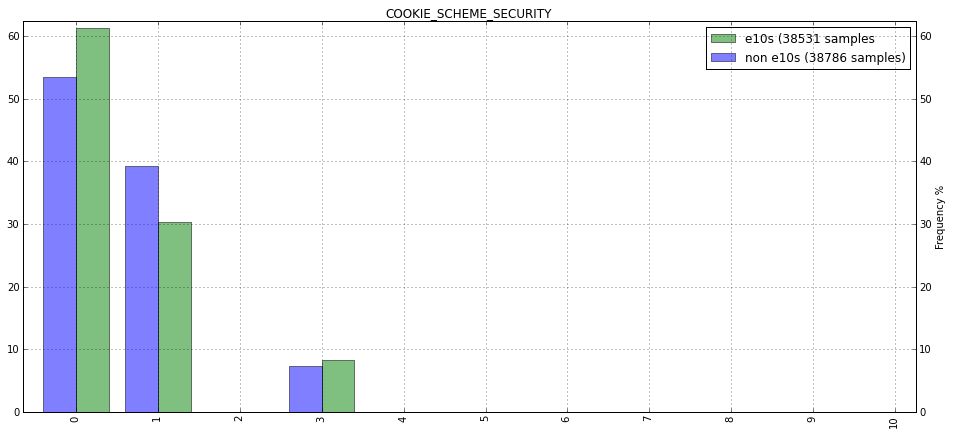

The chi2 distance for CRASH_STORE_COMPRESSED_BYTES is 0.00848706343805


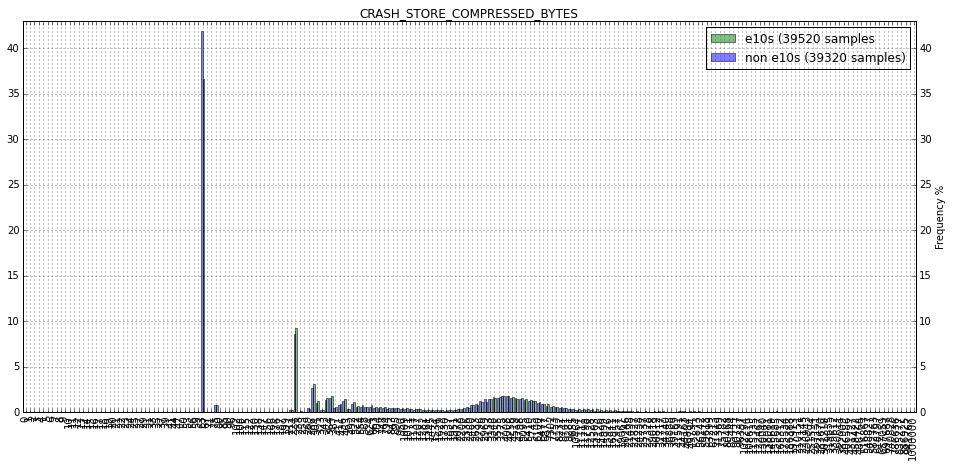

The chi2 distance for TELEMETRY_STRINGIFY is 0.00780800585091


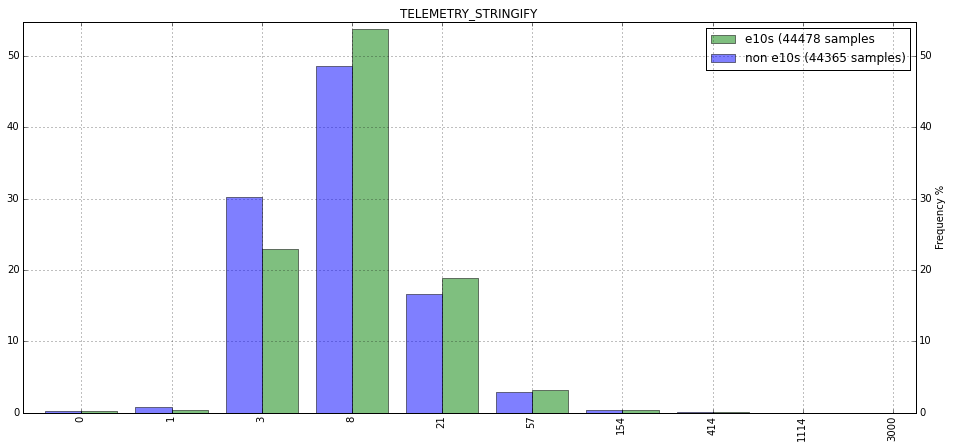

The chi2 distance for NETWORK_CACHE_HIT_MISS_STAT_PER_CACHE_SIZE is 0.00772205750109


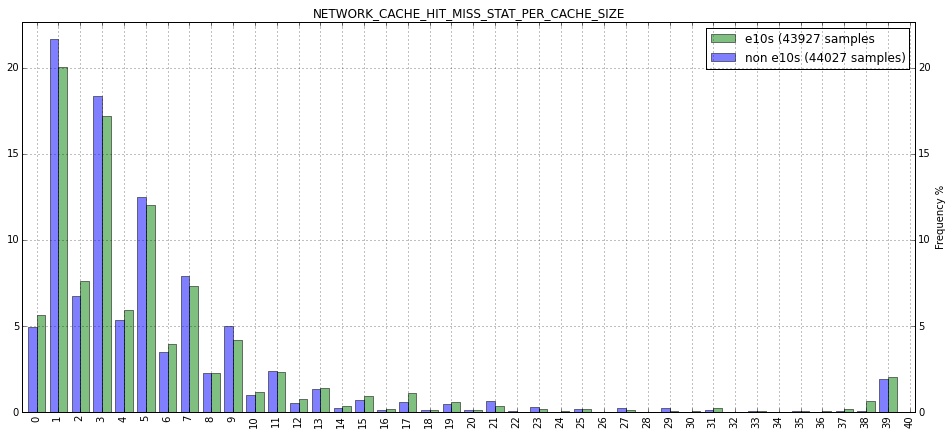

The chi2 distance for NETWORK_CACHE_METADATA_FIRST_READ_TIME_MS is 0.00770203727891


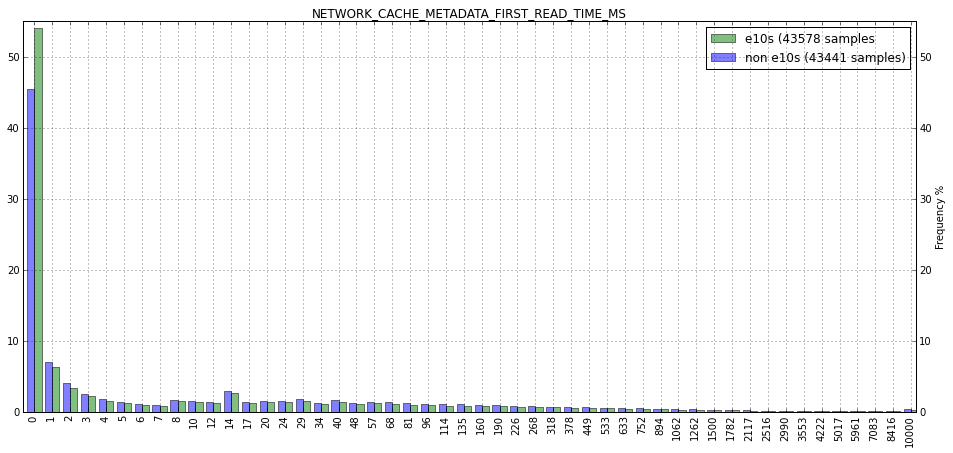

The chi2 distance for PREDICTOR_GLOBAL_DEGRADATION is 0.00746181161737


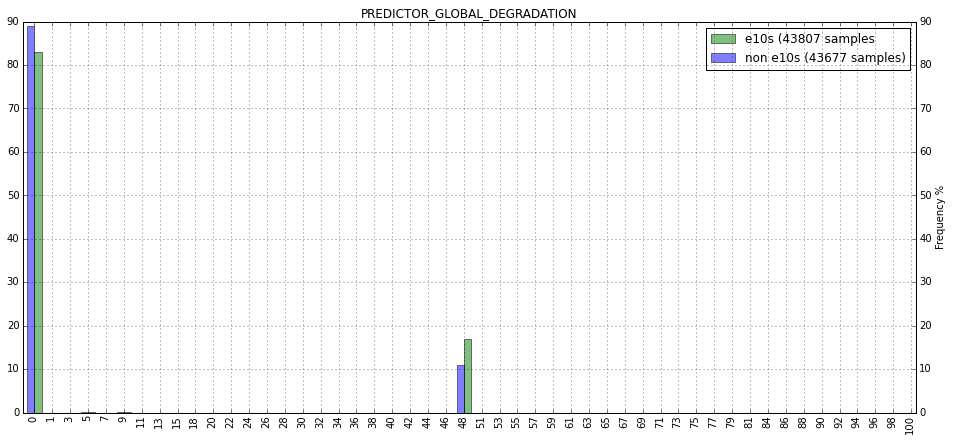

The chi2 distance for HTTP_CACHE_ENTRY_ALIVE_TIME is 0.00736580887587


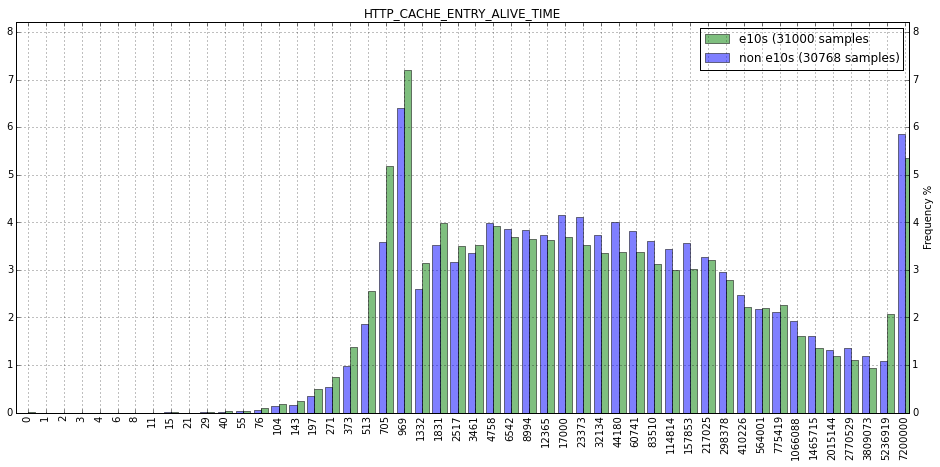

The chi2 distance for PREDICTOR_SUBRESOURCE_DEGRADATION is 0.00727664736878


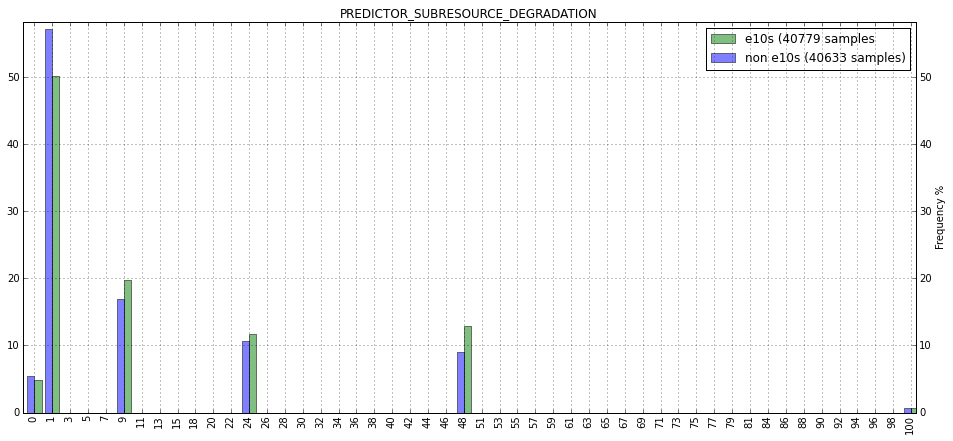

The chi2 distance for STARTUP_HTTP_SCHEME_UPGRADE is 0.00721398835984


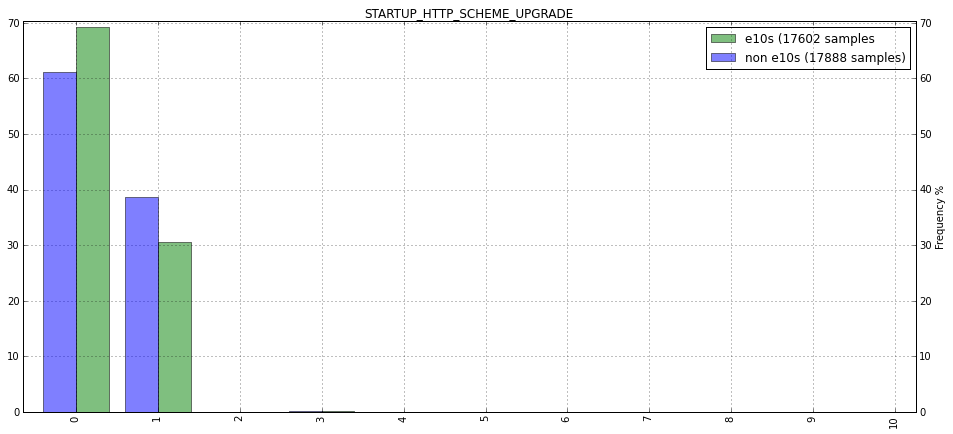

The chi2 distance for BLOCKED_ON_PLUGIN_INSTANCE_INIT_MS is 0.00702524194429


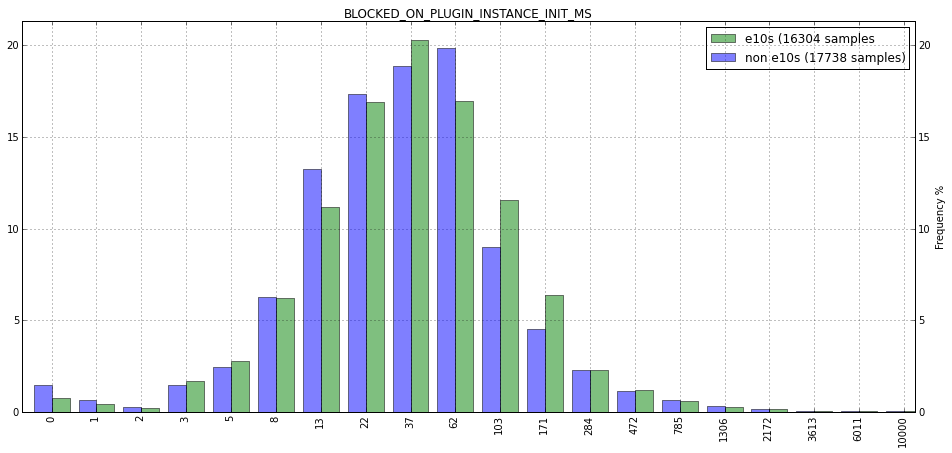

The chi2 distance for STS_NUMBER_OF_PENDING_EVENTS is 0.00680764067697


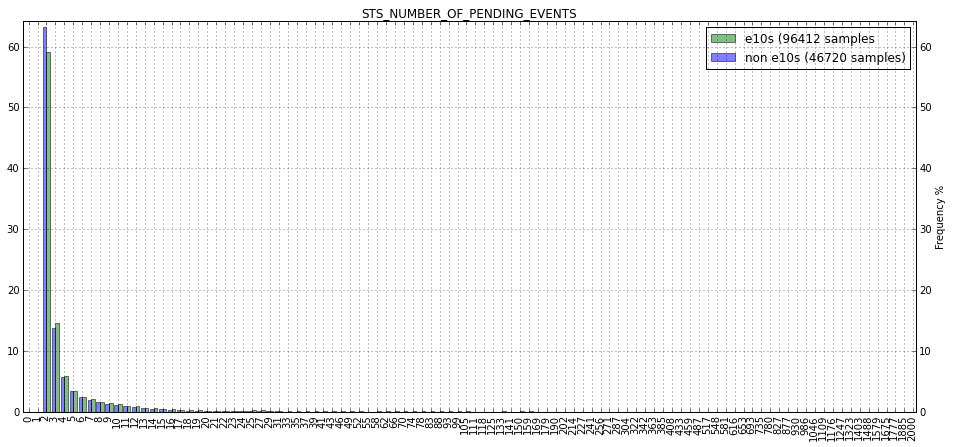

The chi2 distance for NETWORK_CACHE_V2_HIT_TIME_MS is 0.00678009733527


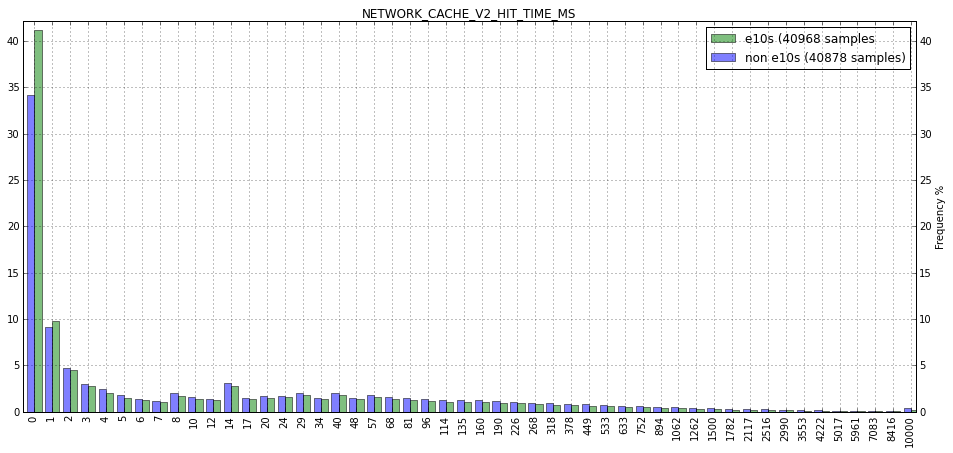

The chi2 distance for HEALTHREPORT_SHUTDOWN_MS is 0.00654271469916


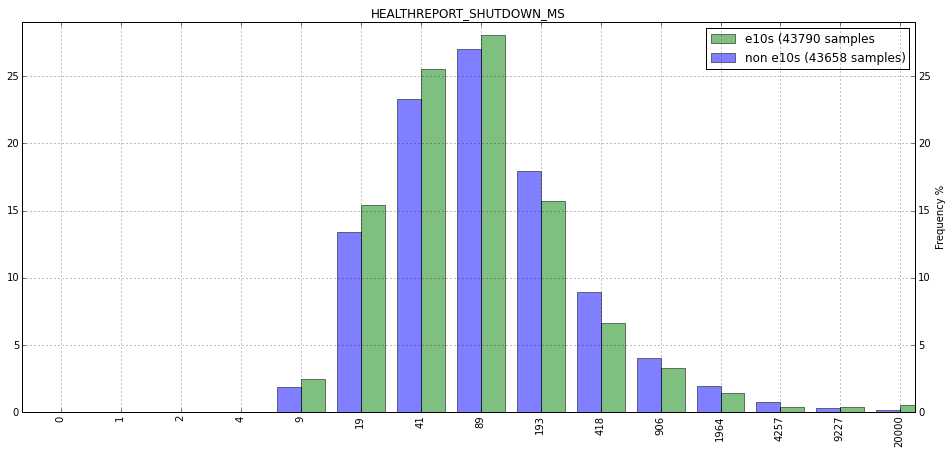

The chi2 distance for HTTP_PAGE_TCP_CONNECTION is 0.00645227814379


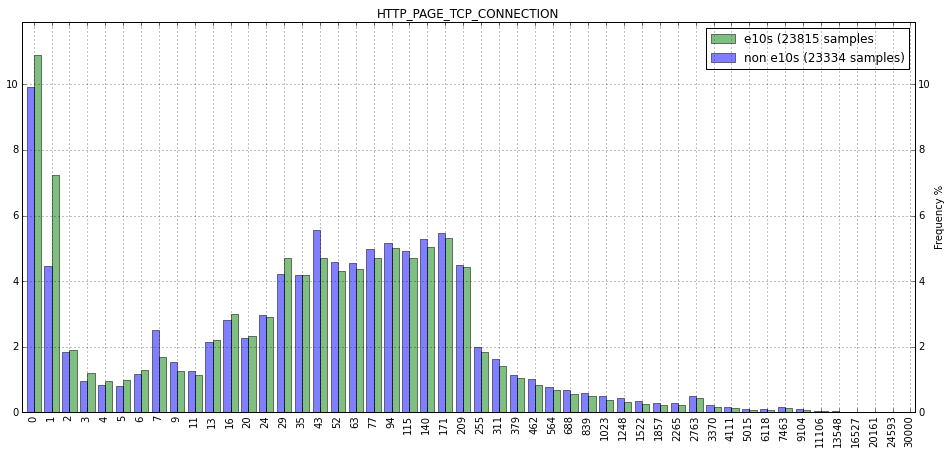

The chi2 distance for WORD_CACHE_HITS_CONTENT is 0.00643413520847


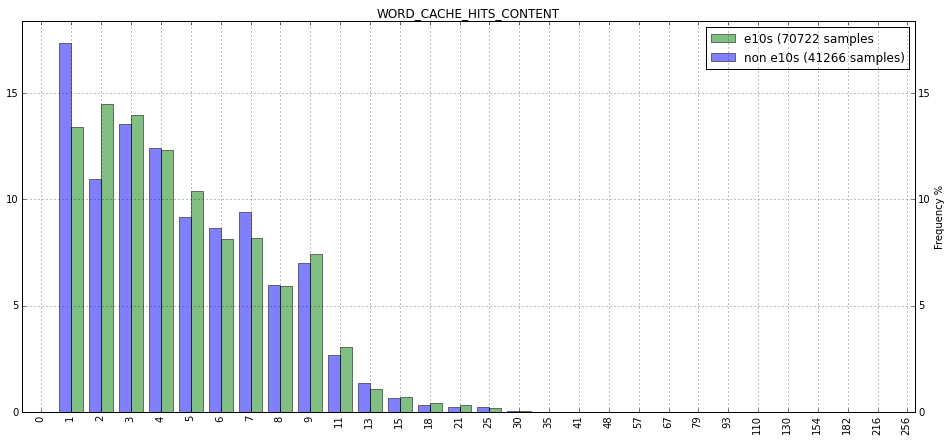

The chi2 distance for UPDATE_DOWNLOAD_CODE_COMPLETE is 0.00643284260674


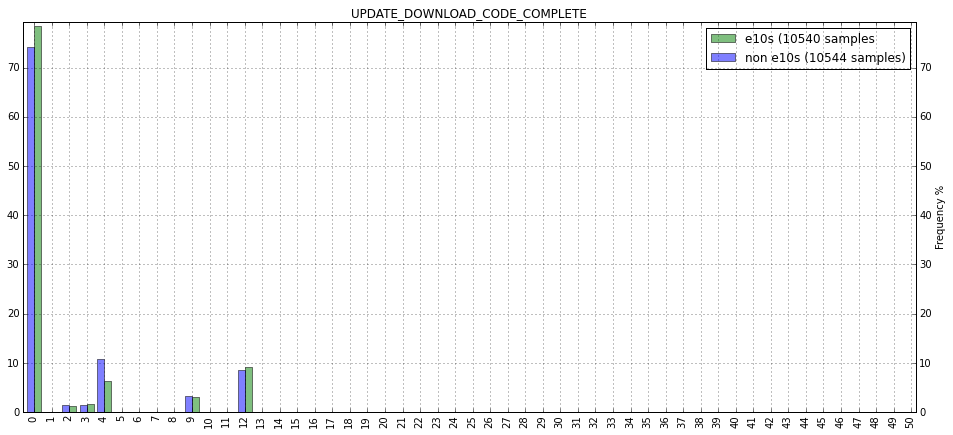

The chi2 distance for NETWORK_CACHE_METADATA_SECOND_READ_TIME_MS is 0.00630324568397


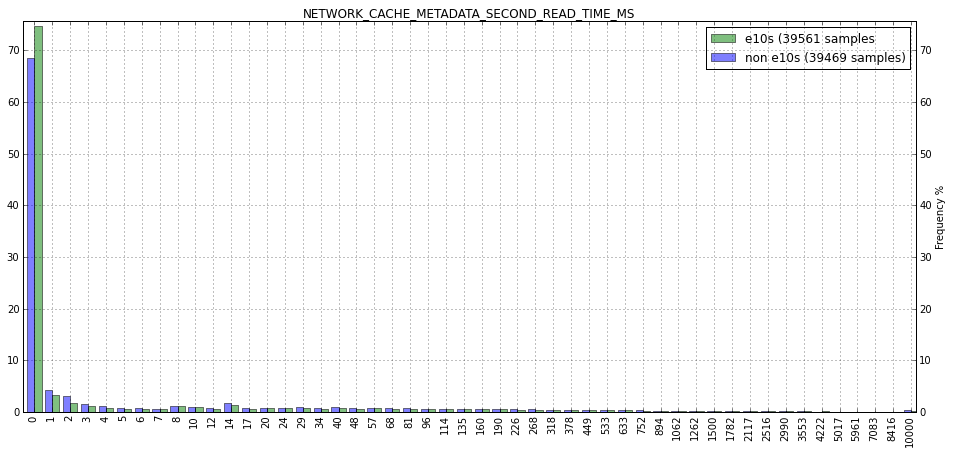

The chi2 distance for HEALTHREPORT_DB_OPEN_MS is 0.00621614812708


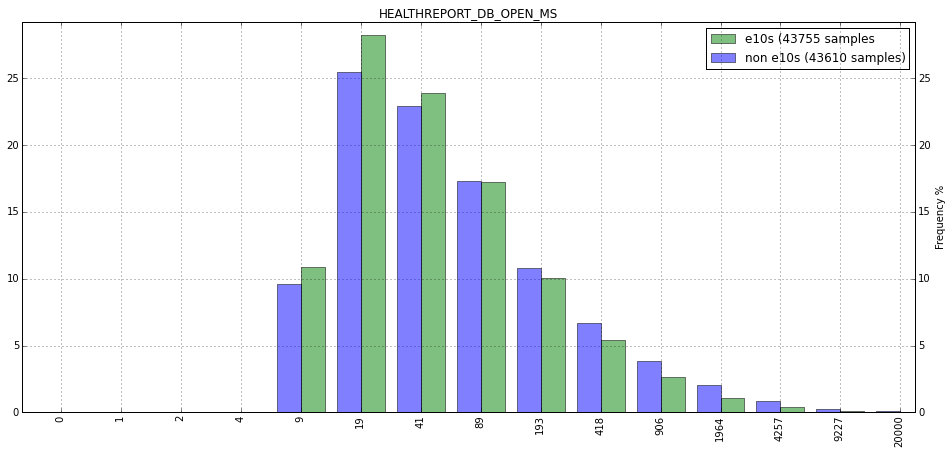

The chi2 distance for PREDICTOR_TOTAL_PREDICTIONS is 0.00620747623783


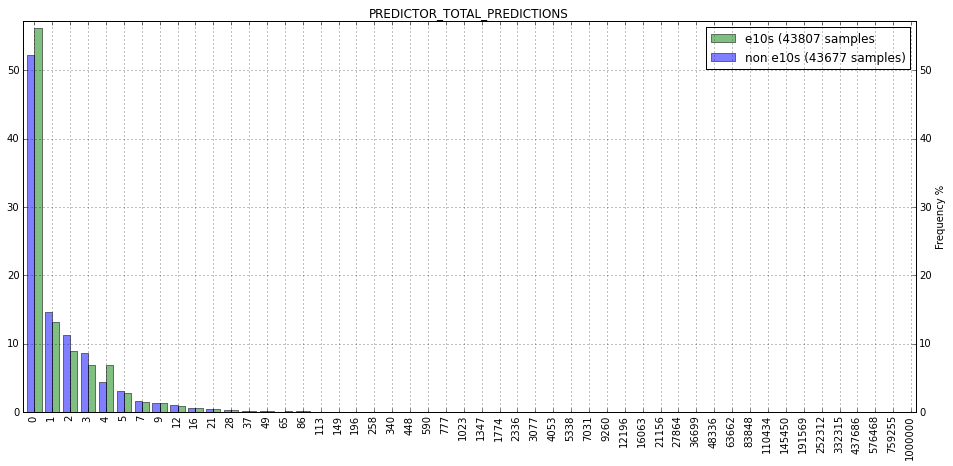

The chi2 distance for STS_NUMBER_OF_ONSOCKETREADY_CALLS is 0.00615630991082


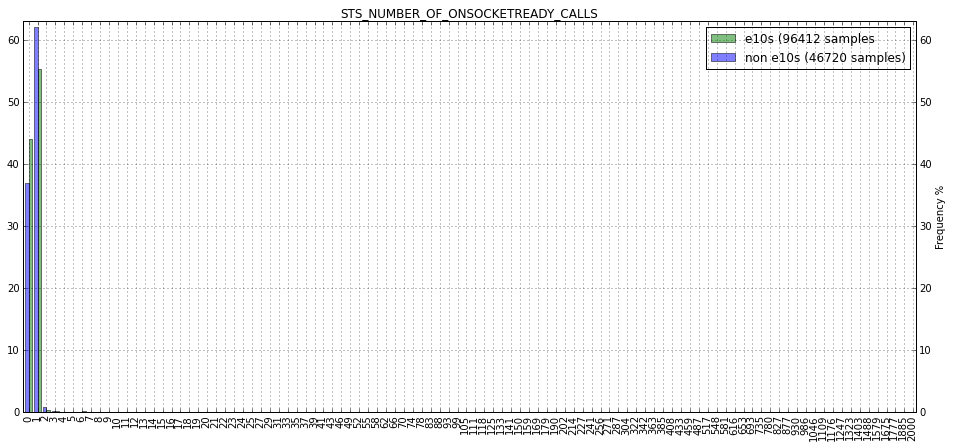

The chi2 distance for GRADIENT_DURATION is 0.00605780117427


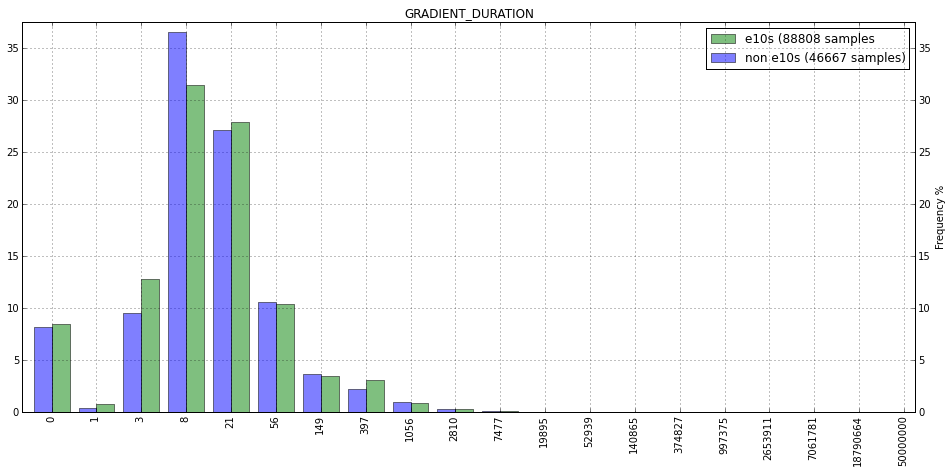

The chi2 distance for USE_COUNTER2_DEPRECATED_MutationEvent_PAGE is 0.00603970919296


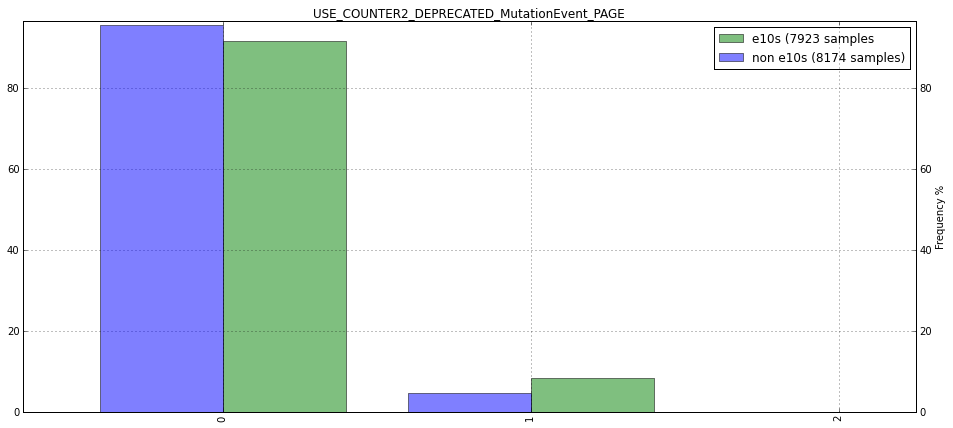

The chi2 distance for PLACES_FAVICON_ICO_SIZES is 0.00598899721375


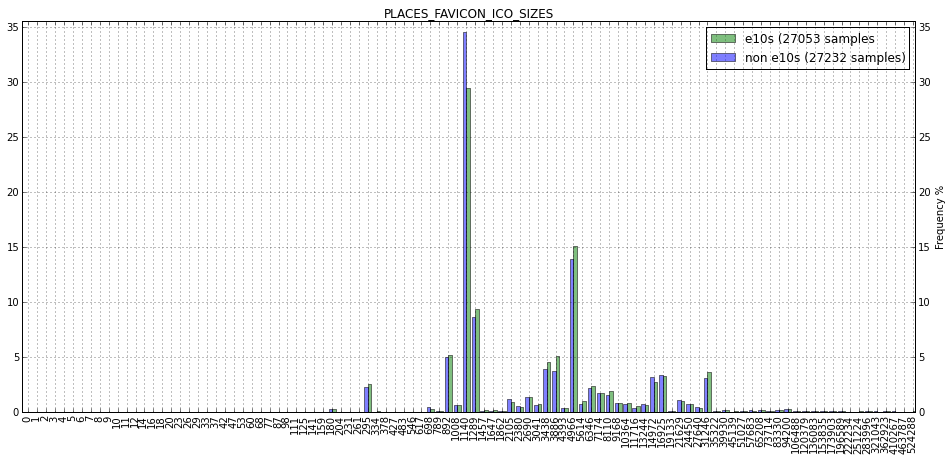

The chi2 distance for URLCLASSIFIER_LOOKUP_TIME is 0.00596614588181


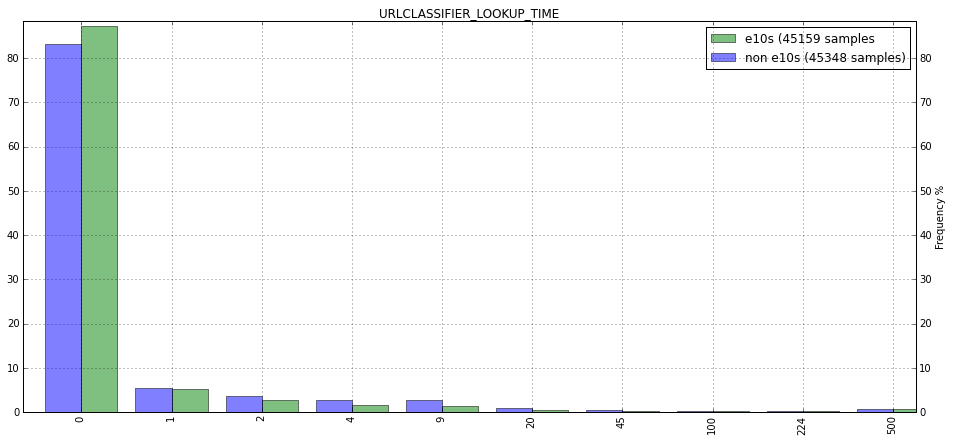

The chi2 distance for DEFERRED_FINALIZE_ASYNC is 0.00579670079257


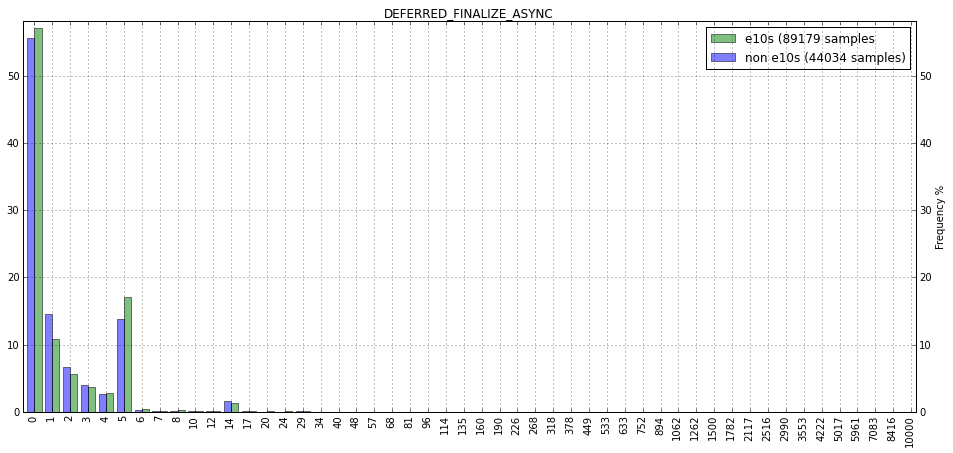

The chi2 distance for FX_SESSION_RESTORE_COLLECT_DATA_MS is 0.00573437949272


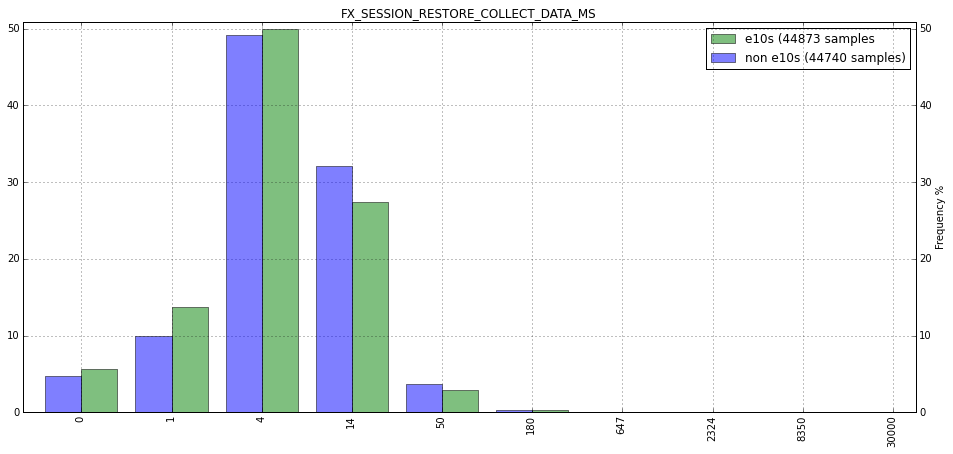

The chi2 distance for FX_SESSION_RESTORE_COLLECT_DATA_LONGEST_OP_MS is 0.00571091643393


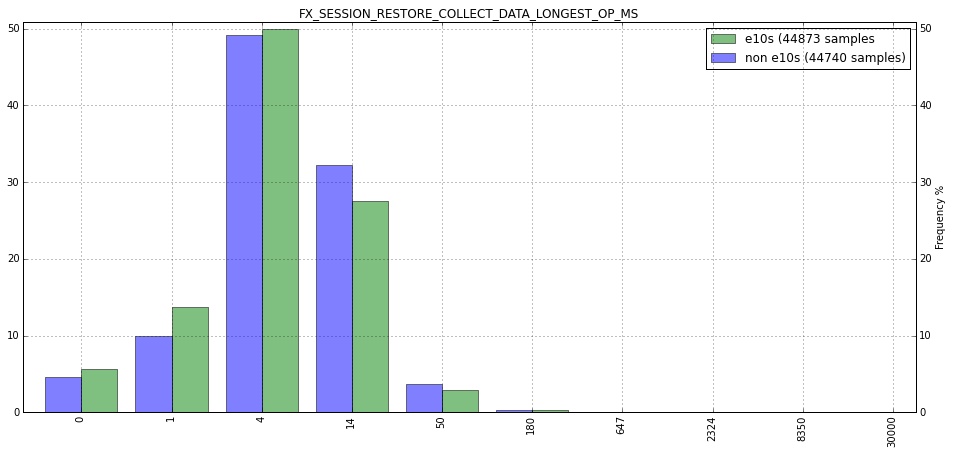

The chi2 distance for SIMPLE_MEASURES_STARTUPSESSIONRESTOREWRITEBYTES is 0.0056200868925


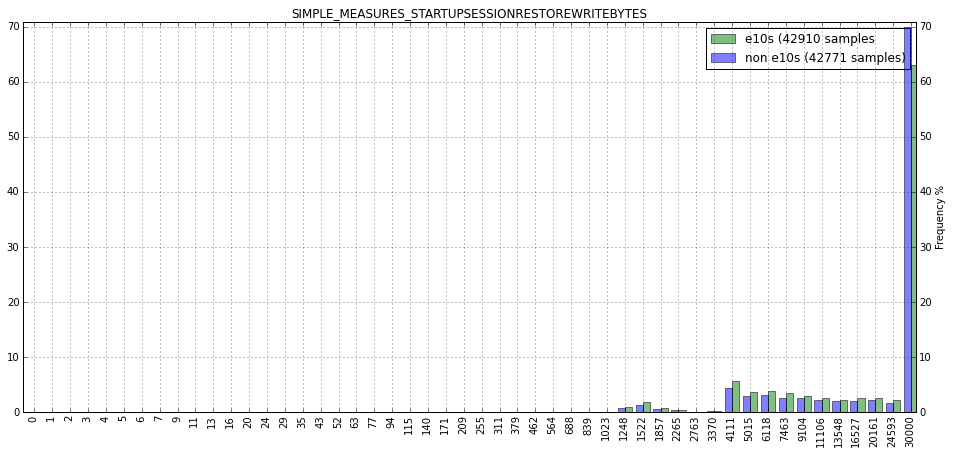

The chi2 distance for STS_POLL_AND_EVENT_THE_LAST_CYCLE is 0.00548682945802


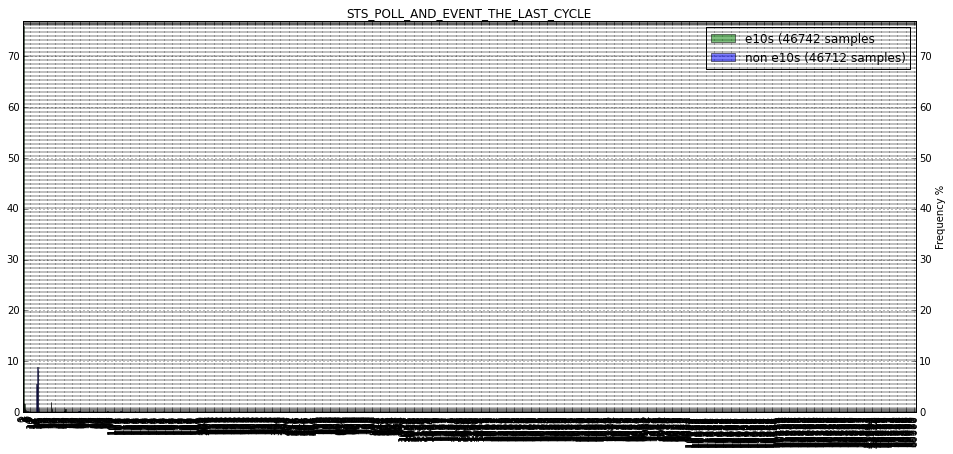

The chi2 distance for VIDEO_MSE_JOIN_LATENCY_MS is 0.00540356885628


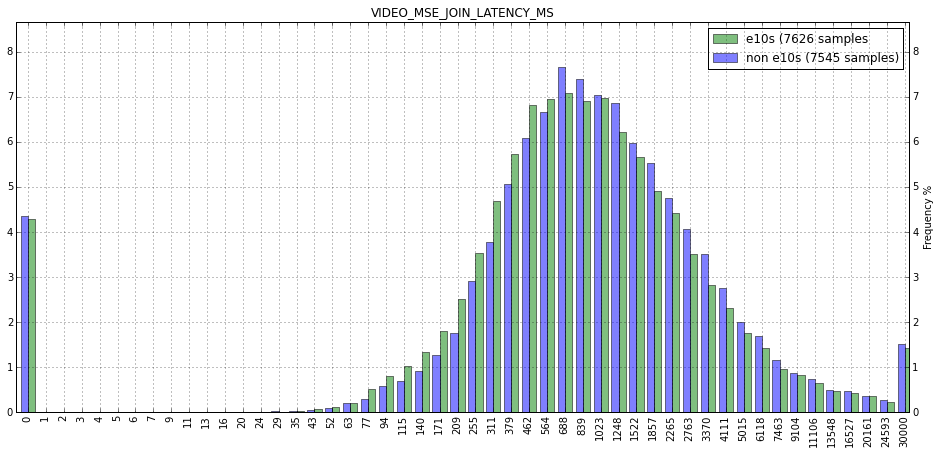

The chi2 distance for PREDICTOR_TOTAL_PRERESOLVES is 0.00533441417332


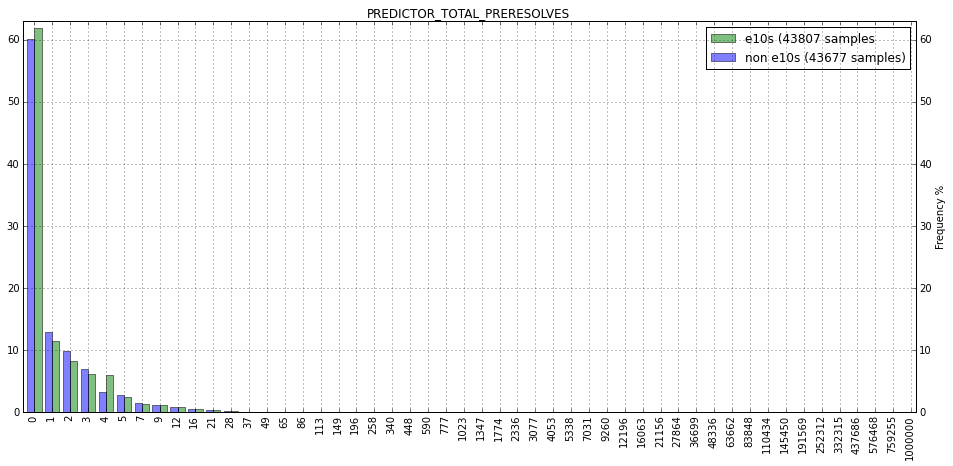

The chi2 distance for IMAGE_DECODE_CHUNKS is 0.00520174346882


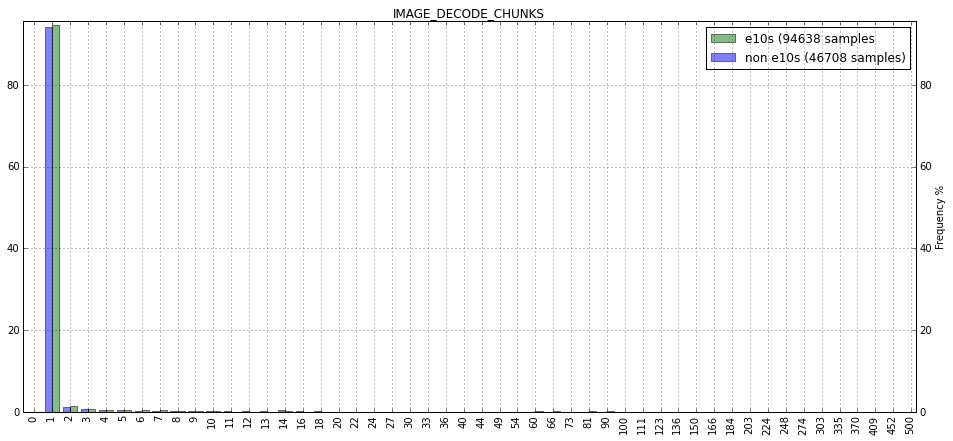

The chi2 distance for FLASH_PLUGIN_WIDTH is 0.0049184587675


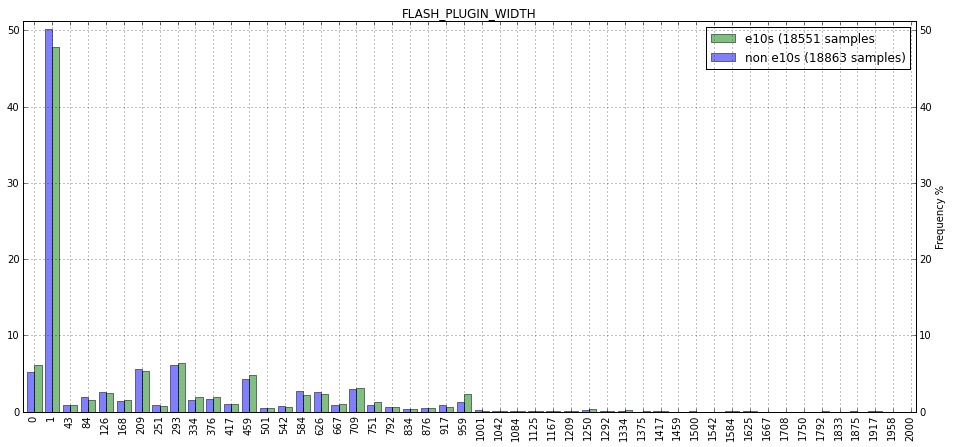

The chi2 distance for HTTP_CACHE_ENTRY_RELOAD_TIME is 0.00487220074904


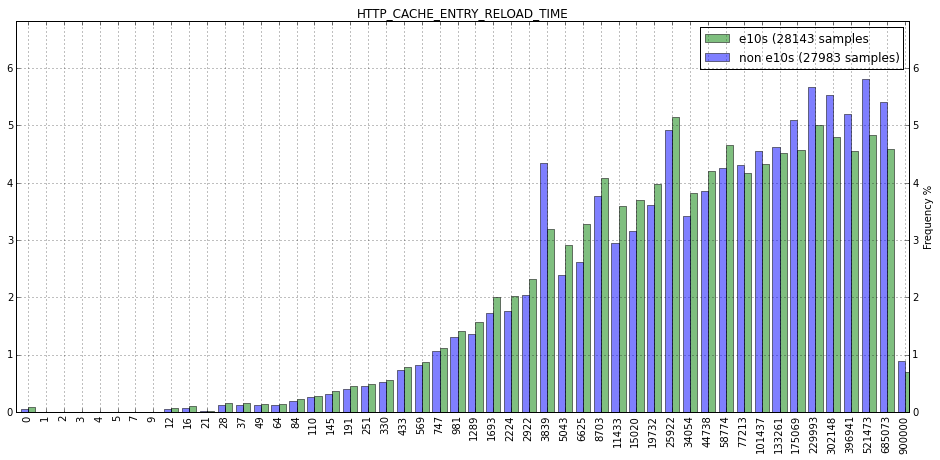

The chi2 distance for FX_TAB_ANIM_OPEN_PREVIEW_FRAME_INTERVAL_MS is 0.00475680163633


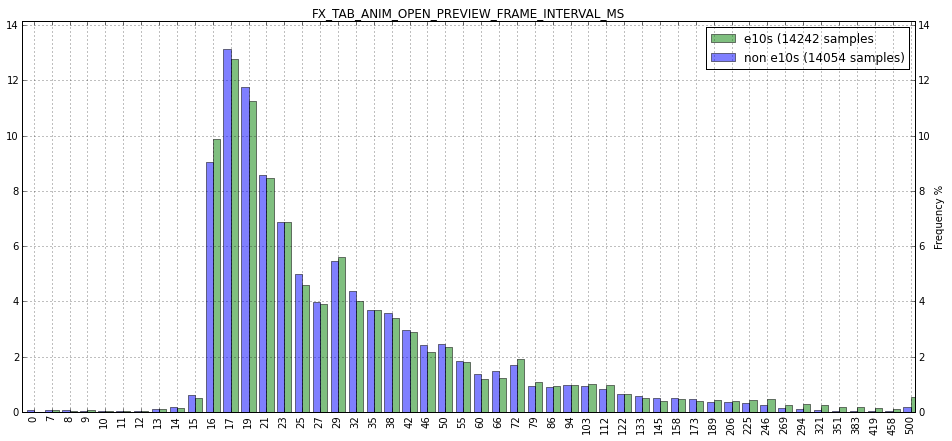

The chi2 distance for TELEMETRY_COMPRESS is 0.00470232249551


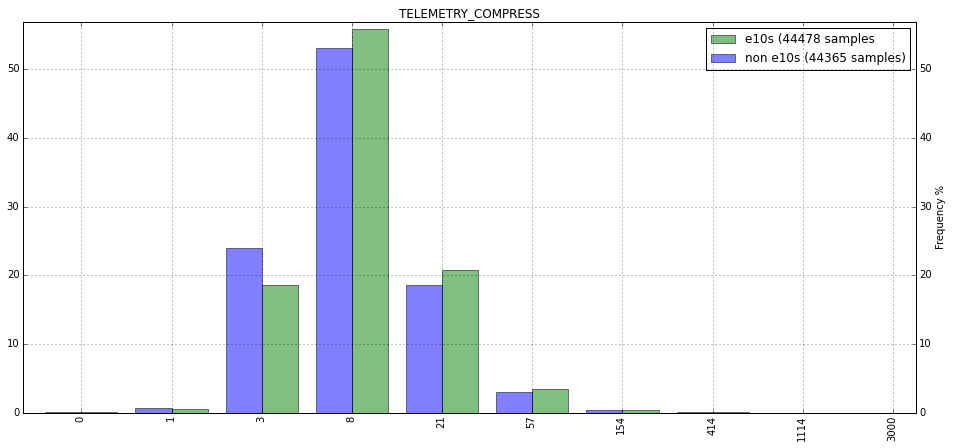

The chi2 distance for IMAGE_DECODE_SPEED_JPEG is 0.00460702638657


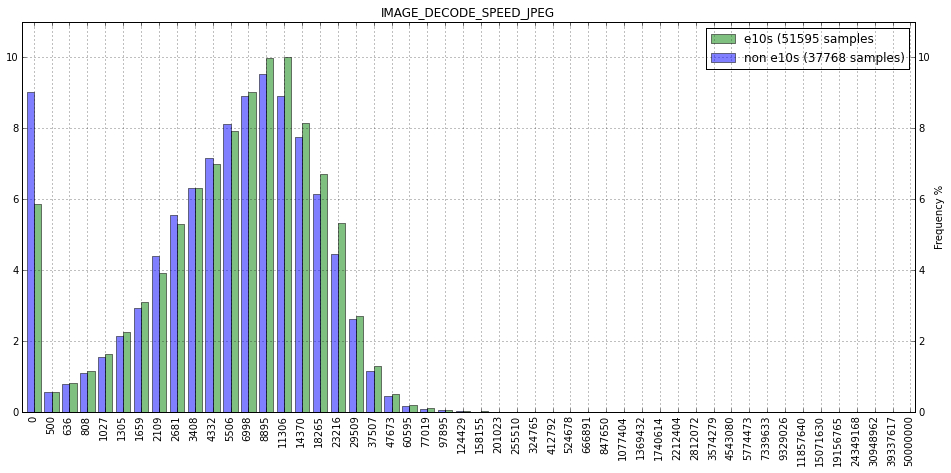

The chi2 distance for GDI_INITFONTLIST_TOTAL is 0.00457838337545


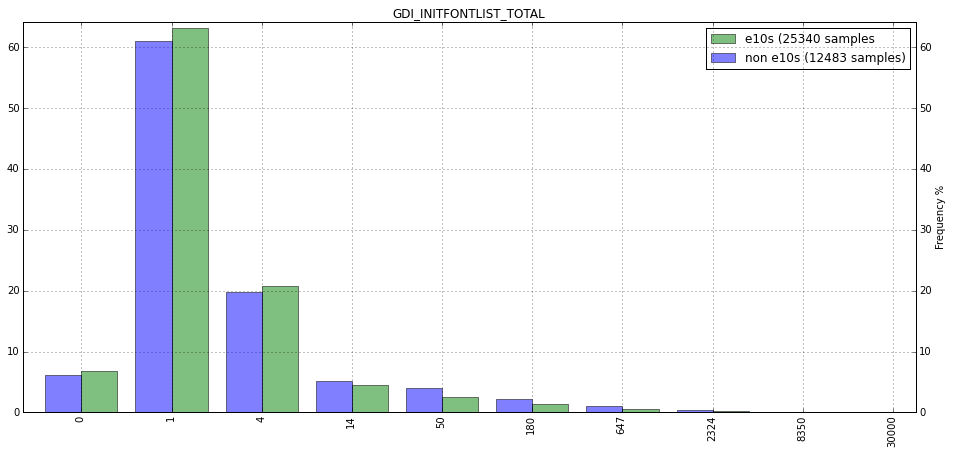

The chi2 distance for STS_NUMBER_OF_PENDING_EVENTS_IN_THE_LAST_CYCLE is 0.00457010241196


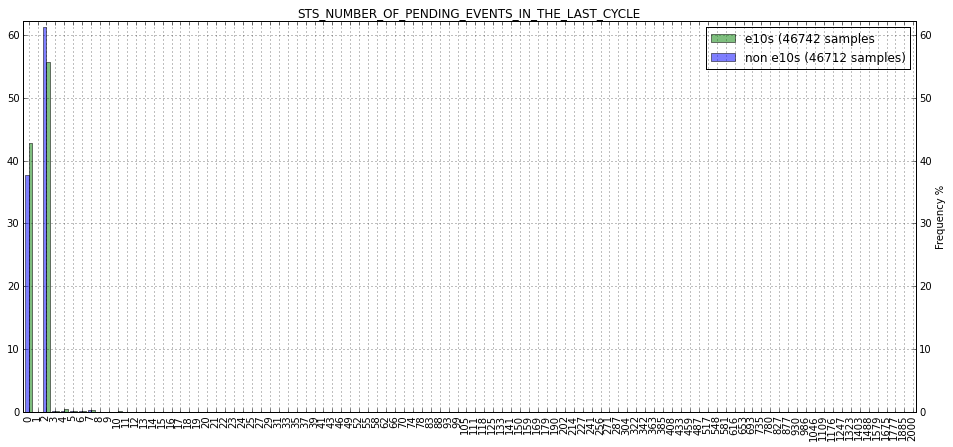

The chi2 distance for CERT_VALIDATION_HTTP_REQUEST_RESULT is 0.00441091689102


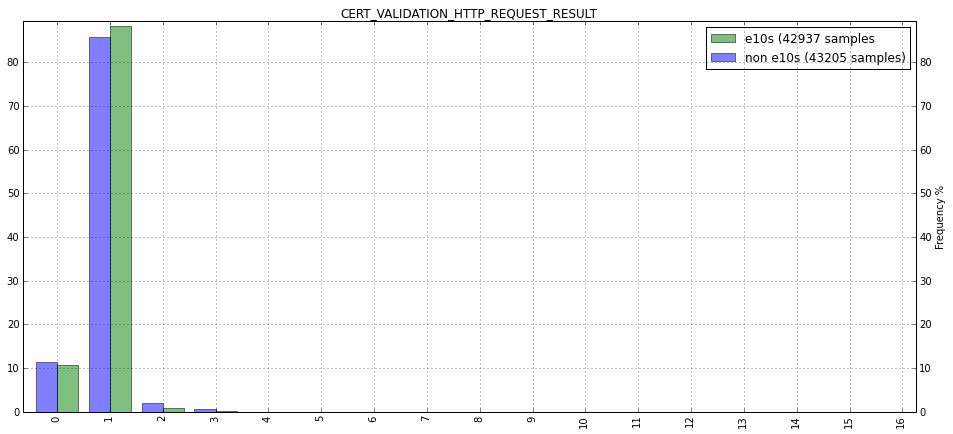

The chi2 distance for CERT_VALIDATION_HTTP_REQUEST_SUCCEEDED_TIME is 0.00426753457346


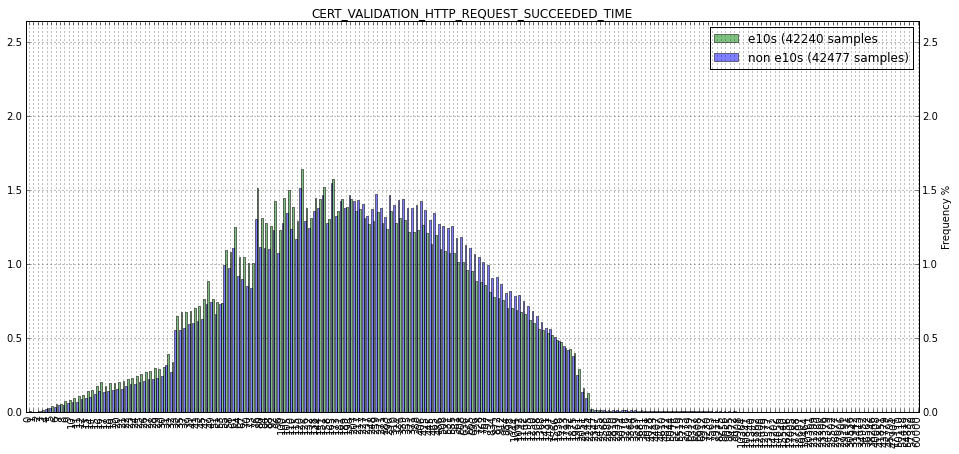

The chi2 distance for HTTP_SUB_FIRST_SENT_TO_LAST_RECEIVED is 0.00419112436472


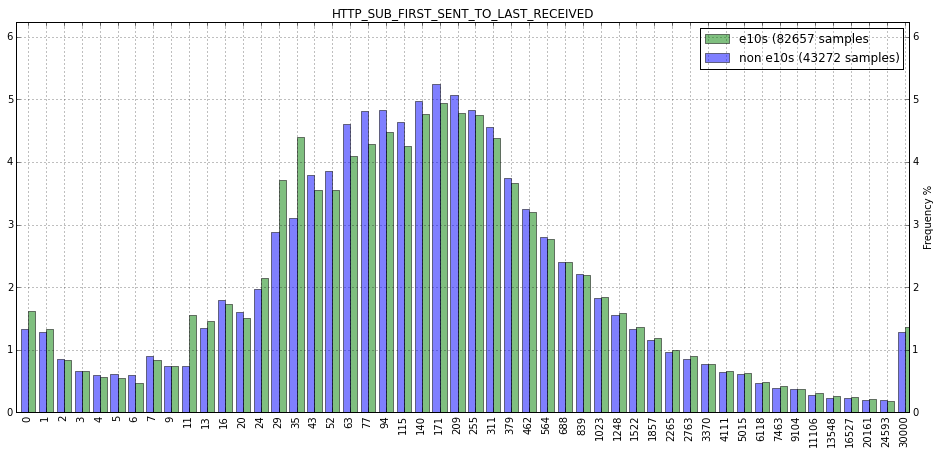

The chi2 distance for NETWORK_CACHE_METADATA_SIZE is 0.00405344065797


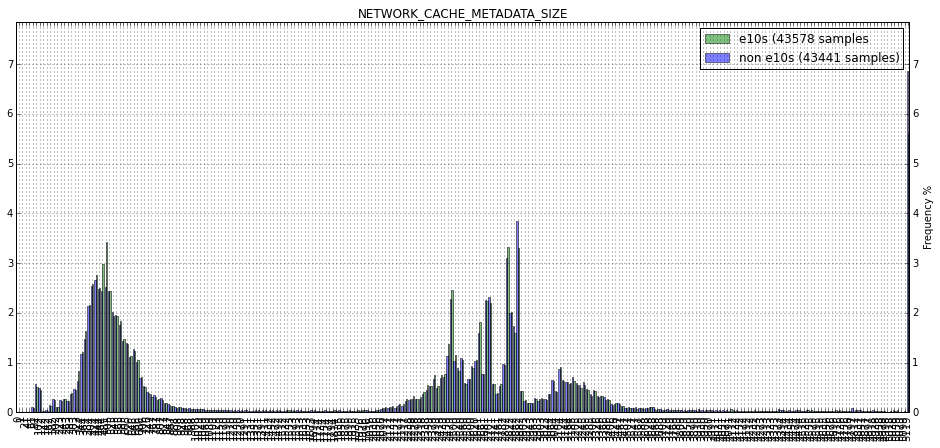

The chi2 distance for [[COUNT]]_PLUGIN_ACTIVATION_COUNT is 0.00392131796593


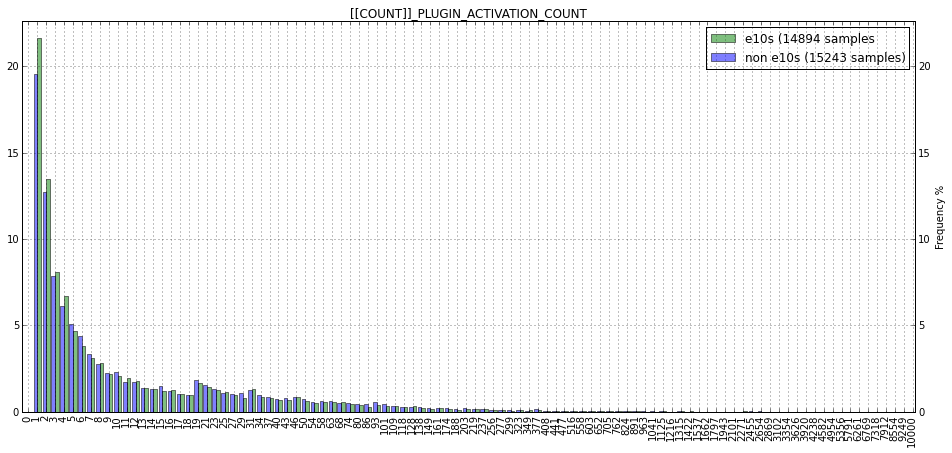

The chi2 distance for COMPONENTS_SHIM_ACCESSED_BY_CONTENT is 0.00384410915837


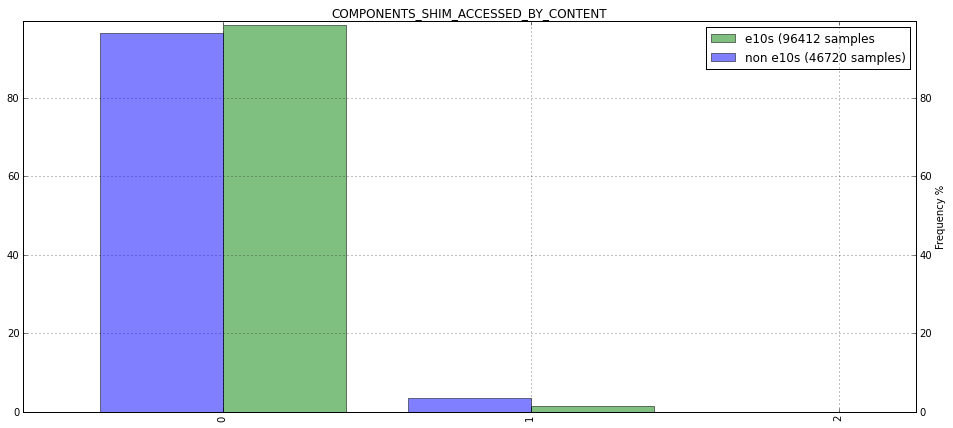

The chi2 distance for VIDEO_H264_SPS_MAX_NUM_REF_FRAMES is 0.00371631119416


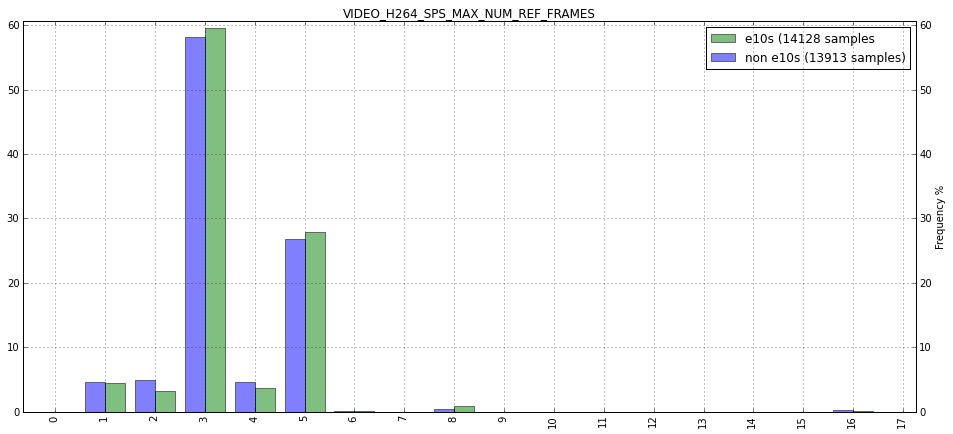

The chi2 distance for LINK_ICON_SIZES_ATTR_USAGE is 0.00364532476909


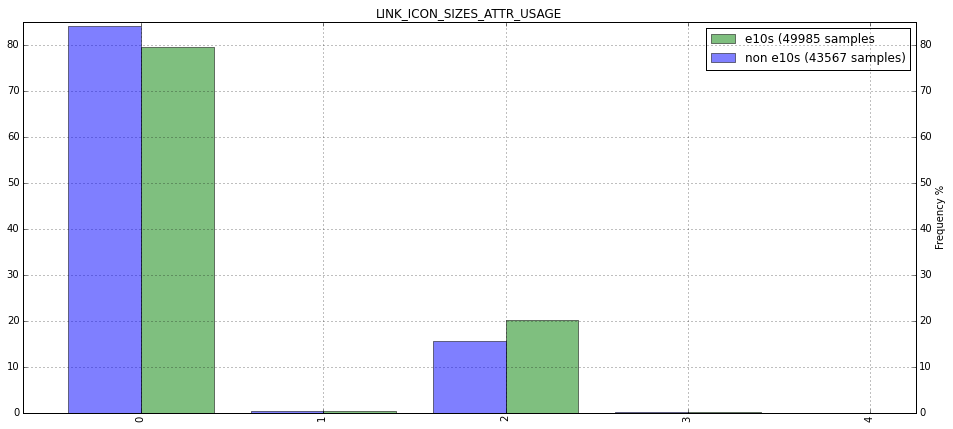

The chi2 distance for EVENTLOOP_UI_LAG_EXP_MS is 0.00354677083734


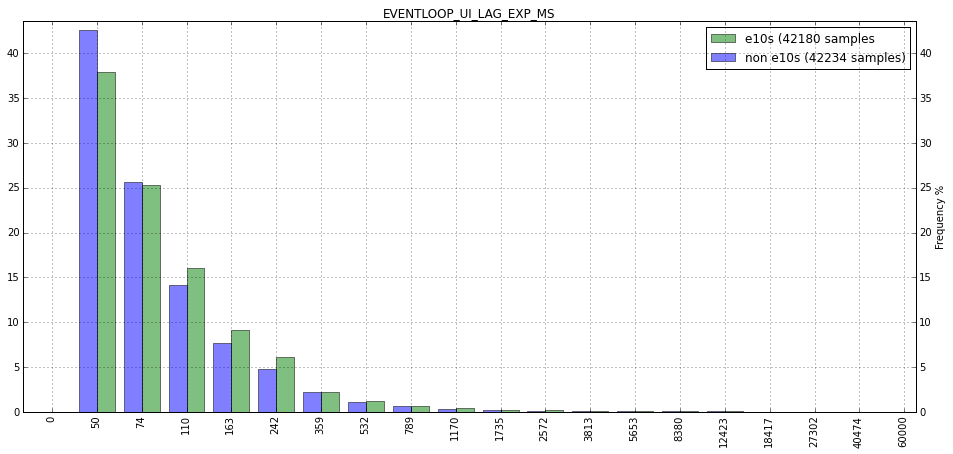

The chi2 distance for COMPOSITE_TIME is 0.0035312901935


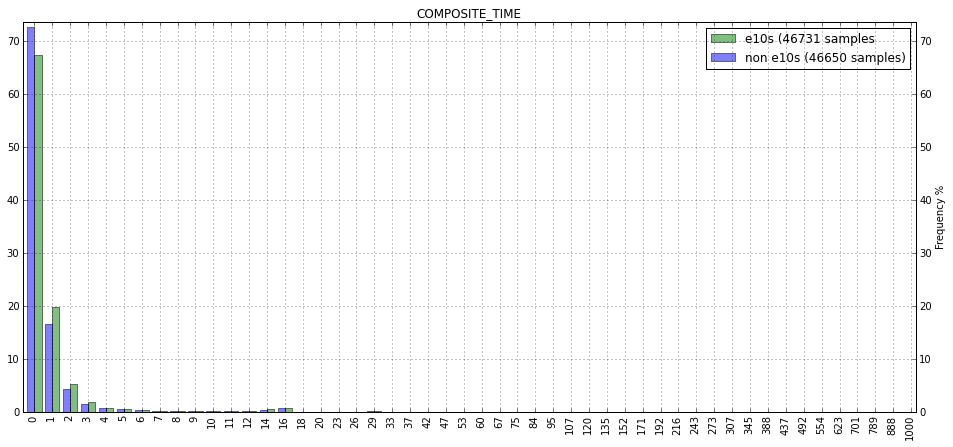

The chi2 distance for FX_SESSION_RESTORE_STARTUP_ONLOAD_INITIAL_WINDOW_MS is 0.00352682538854


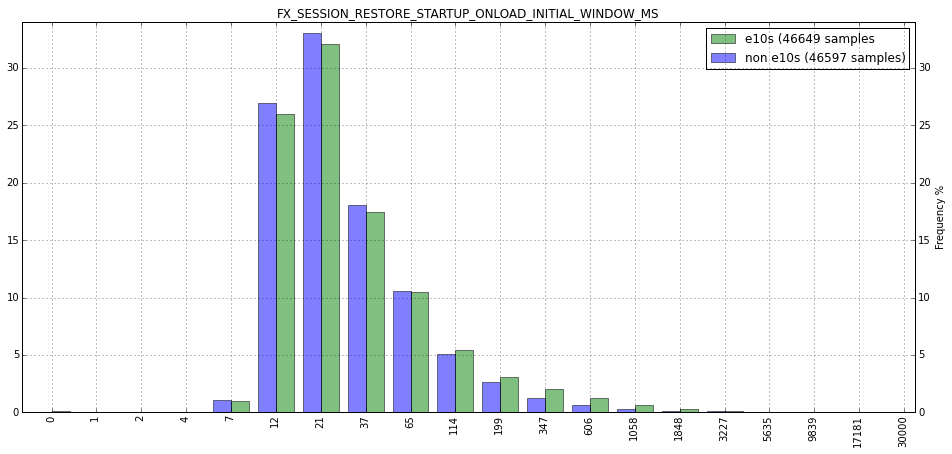

The chi2 distance for SSL_KEA_RSA_KEY_SIZE_FULL is 0.0035163843758


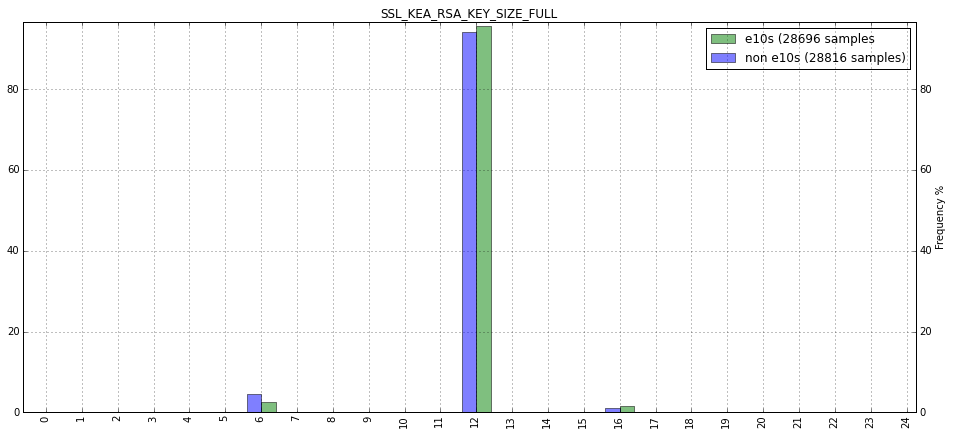

The chi2 distance for SSL_TLS12_INTOLERANCE_REASON_PRE is 0.00346521835576


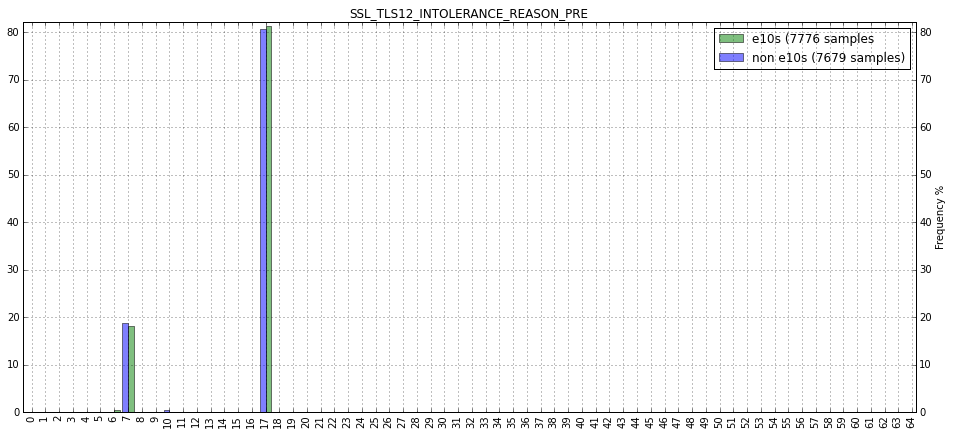

The chi2 distance for TELEMETRY_PENDING_PINGS_AGE is 0.00345094028347


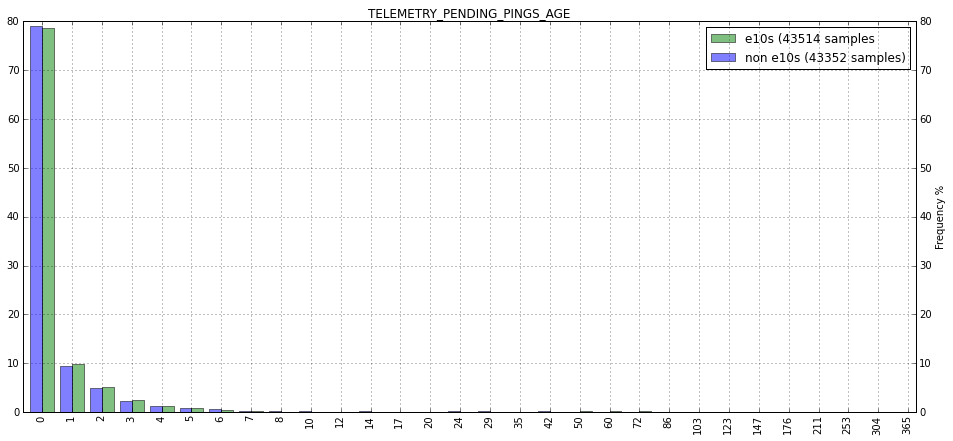

The chi2 distance for FLASH_PLUGIN_HEIGHT is 0.0034102499756


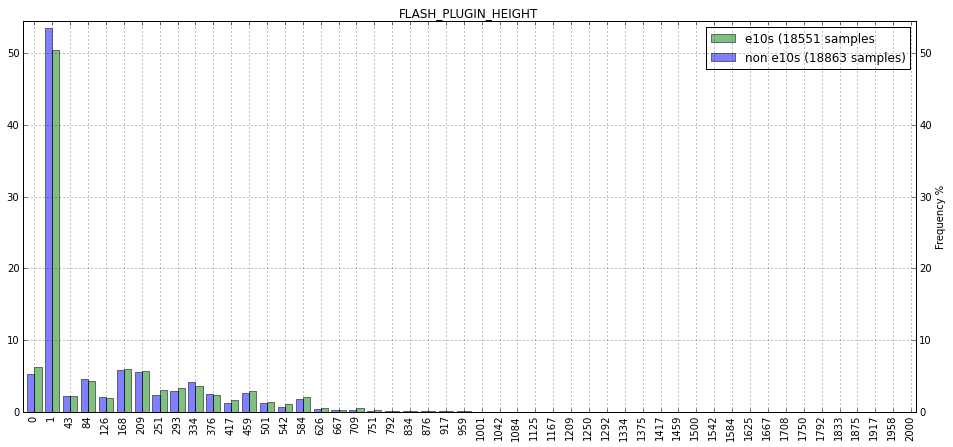

The chi2 distance for CYCLE_COLLECTOR_WORKER_VISITED_REF_COUNTED is 0.00332747840662


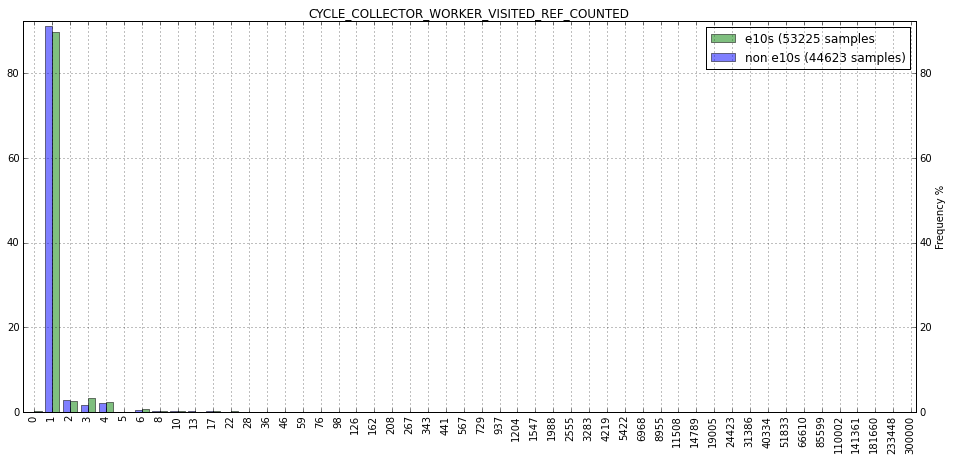

The chi2 distance for PRCONNECT_BLOCKING_TIME_LINK_CHANGE is 0.00317179673981


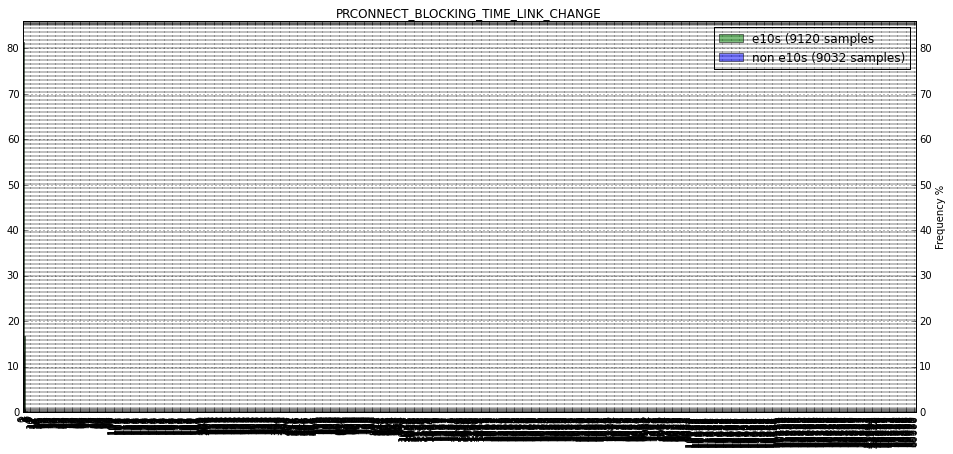

The chi2 distance for BLOCKED_ON_PLUGIN_STREAM_INIT_MS is 0.00305044862188


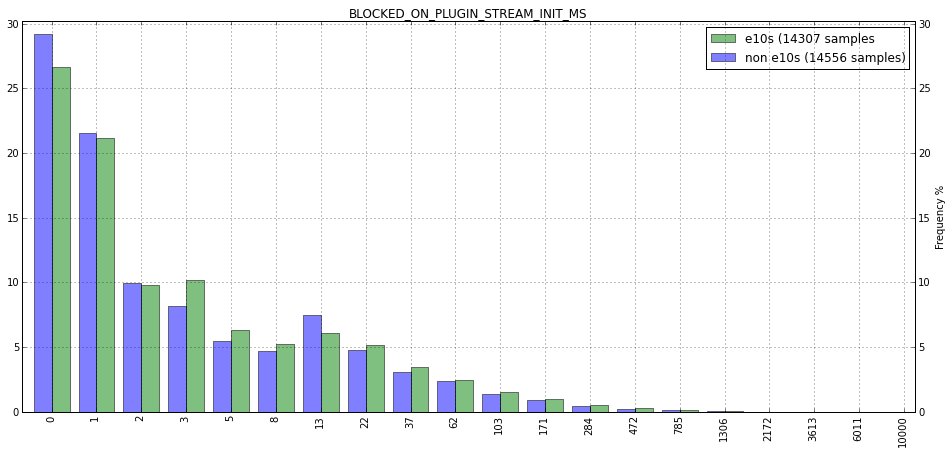

The chi2 distance for DNS_LOOKUP_METHOD2 is 0.0029781111609


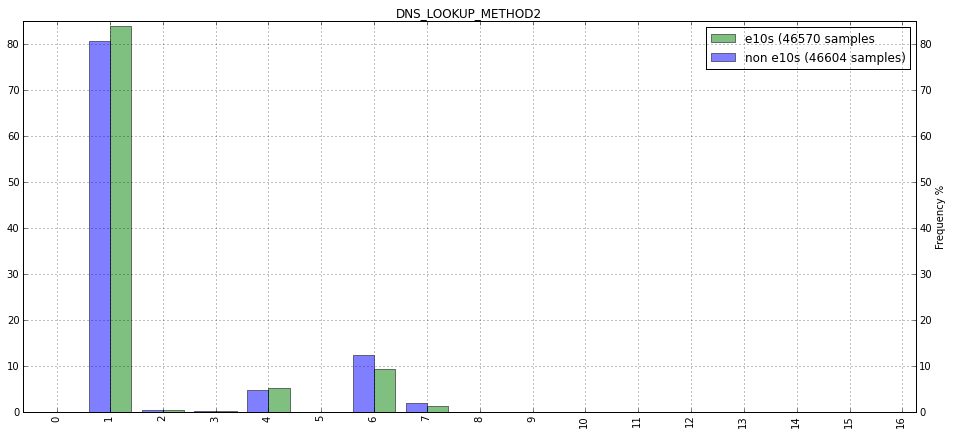

The chi2 distance for HTTP_PAGELOAD_IS_SSL is 0.00296468953141


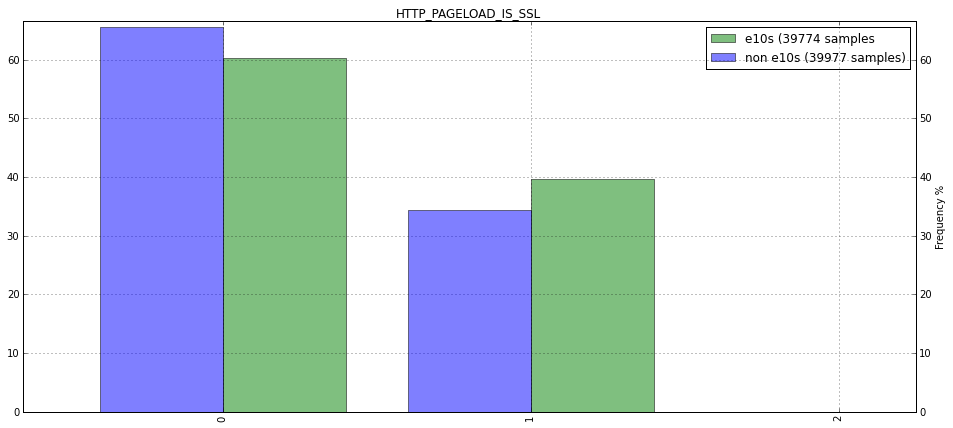

The chi2 distance for VIDEO_DECODED_H264_SPS_LEVEL is 0.00291295978673


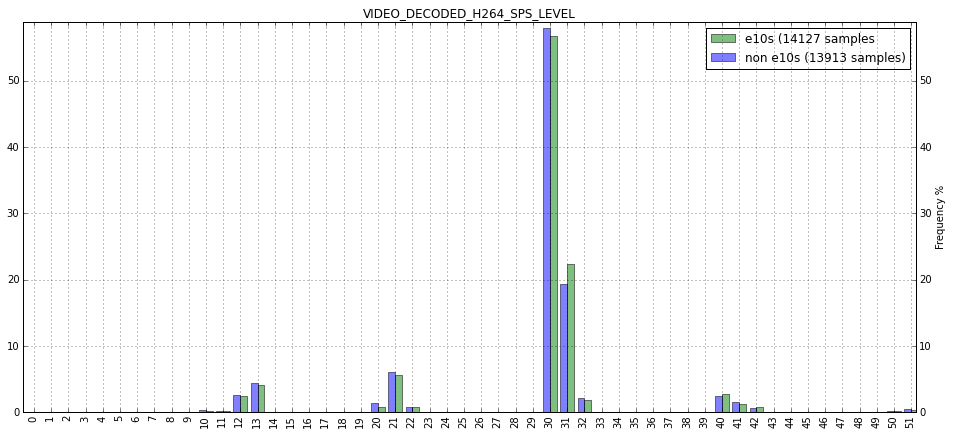

The chi2 distance for MOZ_SQLITE_OTHER_SYNC_MS is 0.00289205917194


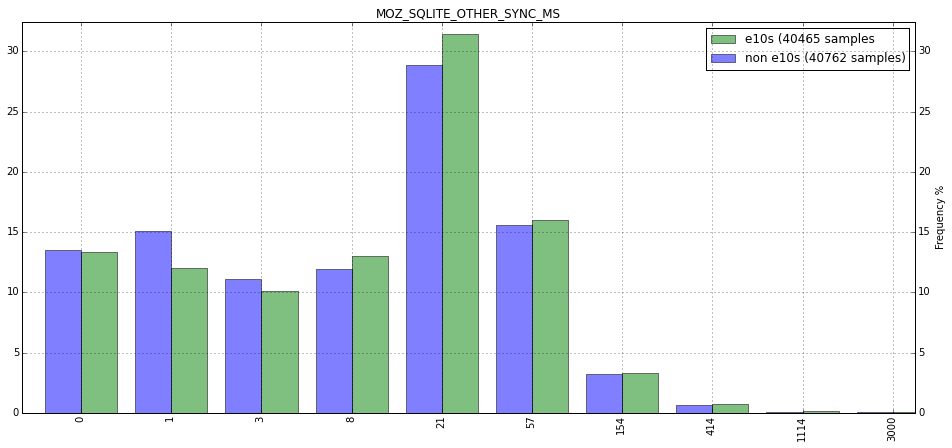

The chi2 distance for VIDEO_MSE_PLAY_TIME_MS is 0.00285419140366


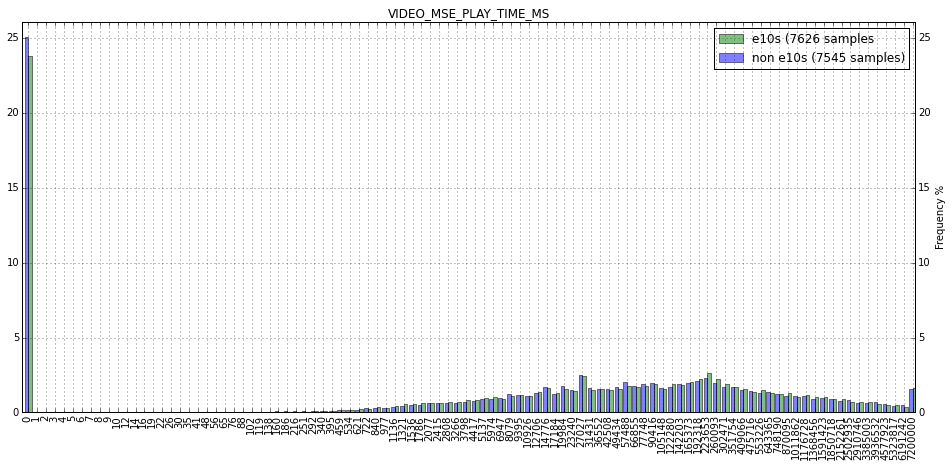

The chi2 distance for PLUGIN_SHUTDOWN_MS is 0.00282923839214


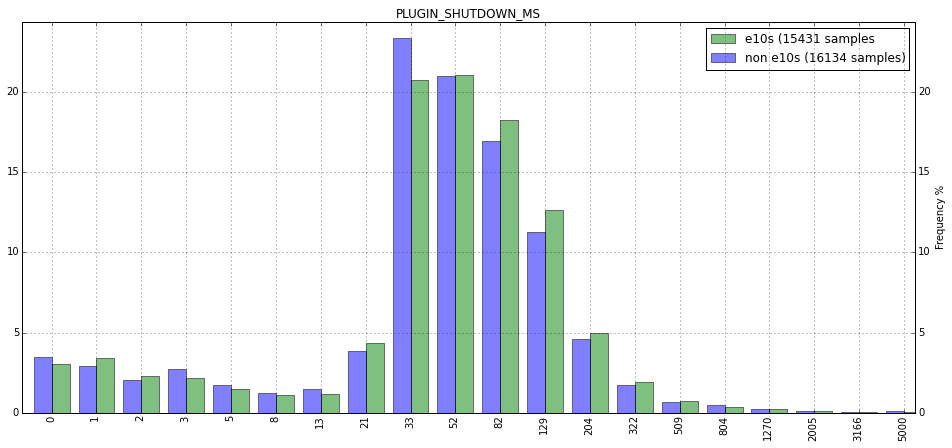

The chi2 distance for PREDICTOR_TOTAL_PRECONNECTS is 0.00281118287326


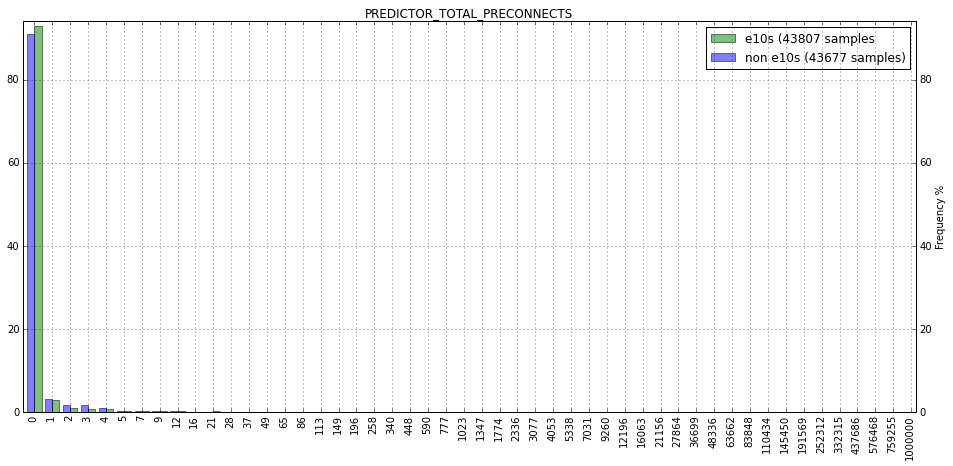

The chi2 distance for [[COUNT]]_TOP_LEVEL_CONTENT_DOCUMENTS_DESTROYED is 0.00276385801347


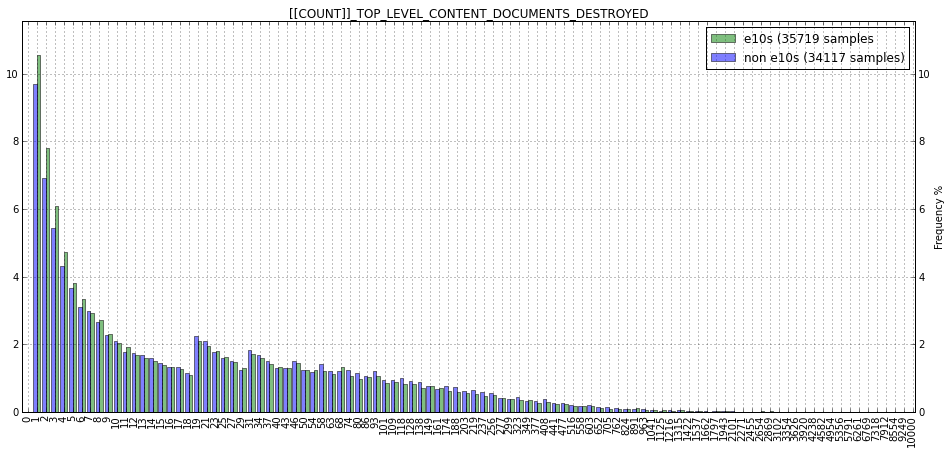

The chi2 distance for IMAGE_DECODE_TIME is 0.00275570476512


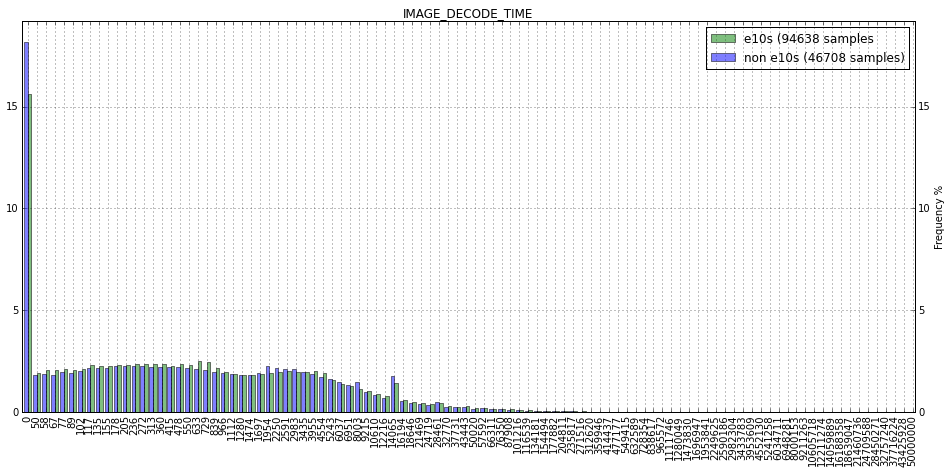

The chi2 distance for DWRITEFONT_DELAYEDINITFONTLIST_COLLECT is 0.00268702685832


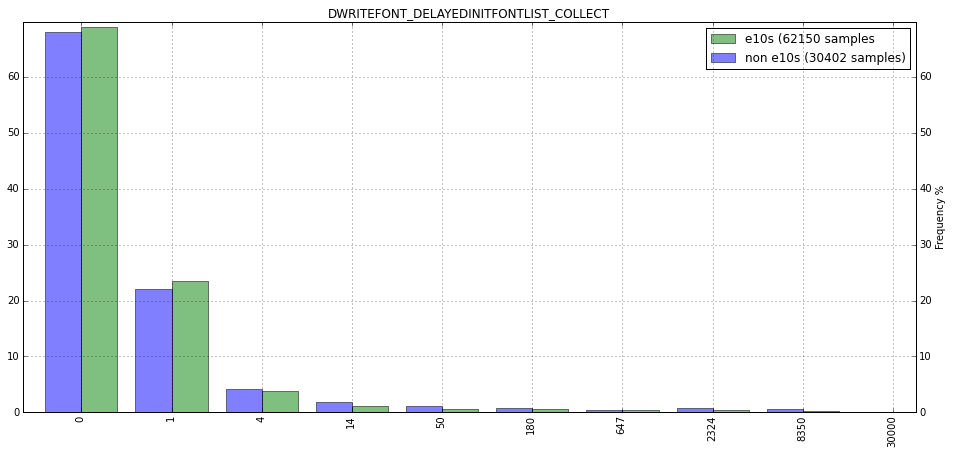

The chi2 distance for BLOCKED_ON_PLUGIN_INSTANCE_DESTROY_MS is 0.00265949713375


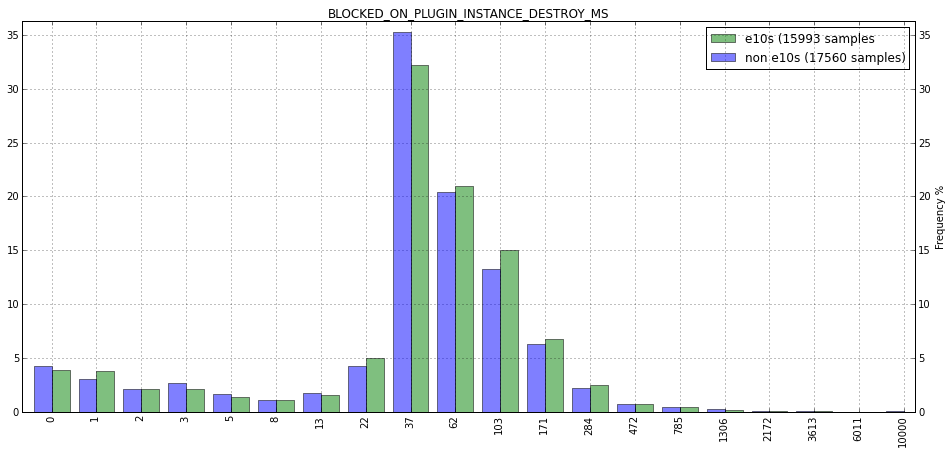

The chi2 distance for FX_SESSION_RESTORE_COLLECT_ALL_WINDOWS_DATA_MS is 0.00258012655436


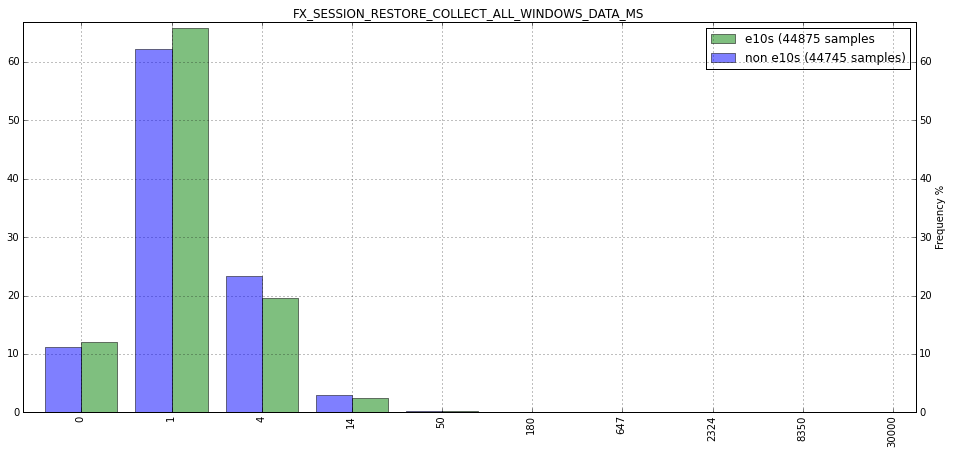

The chi2 distance for SSL_SUCCESFUL_CERT_VALIDATION_TIME_MOZILLAPKIX is 0.00256731243783


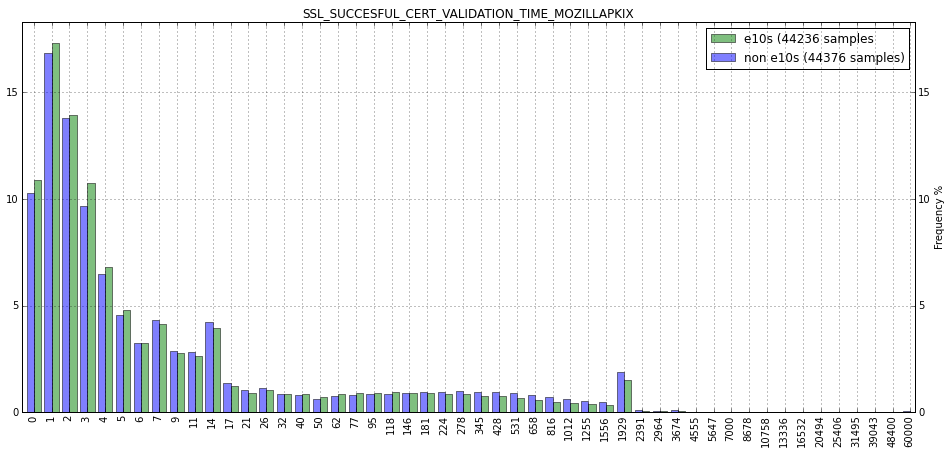

The chi2 distance for HEALTHREPORT_GENERATE_JSON_PAYLOAD_MS is 0.00254383406187


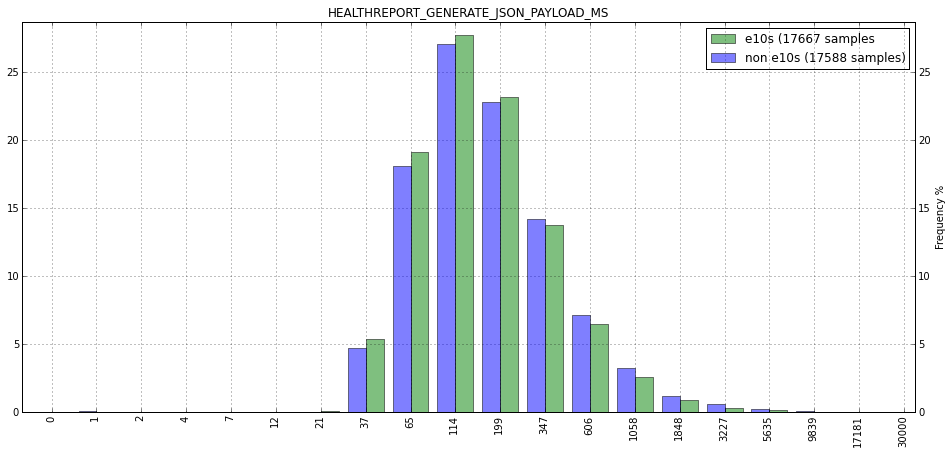

The chi2 distance for FLASH_PLUGIN_STATES is 0.00248298076801


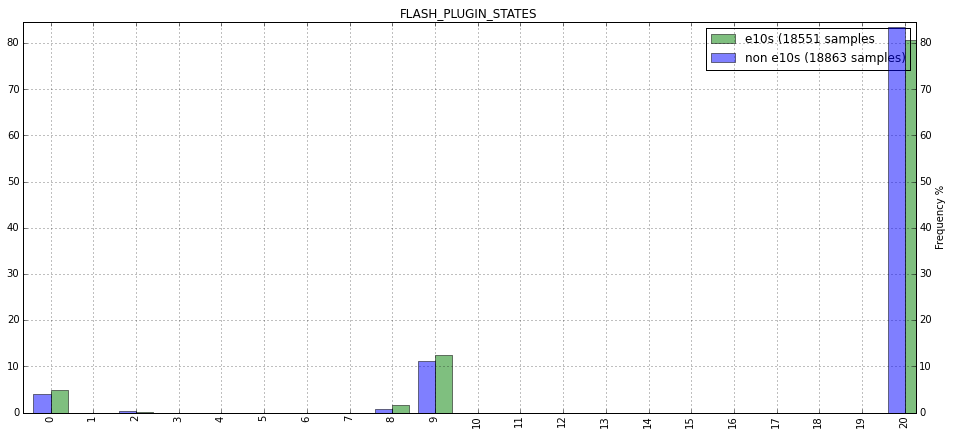

The chi2 distance for TELEMETRY_ARCHIVE_CHECKING_OVER_QUOTA_MS is 0.00242660063463


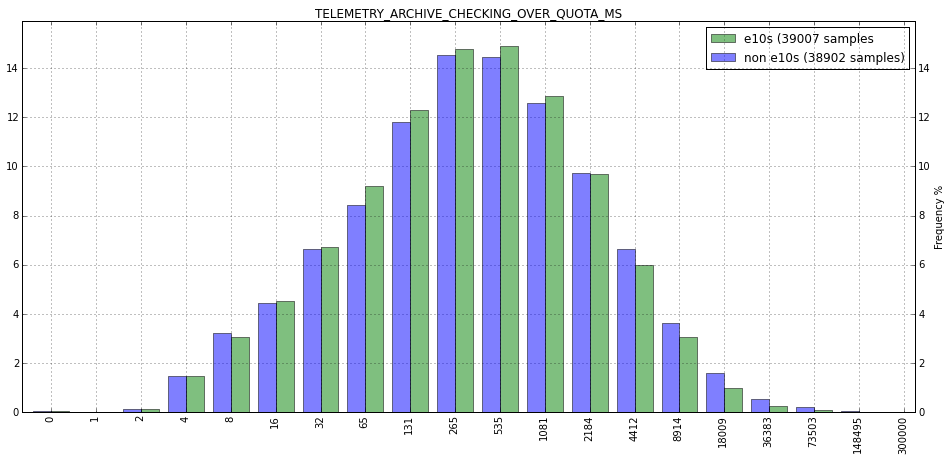

The chi2 distance for SYSTEM_FONT_FALLBACK_FIRST is 0.00234276864715


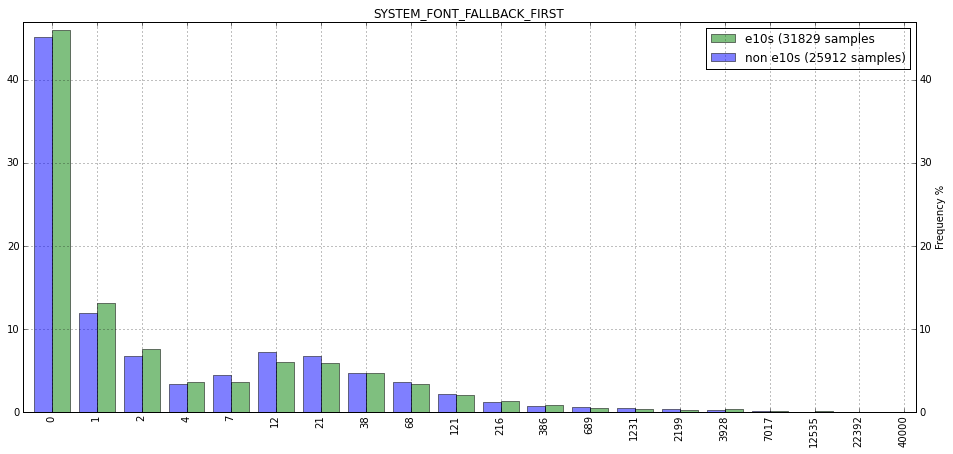

The chi2 distance for GC_NON_INCREMENTAL is 0.00233810495786


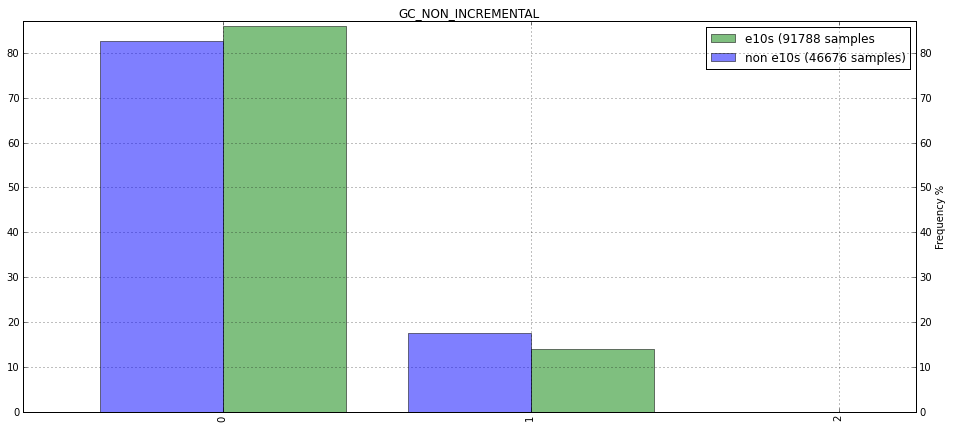

The chi2 distance for FLASH_PLUGIN_INSTANCES_ON_PAGE is 0.00228257649004


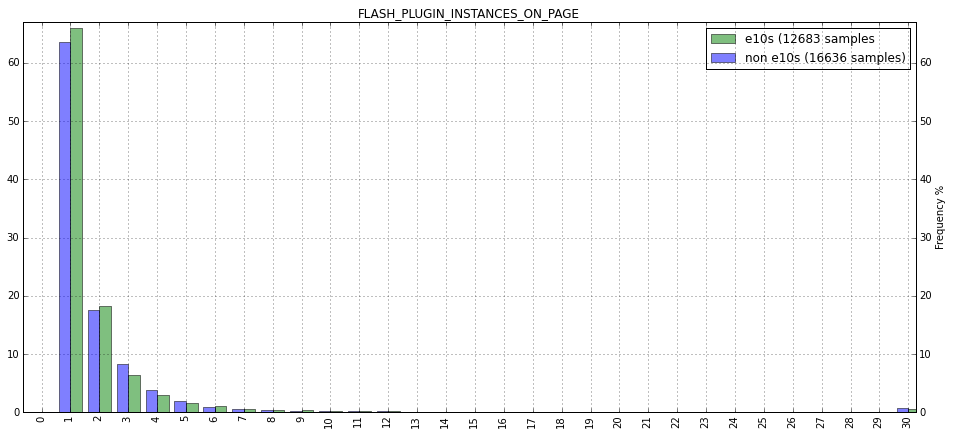

The chi2 distance for YOUTUBE_EMBED_SEEN is 0.0022315129145


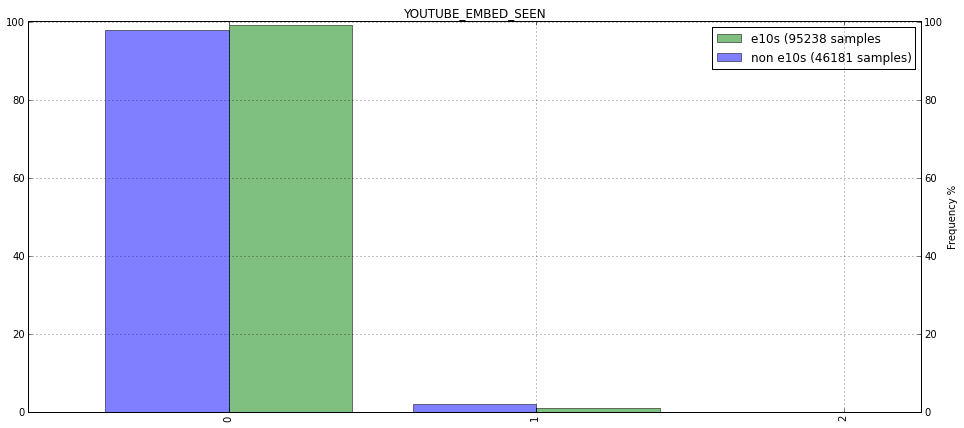

The chi2 distance for IMAGE_DECODE_SPEED_GIF is 0.002209335559


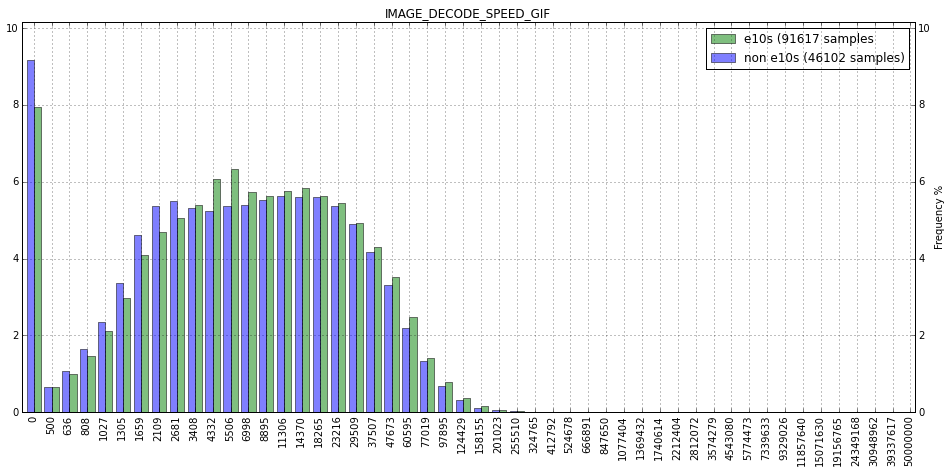

The chi2 distance for STS_POLL_AND_EVENTS_CYCLE is 0.00210956723465


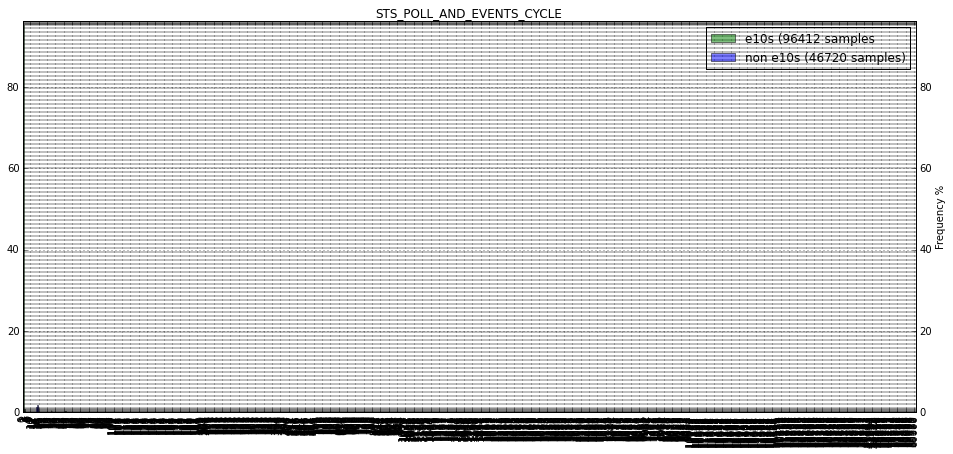

The chi2 distance for IMAGE_DECODE_COUNT is 0.00202009664613


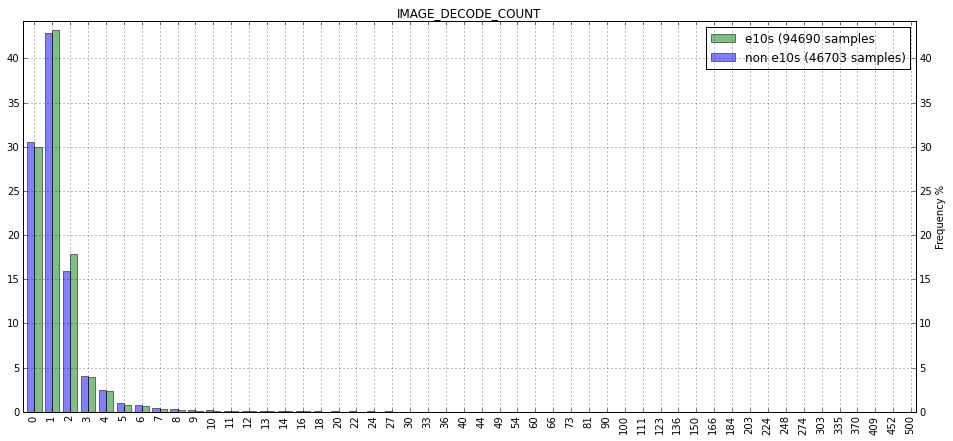

The chi2 distance for GHOST_WINDOWS is 0.0019850774863


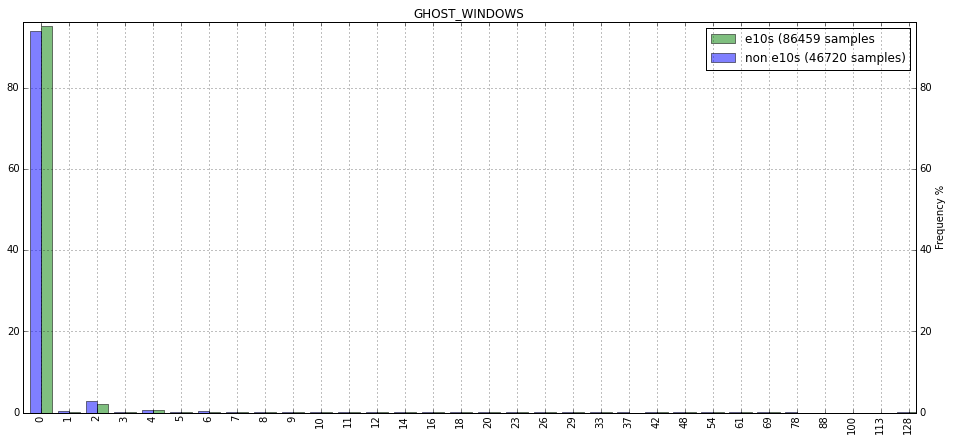

The chi2 distance for SSL_OBSERVED_END_ENTITY_CERTIFICATE_LIFETIME is 0.00193281523345


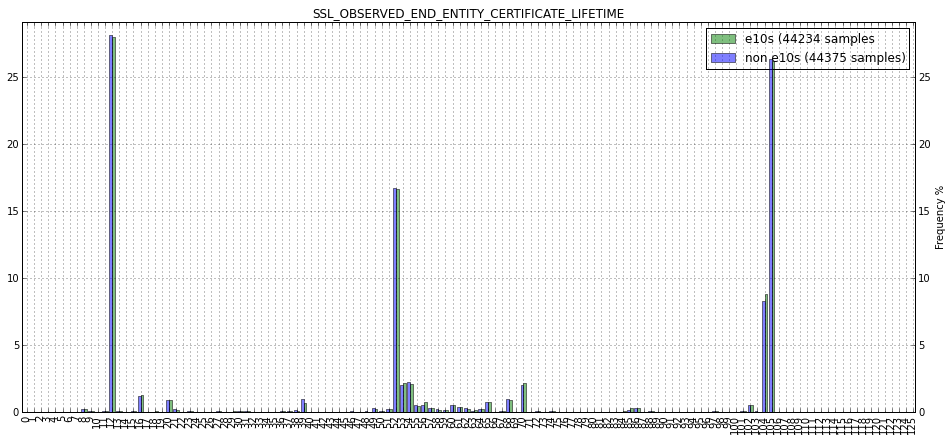

The chi2 distance for PWMGR_NUM_HTTPAUTH_PASSWORDS is 0.0019093062722


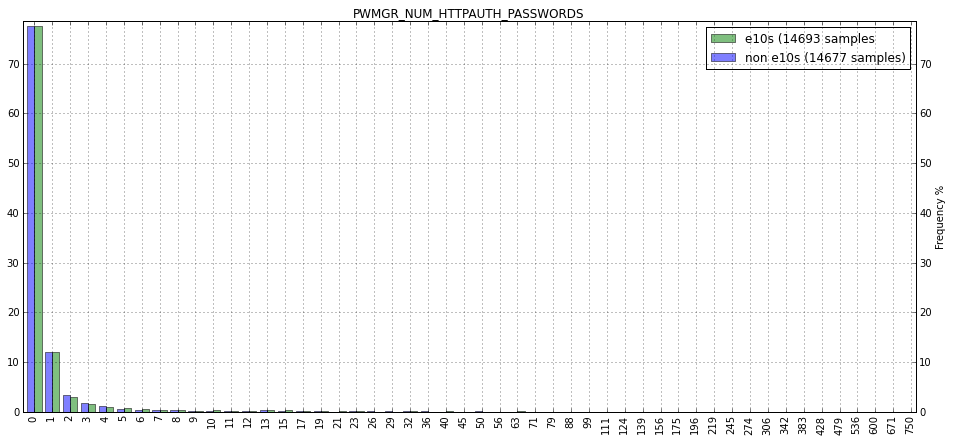

The chi2 distance for TRANSACTION_WAIT_TIME_HTTP is 0.00188911051018


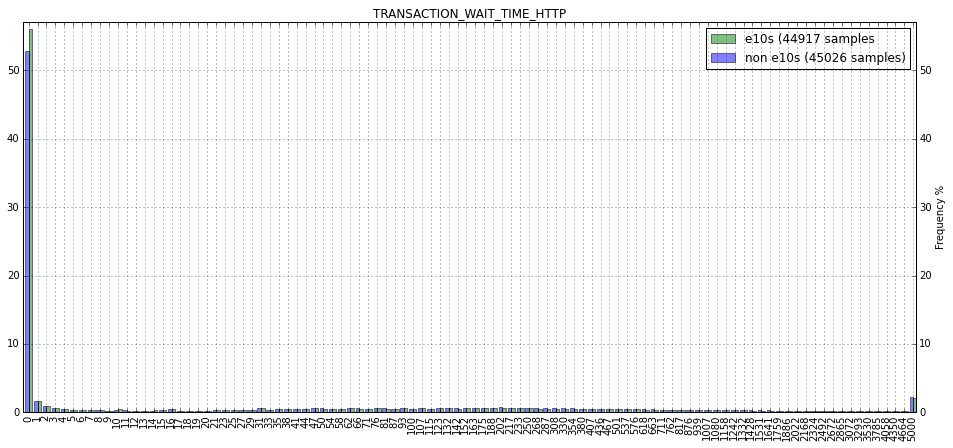

The chi2 distance for FX_THUMBNAILS_BG_CAPTURE_PAGE_LOAD_TIME_MS is 0.00183235000702


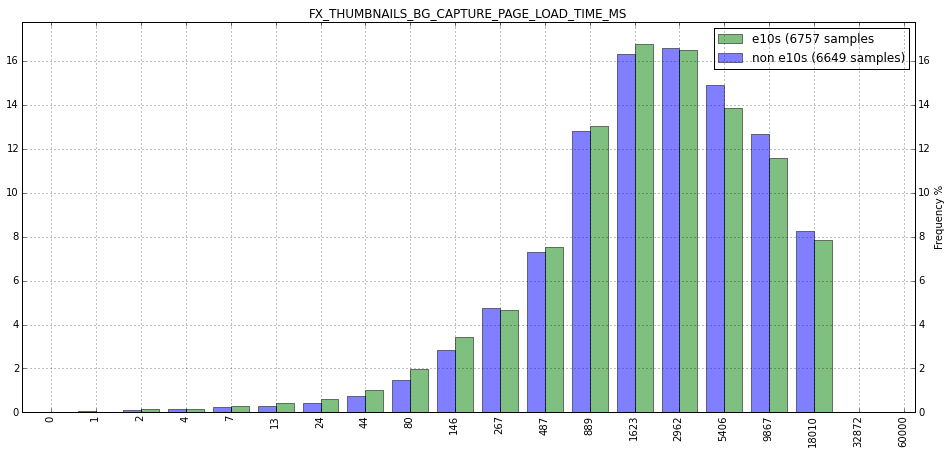

The chi2 distance for A11Y_ISIMPLEDOM_USAGE_FLAG is 0.00181186692582


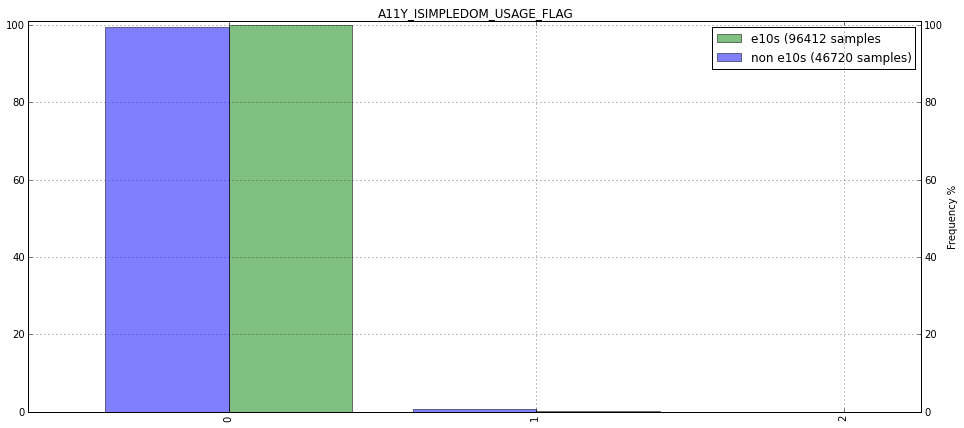

The chi2 distance for STARTUP_DNS_LOOKUP_TIME is 0.00180640926274


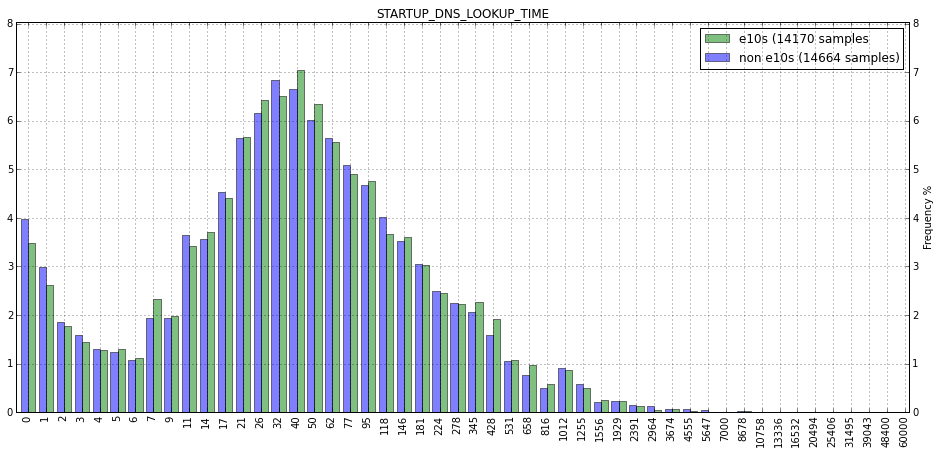

The chi2 distance for PREDICTOR_BASE_CONFIDENCE is 0.00180295827772


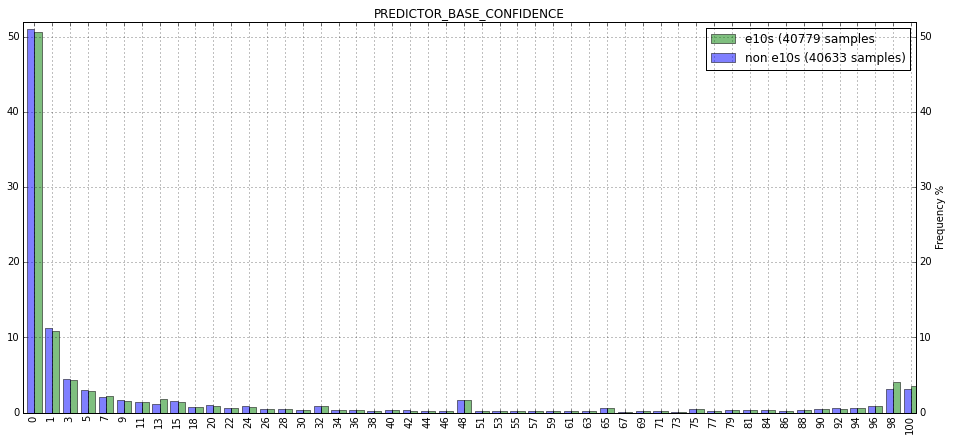

The chi2 distance for PLACES_AUTOCOMPLETE_6_FIRST_RESULTS_TIME_MS is 0.00175843454753


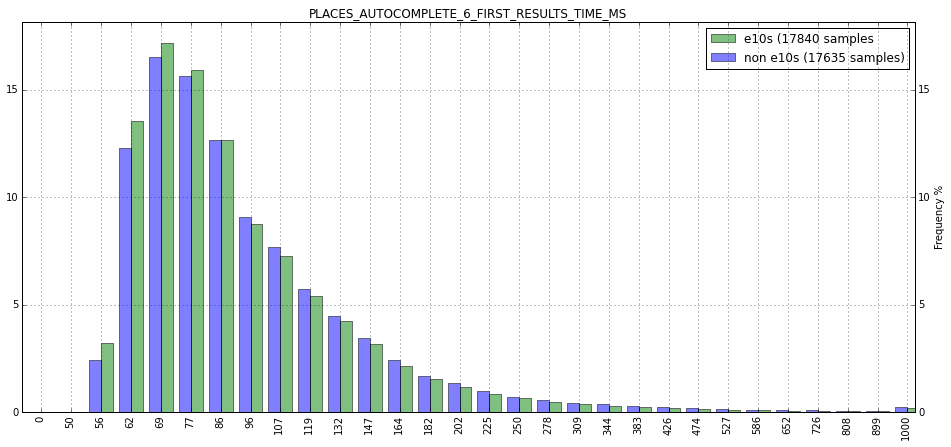

The chi2 distance for PWMGR_LOGIN_PAGE_SAFETY is 0.00171724563038


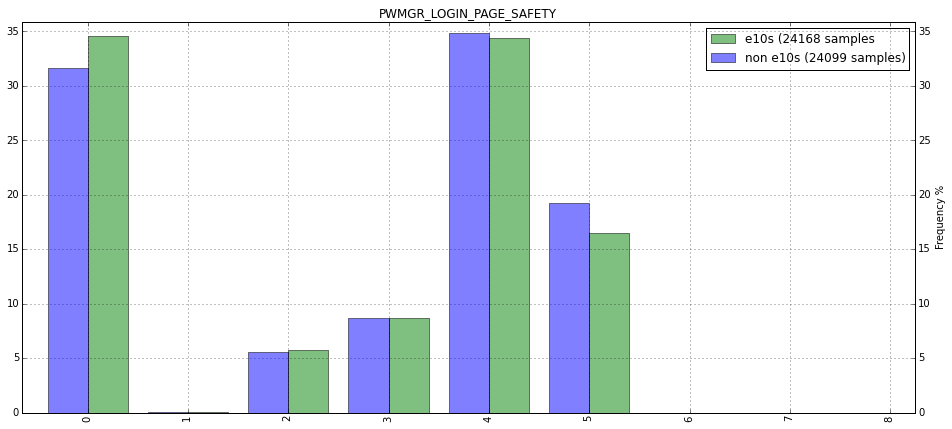

The chi2 distance for PREDICTOR_WAIT_TIME is 0.00169981497812


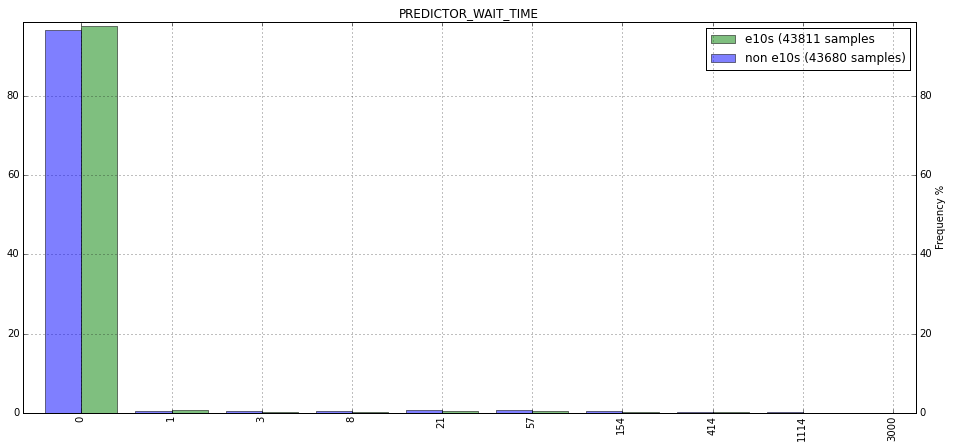

The chi2 distance for SSL_TIME_UNTIL_READY is 0.00165306536656


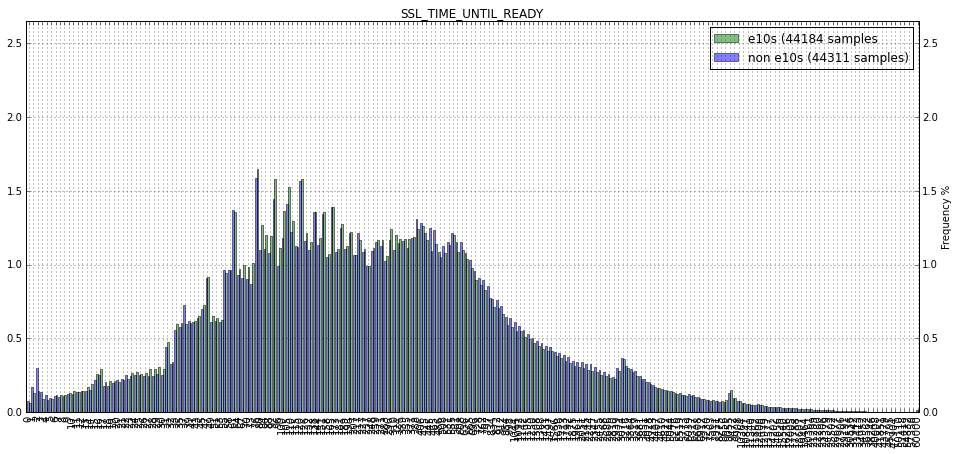

The chi2 distance for SEARCH_SERVICE_INIT_SYNC is 0.00165021795559


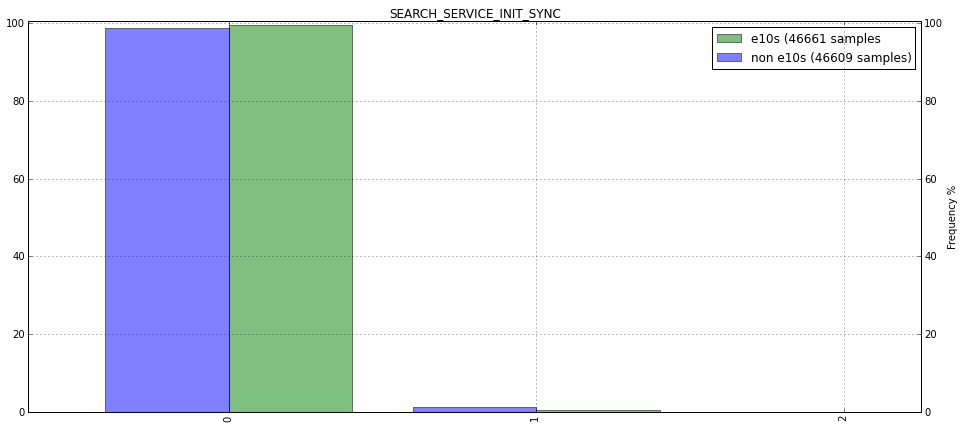

The chi2 distance for SIMPLE_MEASURES_SESSIONRESTORERESTORING is 0.00163259698003


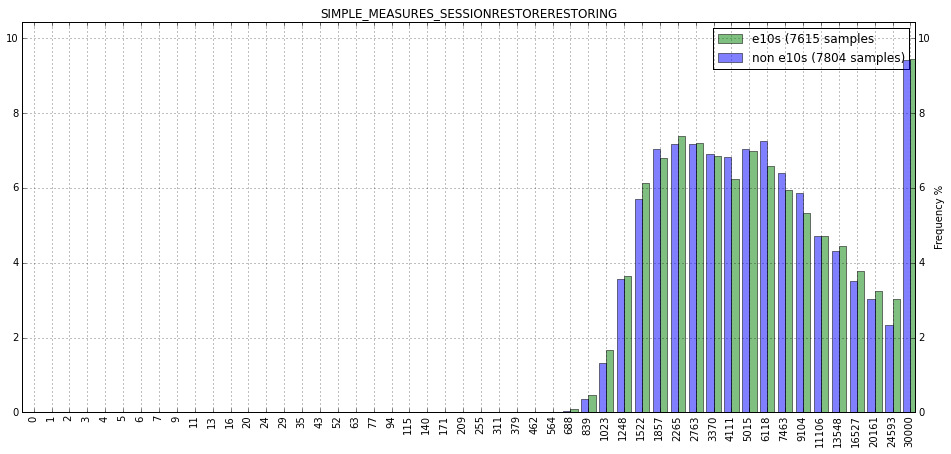

The chi2 distance for PWMGR_NUM_SAVED_PASSWORDS is 0.0016323508842


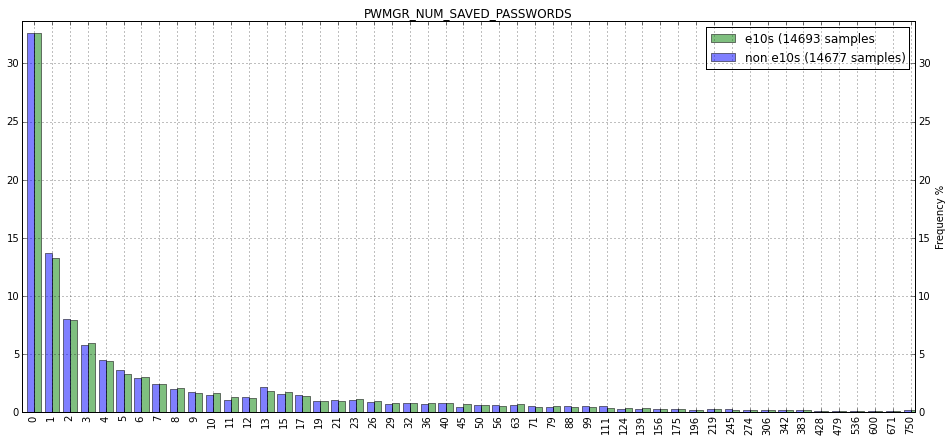

The chi2 distance for SPDY_CHUNK_RECVD is 0.00163040364287


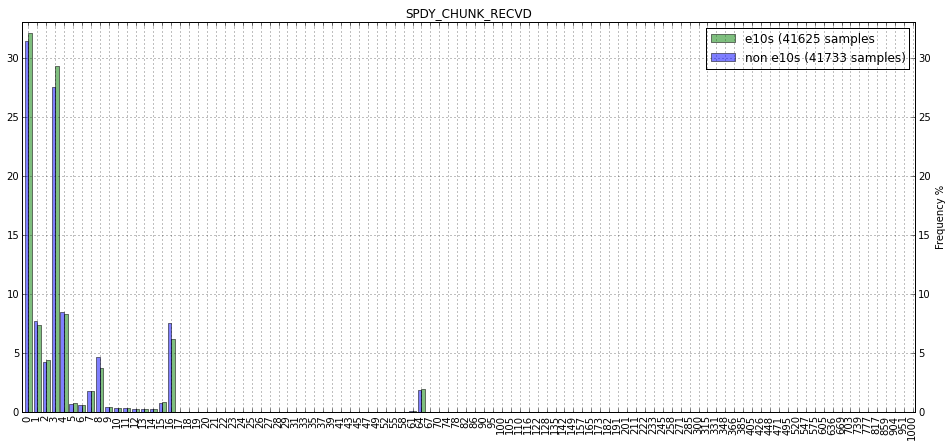

The chi2 distance for HEALTHREPORT_COLLECT_DAILY_MS is 0.00155140070121


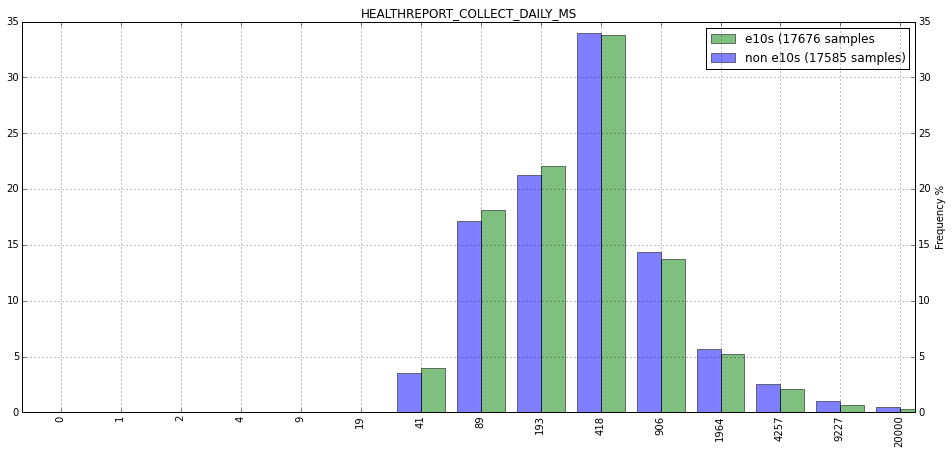

The chi2 distance for IMAGE_DECODE_SPEED_PNG is 0.00154306898603


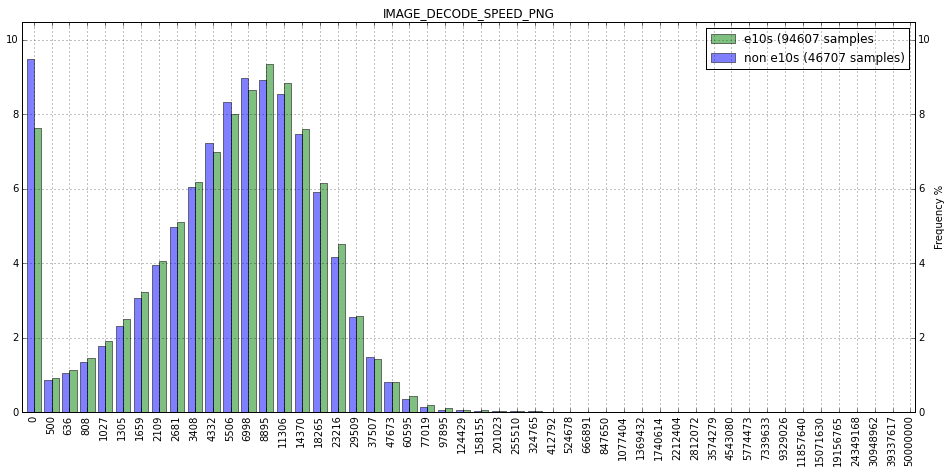

The chi2 distance for TELEMETRY_PENDING_CHECKING_OVER_QUOTA_MS is 0.00153815799162


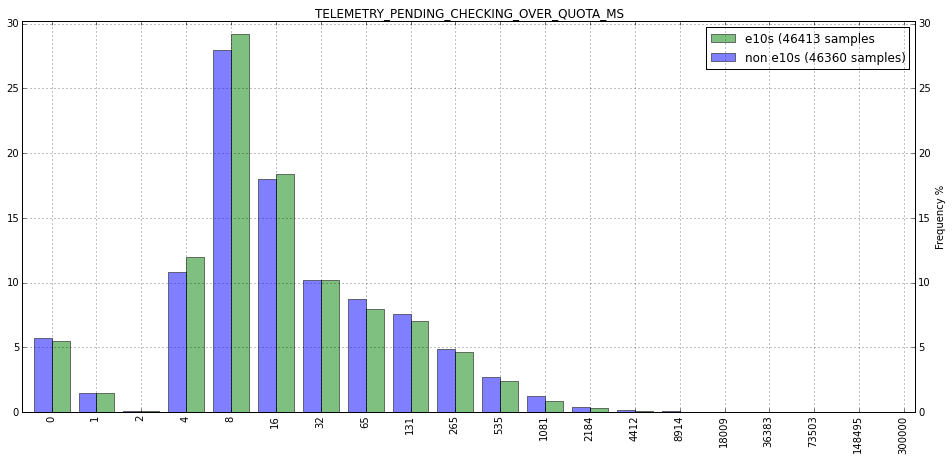

The chi2 distance for STARTUP_MOZ_SQLITE_COOKIES_OPEN_READAHEAD_MS is 0.00151444050356


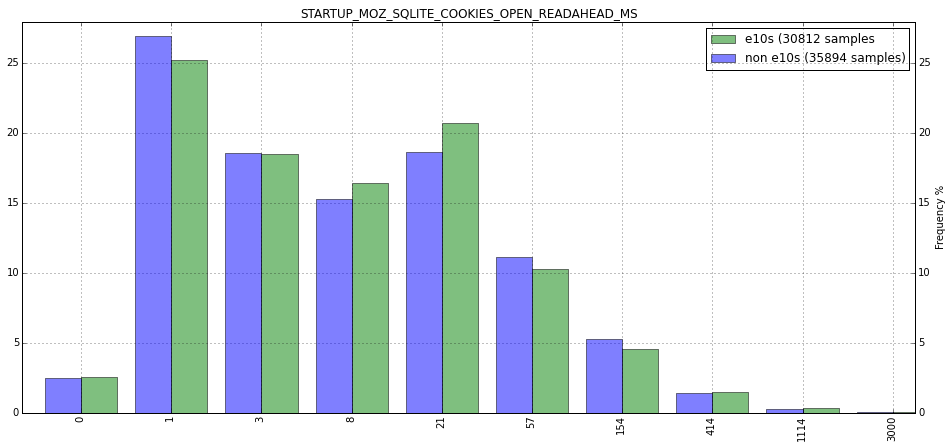

The chi2 distance for SSL_TIME_UNTIL_HANDSHAKE_FINISHED is 0.00150873492061


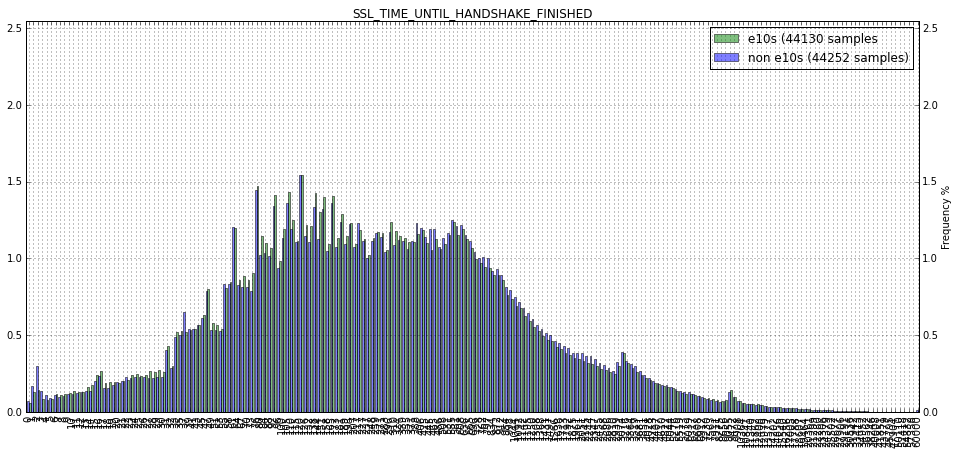

The chi2 distance for OSFILE_WRITEATOMIC_JANK_MS is 0.00150173437323


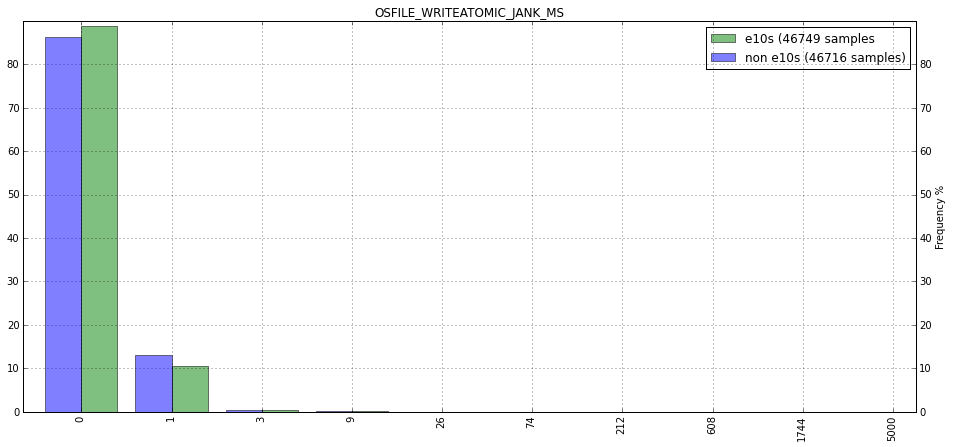

The chi2 distance for FX_THUMBNAILS_BG_QUEUE_SIZE_ON_CAPTURE is 0.00142284092914


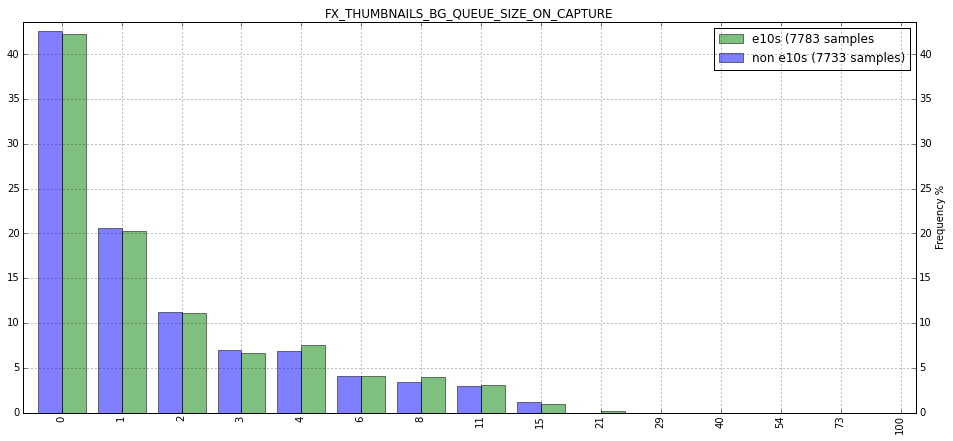

The chi2 distance for [[COUNT]]_TELEMETRY_ARCHIVE_SESSION_PING_COUNT is 0.00137655972284


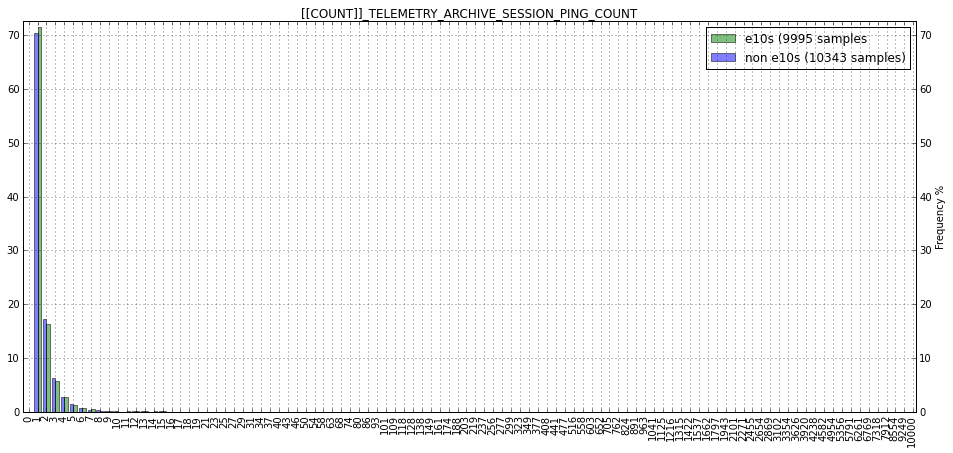

The chi2 distance for STARTUP_CRASH_DETECTED is 0.00131742033183


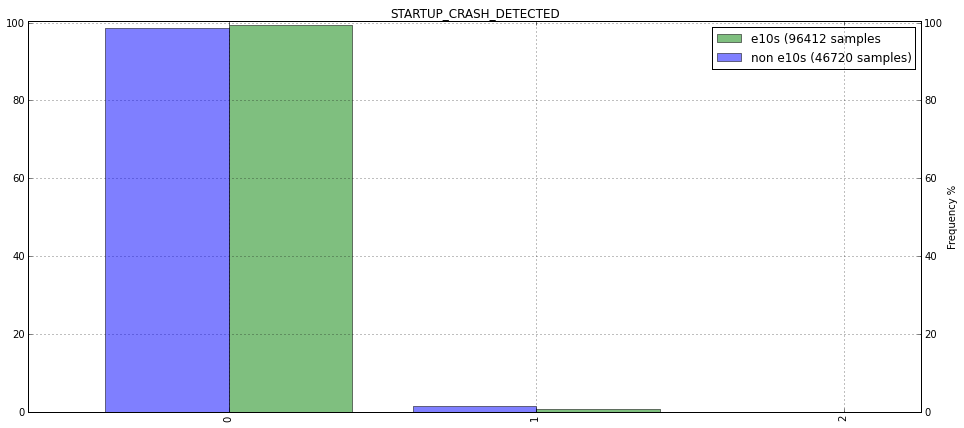

The chi2 distance for SHUTDOWN_PHASE_DURATION_TICKS_PROFILE_CHANGE_TEARDOWN is 0.00129199120592


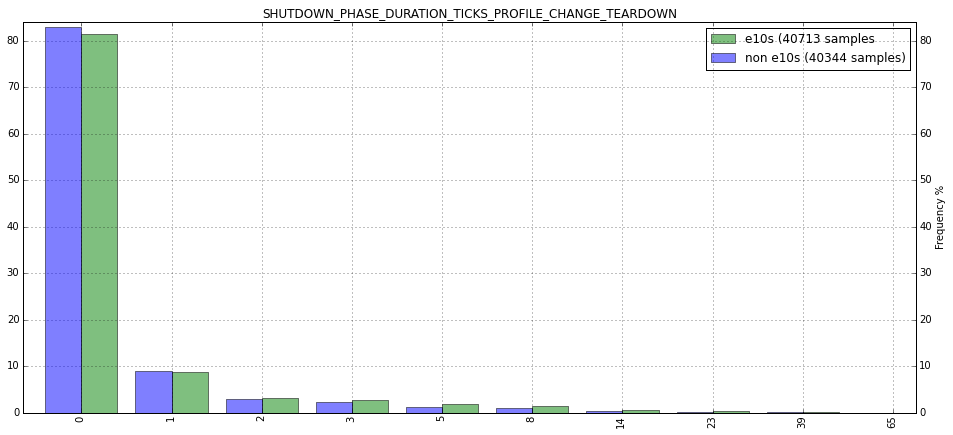

The chi2 distance for NETWORK_CACHE_METADATA_FIRST_READ_SIZE is 0.00129003927487


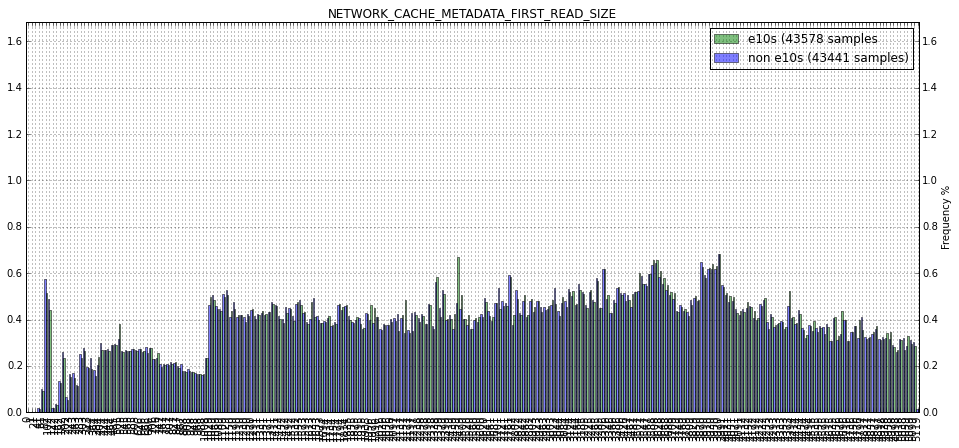

The chi2 distance for MOZ_SQLITE_OTHER_WRITE_B is 0.00128830186039


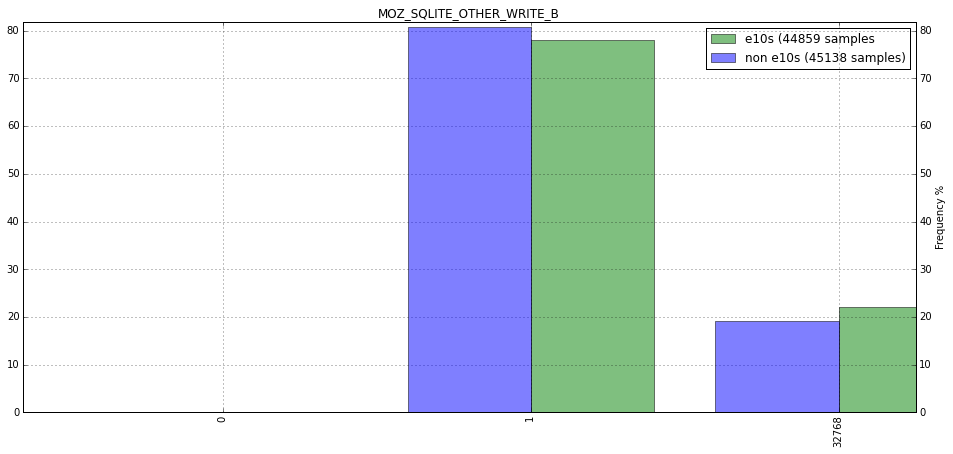

The chi2 distance for DEVTOOLS_TABS_OPEN_AVERAGE_LINEAR is 0.00122731675677


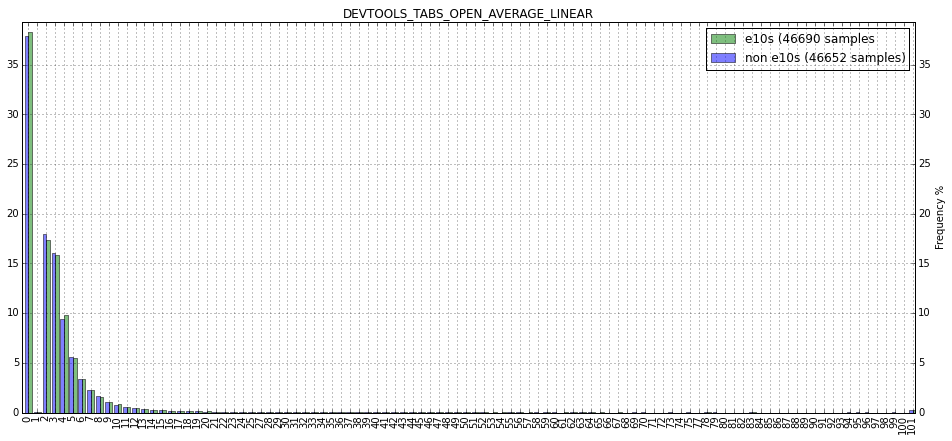

The chi2 distance for STARTUP_WORD_CACHE_MISSES_CHROME is 0.00122627377206


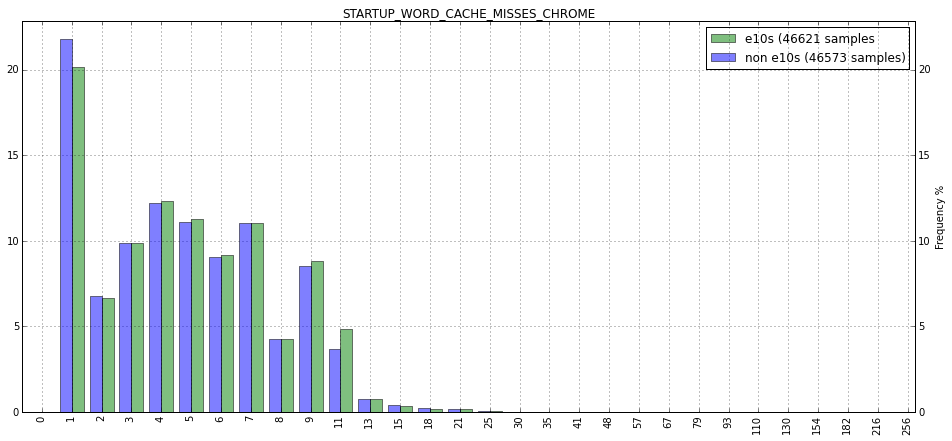

The chi2 distance for TELEMETRY_ARCHIVE_EVICTING_DIRS_MS is 0.00121158237117


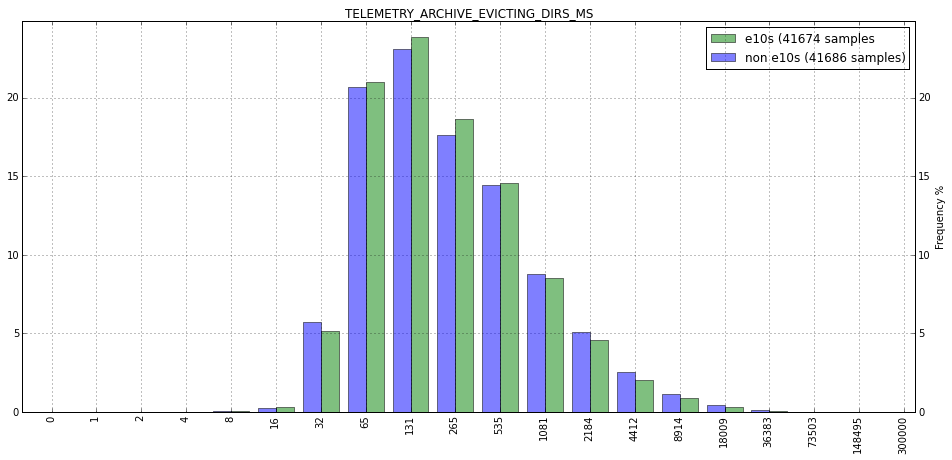

The chi2 distance for STARTUP_HTTP_SAW_QUIC_ALT_PROTOCOL is 0.00119009516601


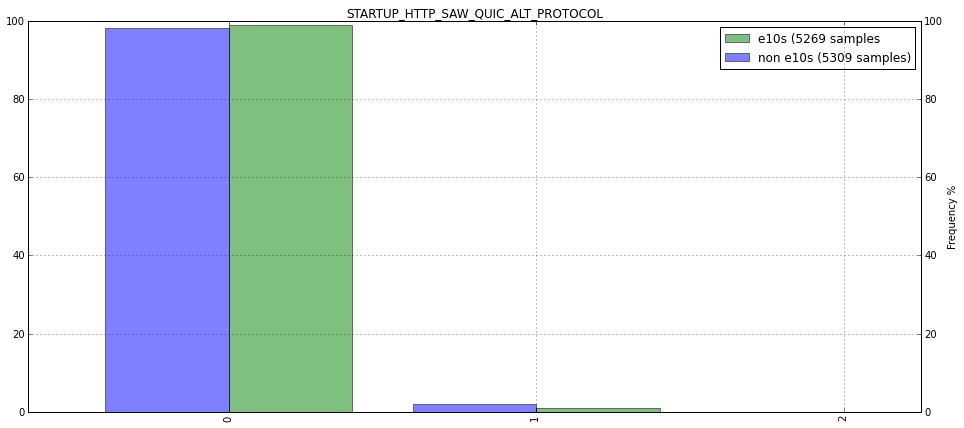

The chi2 distance for PREDICTOR_CONFIDENCE is 0.00115776289486


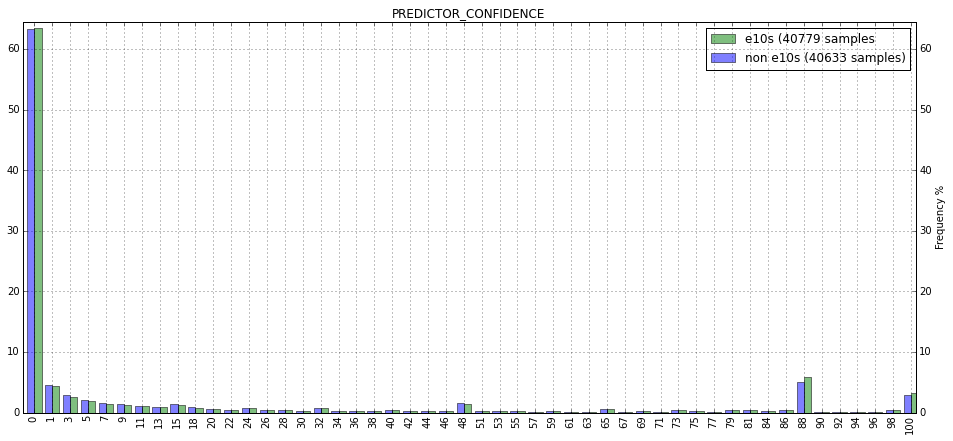

The chi2 distance for DECODER_INSTANTIATED_KOI8R is 0.00114945539526


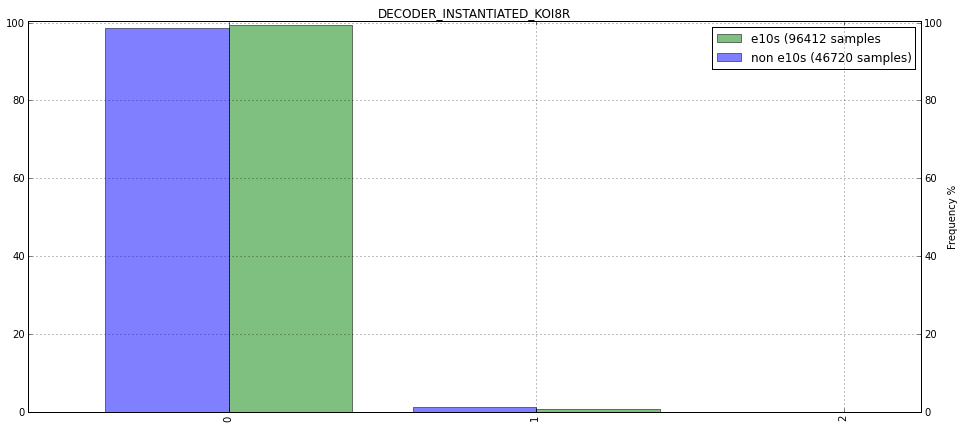

The chi2 distance for HTTP_SUB_TCP_CONNECTION is 0.00113576181805


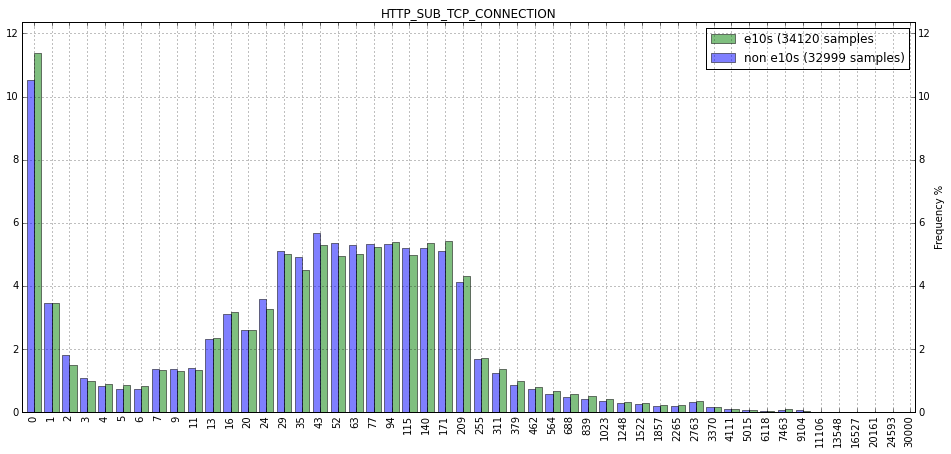

The chi2 distance for STS_POLL_BLOCK_TIME is 0.00111196742724


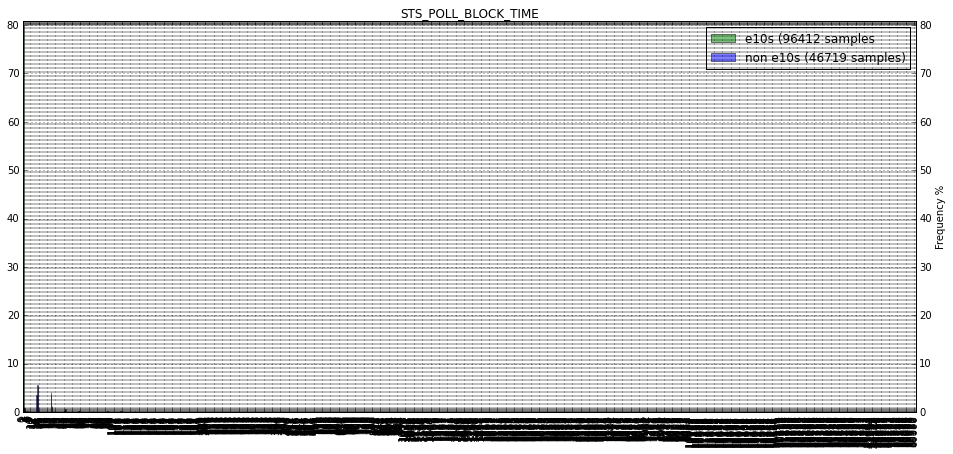

The chi2 distance for DEVTOOLS_TABS_OPEN_PEAK_LINEAR is 0.00110697065823


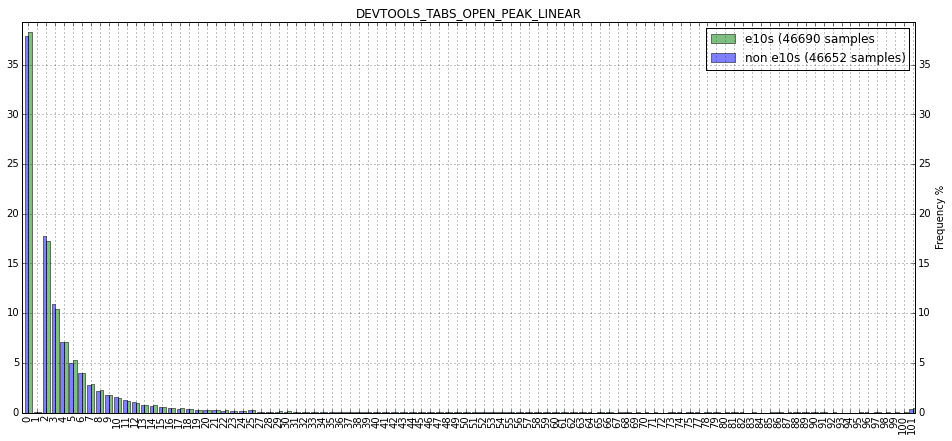

The chi2 distance for SIMPLE_MEASURES_SHUTDOWNDURATION is 0.00109528216904


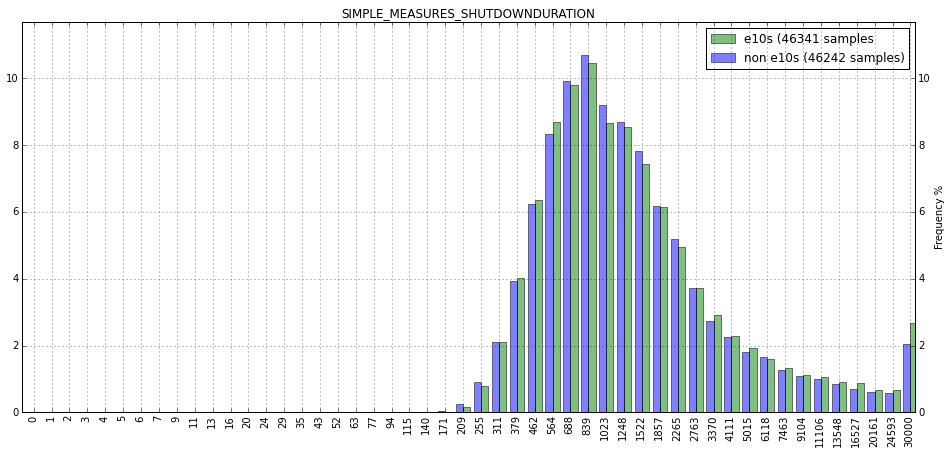

The chi2 distance for PRCLOSE_TCP_BLOCKING_TIME_LINK_CHANGE is 0.00108944560431


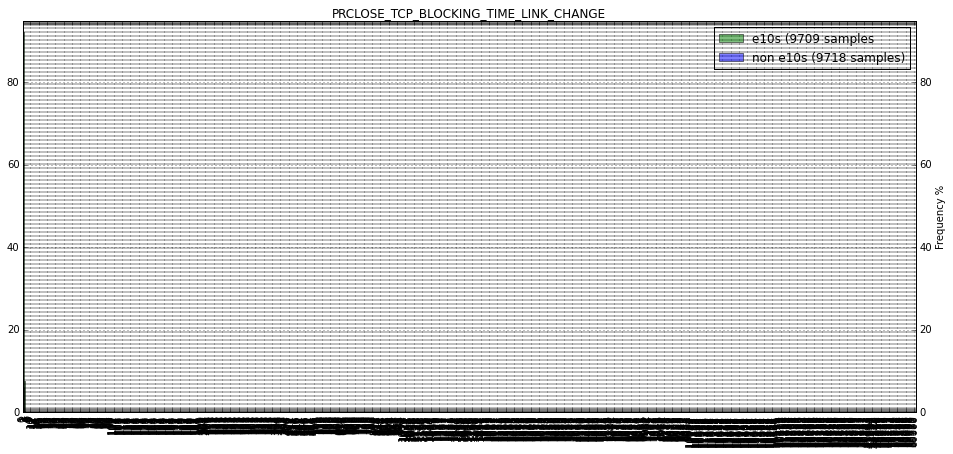

The chi2 distance for LOCALDOMSTORAGE_PRELOAD_PENDING_ON_FIRST_ACCESS is 0.00108544832884


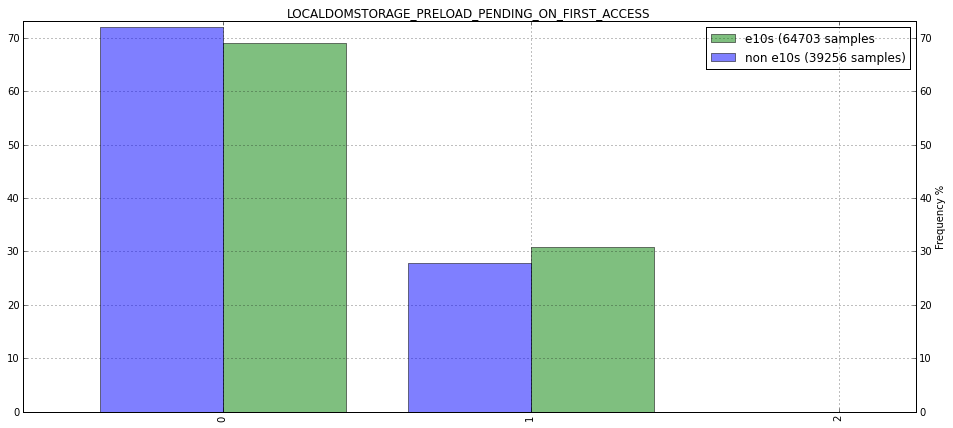

The chi2 distance for PREDICTOR_LEARN_WORK_TIME is 0.00106122318626


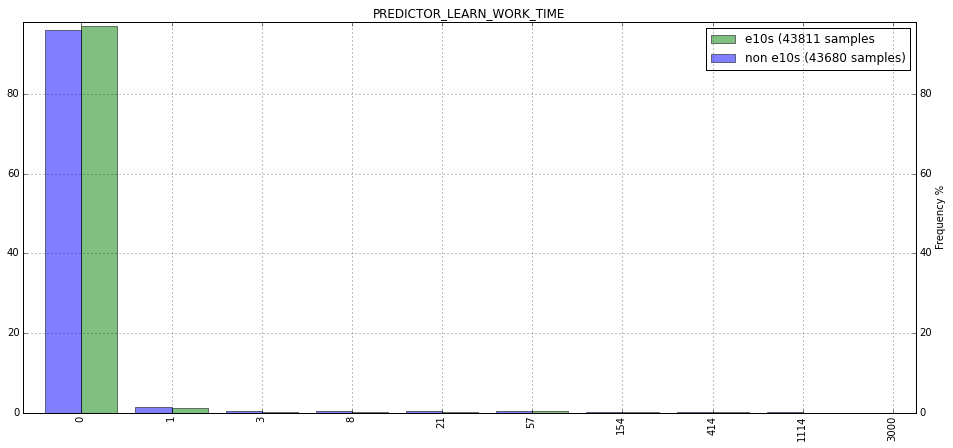

The chi2 distance for DNS_RENEWAL_TIME is 0.00105197984535


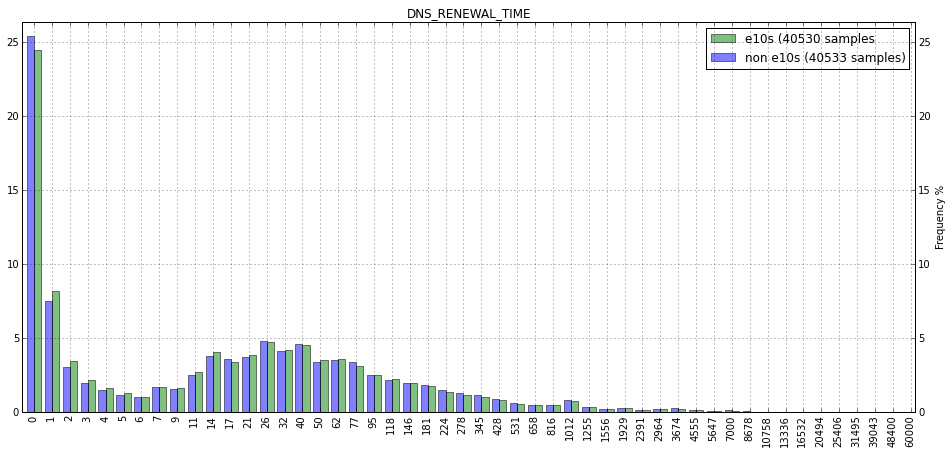

The chi2 distance for DEVTOOLS_TOOLBOX_OPENED_PER_USER_FLAG is 0.00104501135876


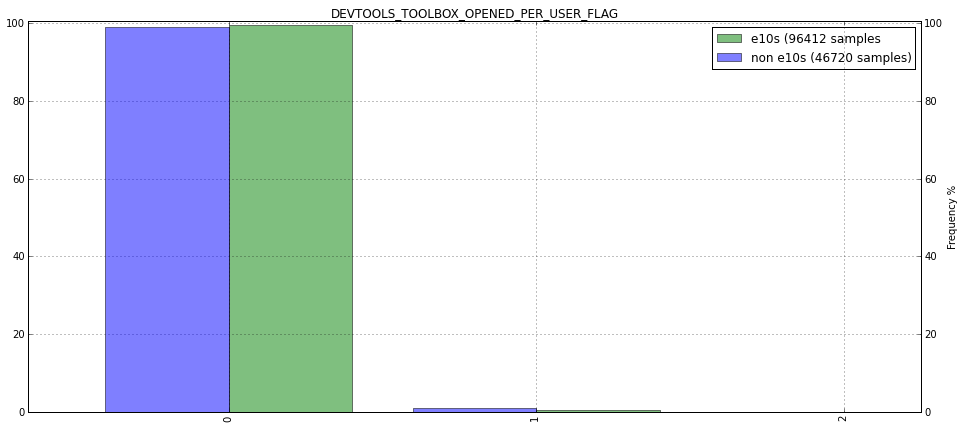

The chi2 distance for SSL_KEA_DHE_KEY_SIZE_FULL is 0.0010274271801


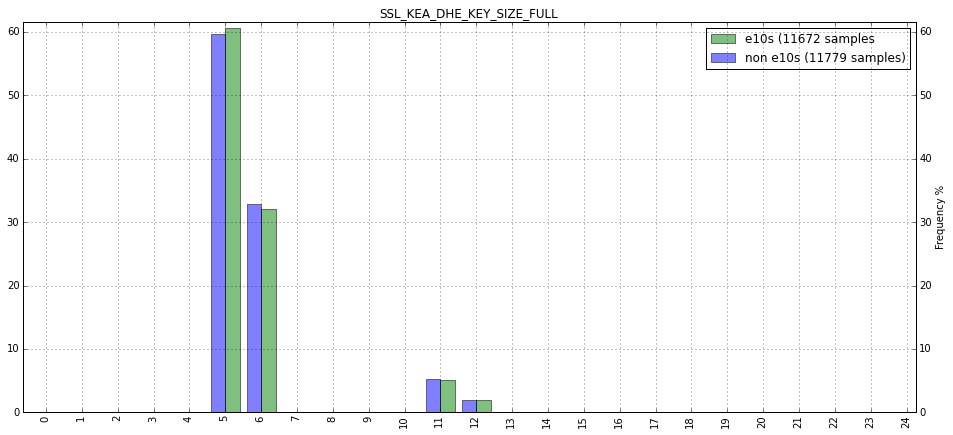

The chi2 distance for FX_SESSION_RESTORE_FILE_SIZE_BYTES is 0.00102659450119


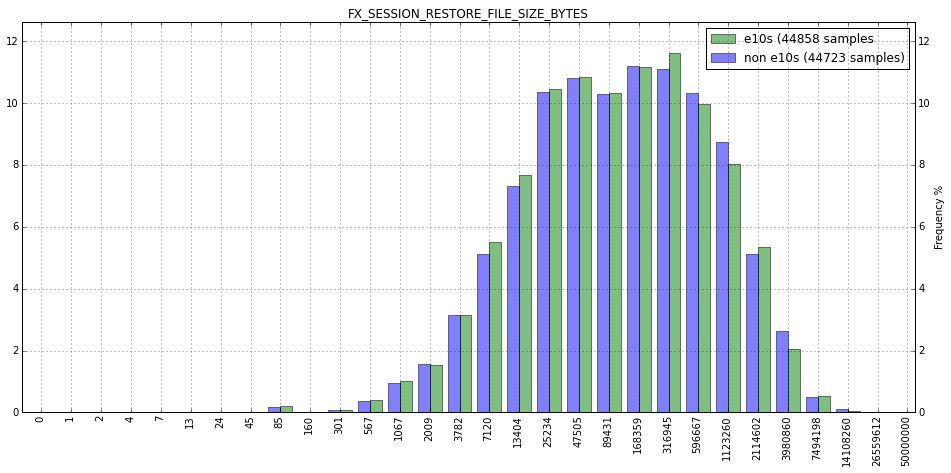

The chi2 distance for FX_THUMBNAILS_BG_CAPTURE_DONE_REASON_2 is 0.00101544178148


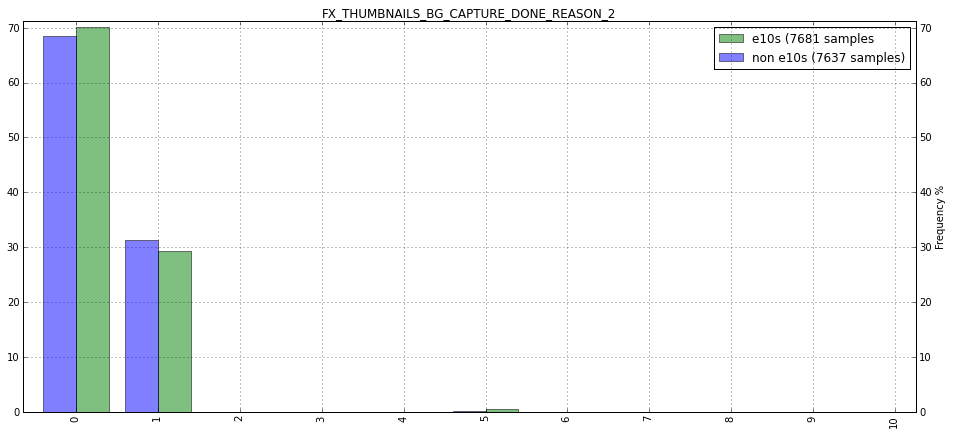

The chi2 distance for DNS_LOOKUP_TIME is 0.00100904225739


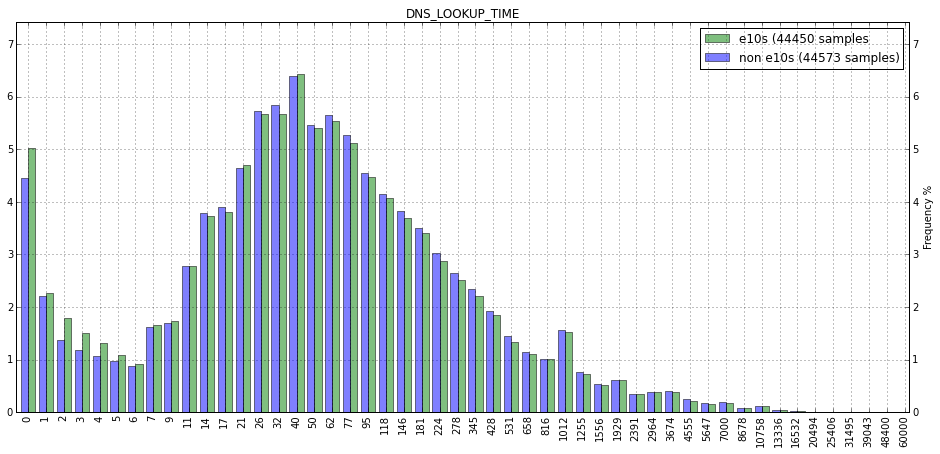

In [10]:
keys.sort(key=lambda key: chi2_distance(aggregates[0][key]["histogram"], aggregates[1][key]["histogram"]), reverse=True)

for key in keys:
    compare_histogram(key, aggregates[1][key], aggregates[0][key])    